# Bank marketing predictions - Desarrollo de modelos predictivos para la suscripción de depósitos a plazo bancario


En el presente documento, se lleva a cabo un exhaustivo análisis exploratorio de datos y la construcción de dos modelos predictivos con el propósito de lograr una definición óptima del cliente objetivo para una institución bancaria.  El conjunto de datos empleado aborda una campaña de marketing directo, específicamente una campaña telefónica, realizada por una entidad bancaria portuguesa y centrada en la promoción de depósitos a plazo fijo.

Un depósito a plazo fijo se caracteriza por ser una modalidad de inversión ofrecida por entidades financieras, en la cual se garantiza una tasa fija de interés (frecuentemente más atractiva que una cuenta de depósito convencional) y el reembolso del capital se efectúa en una fecha de vencimiento predefinida. 

A través de este análisis, se busca identificar patrones y factores determinantes que contribuyan a optimizar la estrategia de contacto para la contratación de dichos depósitos.



## 01. Introducción

**Información de atributos:**

**Datos del cliente bancario:**
* **age:** edad de los clientes
* **job:** tipo de trabajo ('admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management', 'retired', 'self-employed', 'services', 'student', 'technician', 'unemployed', 'unknown')
* **marital:** estado civil ('divorced', 'married', 'single', 'unknown' ; note: 'divorced' means divorced or widowed)
* **education**: ('basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'illiterate', 'professional.course', 'university.degree', 'unknown')
* **default**: ¿tiene crédito en incumplimiento? ('no', 'yes', 'unknown')
* **housing**: ¿tiene préstamo de vivienda? ('no', 'yes', 'unknown')
* **loan**: ¿tiene préstamo personal? ('no', 'yes', 'unknown')

**Datos relacionados con el último contacto de la campaña actual:**
* **contact**: tipo de comunicación del contacto ('cellular','telephone')
* **month**: mes del año del último contacto ('jan', 'feb', 'mar', …, 'nov', 'dec')
* **day_of_week**: último día de contacto de la semana ('mon','tue','wed','thu','fri')
* **duration**: duración del último contacto, en segundos (numérico). **Nota importante:** este atributo afecta en gran medida el objetivo de salida (por ejemplo, si duración=0 entonces y='no'). Sin embargo, no se conoce la duración antes de realizar una llamada. Además, después del final de la llamada, obviamente se conoce y. Por lo tanto, esta entrada sólo debe incluirse con fines de referencia y debe descartarse si la intención es tener un modelo predictivo realista.

**Campaña anterior:**
* **campaign**: número de contactos realizados durante esta campaña y para este cliente.
* **Pdays**: número de días que pasaron después de que el cliente fue contactado por última vez desde una campaña anterior (999 significa que el cliente no fue contactado previamente)
* **previous**: número de contactos realizados antes de esta campaña y para este cliente.
* **poutcome**: resultado de la campaña de marketing anterior ('failure','nonexistent','success')

**Atributos del contexto social y económico**
* **Emp.var.rate**: tasa de variación del empleo - indicador trimestral.
* **Cons.price.idx**: índice de precios al consumidor - indicador mensual
* **Cons.conf.idx**: índice de confianza del consumidor - indicador mensual
* **Euribor3m**: tipo de cambio euribor a 3 meses - indicador diario
* **nr.employed**: número de empleados - indicador trimestral

**Variable de salida (objetivo deseado):**'
* **y** - ¿el cliente ha suscrito un depósito a plazo? ('yes', 'no')


## 02. Ajustes iniciales

### Importación de bibliotecas

In [322]:
# Importación de bibliotecas 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import seaborn as sns
import plotly.graph_objs as go
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from scipy.stats import spearmanr
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, precision_score, accuracy_score, recall_score, mean_absolute_error, mean_squared_error, precision_recall_curve, classification_report, average_precision_score


from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
import phik
from sklearn.svm import SVC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from xgboost import XGBClassifier
import pickle

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)



In [323]:
#Plantilla de colores
colores = ['#AEC7E8', '#8FBC8F', '#FFF5E1', '#E87C7C', '#ADD8E6', '#FFDEAD', '#E6E6FA', '#D2B48C', '#FFB6C1', '#CD853F', '#DDA0DD', '#B0C4DE']

### Lectura de CSV

In [324]:
# Lectura de CSV
bank_marketing = pd.read_csv('../data/bank-additional-full.csv', sep=";")

In [325]:
# Información del dataset
bank_marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

Afortunadamente, no faltan valores. Si faltaran valores tendría que rellenarlos con la mediana, media o moda.

In [326]:
# Información del dataset
bank_marketing.head(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Estadística descriptiva de los valores numéricos

In [327]:
# Estadística descriptiva de los valores numéricos
bank_marketing.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


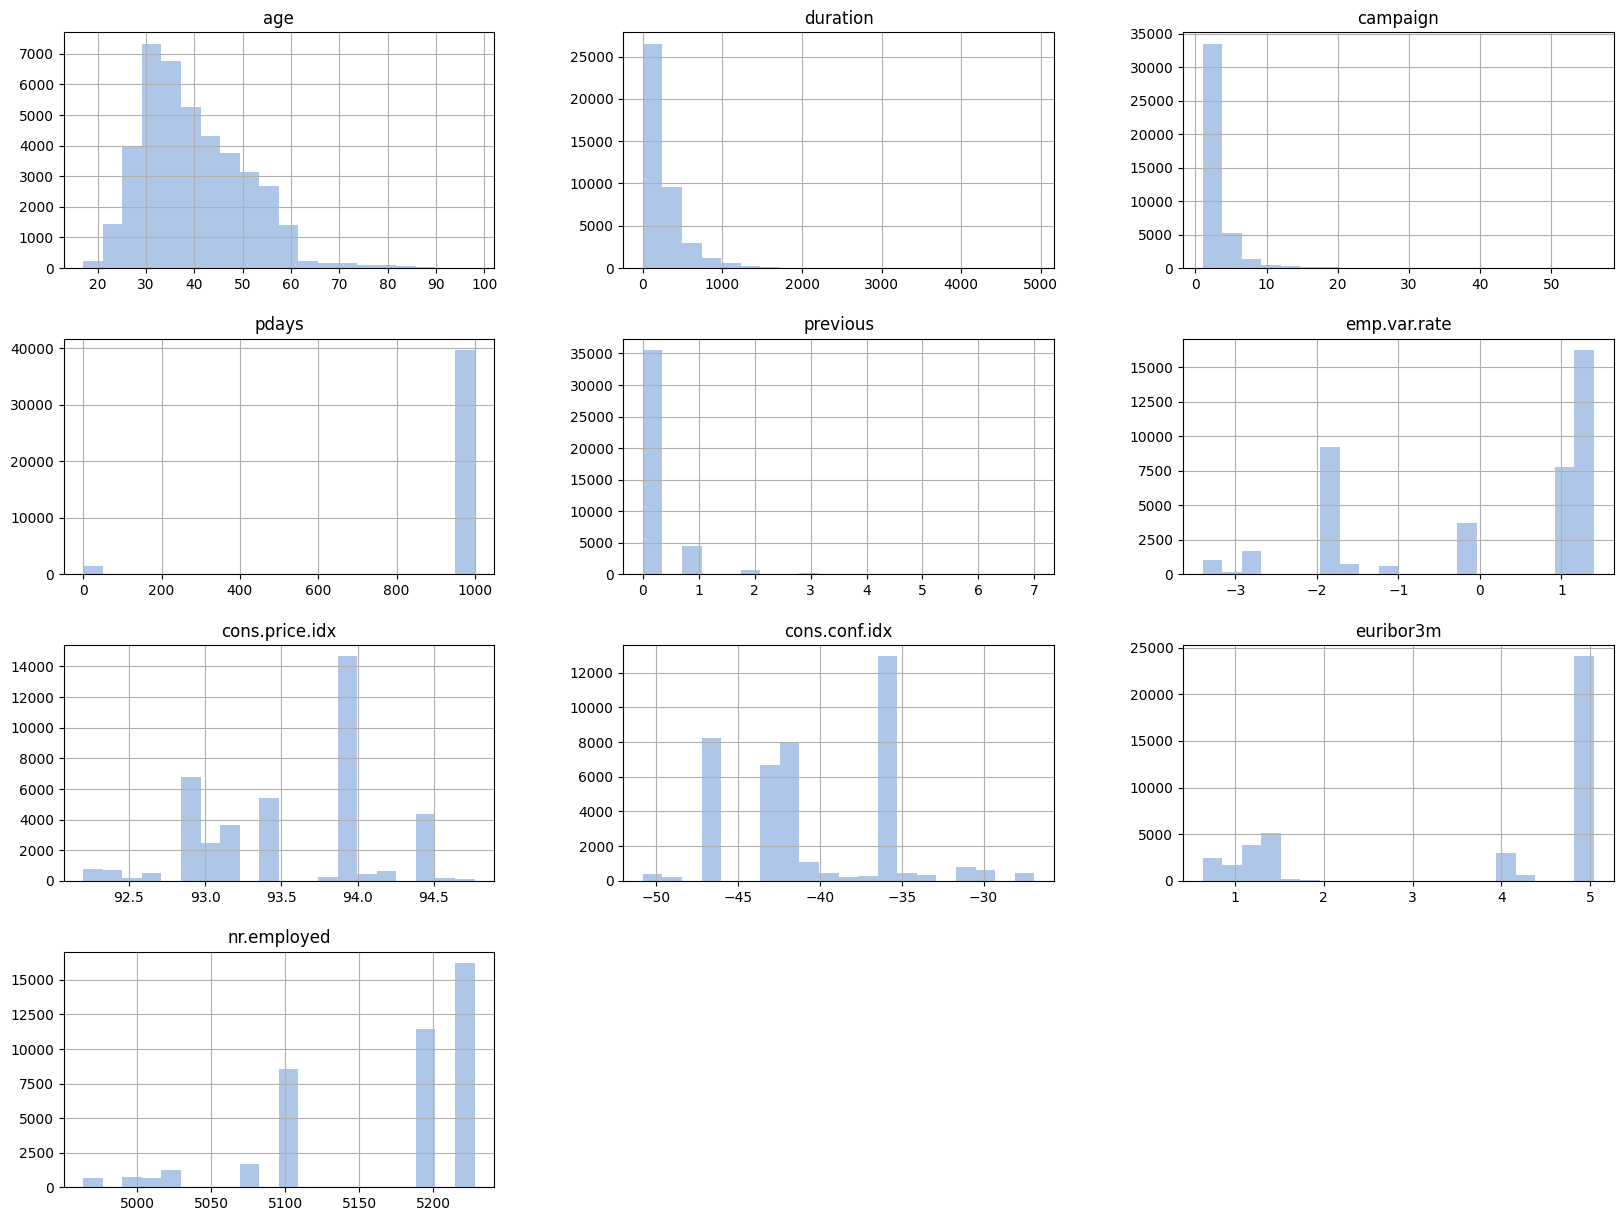

In [328]:
#Histograma de los valores numéricos
bank_marketing.hist(bins=20, figsize=(20,15), color=colores[0])
plt.show()

Este histográma me permite tener una idea más clara de los datos que estoy manejando a nivel numérico.
* **Edad:** La edad promedio es de 40 años, con una edad mínima de 17 (menores de edad que no pueden contratar el depósito bancario) y una edad máxima de 98, que es bastante alta para que el contrato de este producto bancario sea rentable. La desviación estándar es alta, lo que indica una amplia variabilidad en las edades de los clientes.
* **Duration:** La duración promedio de las llamadas es de aproximadamente 258 segundos, equivalente a unos 4 minutos. La baja desviación estándar sugiere que la mayoría de las llamadas tienen una duración similar, pero se observan valores cercanos a 0 en un gran número de llamadas.
* **Campaign:** Esta variable representa el número de contactos realizados para esta campaña y este cliente. La media es de 2.56 contactos, y la desviación estándar muestra que la mayoría de los datos se encuentran dentro de ese rango. Sin embargo, se observa que el número máximo de llamadas realizadas es 56, lo que indica que algunos clientes requieren un gran número de contactos.
* **pdays:** Este dato representa el número de días que han transcurrido desde el último contacto del cliente en campañas anteriores (un valor de 999 indica que el cliente no fue contactado previamente). La mayoría de las personas no fueron contactadas previamente, ya que se observan valores altos de 999 en esta variable.
* **previuous:** Esta variable indica el número de contactos realizados antes de esta campaña y para este cliente. La media es de 0.17, lo que sugiere que la mayoría de los contactos no se realizaron previamente antes de esta campaña.
* **emp.var.rate:** La variable "emp.var.rate," que representa la tasa de variación del empleo, exhibe una variabilidad significativa con un rango que va desde -3.4 hasta 1.4 a lo largo de 41,188 observaciones. Aunque la media ligeramente positiva sugiere un aumento promedio en la tasa de empleo durante el período analizado, la alta desviación estándar indica que los cambios pueden ser tanto positivos como negativos, con valores extremos en ambos sentidos. Esto refleja la volatilidad en el mercado laboral.
* **cons.price.idx:** La variable "cons.price.idx" representa el índice de precios al consumidor, con una media de aproximadamente 93.576 y una desviación estándar de alrededor de 0.579 en un conjunto de 41,188 observaciones. Esto sugiere una relativa estabilidad en los precios al consumidor a lo largo del período analizado, con valores que tienden a estar cerca de la media. Los valores mínimo y máximo de 92.201 y 94.767, respectivamente, indican la gama de variación en el índice. Estos datos son fundamentales para evaluar la inflación y la estabilidad de precios en la economía, lo que puede influir en las decisiones económicas y financieras.
* **euribor3m:** La variable "euribor3m," que representa la tasa de interés Euribor a 3 meses, muestra una variabilidad significativa en un conjunto de 41,188 observaciones, con valores que oscilan desde 0.634 hasta 5.045. La media de 3.621 indica el valor promedio de esta tasa durante el período analizado, mientras que la desviación estándar de aproximadamente 1.734 refleja la amplitud de las fluctuaciones. Estos datos son fundamentales para comprender las condiciones de los mercados financieros y las tasas de interés, lo que puede tener un impacto importante en las decisiones de inversión y financiamiento.
* **nr.employed:** La variable "nr.employed," que representa el número de empleados, se caracteriza por su variabilidad relativamente baja en un conjunto de 41,188 observaciones, con valores que oscilan estrechamente entre 4963.600 y 5228.100. La media de 5167.036 refleja el valor promedio del número de empleados durante el período analizado, lo que puede ser fundamental para evaluar las tendencias y la dinámica del empleo en la economía. La desviación estándar de aproximadamente 72.252 sugiere una consistencia en el número de empleados en comparación con otras variables analizadas anteriormente. Estos datos pueden proporcionar información valiosa para comprender la estabilidad y el crecimiento del empleo en el contexto económico.

### Lectura de los datos categóricos

In [329]:
bank_marketing["job"].value_counts()

job
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: count, dtype: int64

In [330]:
bank_marketing["marital"].value_counts()

marital
married     24928
single      11568
divorced     4612
unknown        80
Name: count, dtype: int64

In [331]:
bank_marketing["education"].value_counts()

education
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: count, dtype: int64

In [332]:
bank_marketing["default"].value_counts()

default
no         32588
unknown     8597
yes            3
Name: count, dtype: int64

In [333]:
bank_marketing["housing"].value_counts()

housing
yes        21576
no         18622
unknown      990
Name: count, dtype: int64

In [334]:
bank_marketing["loan"].value_counts()

loan
no         33950
yes         6248
unknown      990
Name: count, dtype: int64

In [335]:
bank_marketing["contact"].value_counts().sort_index()

contact
cellular     26144
telephone    15044
Name: count, dtype: int64

In [336]:
bank_marketing["month"].value_counts()

month
may    13769
jul     7174
aug     6178
jun     5318
nov     4101
apr     2632
oct      718
sep      570
mar      546
dec      182
Name: count, dtype: int64

In [337]:
bank_marketing["day_of_week"].value_counts()

day_of_week
thu    8623
mon    8514
wed    8134
tue    8090
fri    7827
Name: count, dtype: int64

In [338]:
bank_marketing["poutcome"].value_counts()

poutcome
nonexistent    35563
failure         4252
success         1373
Name: count, dtype: int64

## 03. Análisis exploratorio de datos

A continuación me sumerjo en la faceta inicial y fundamental de mi estudio. Este proceso me permitirá examinar detenidamente la composición y distribución de los datos recopilados durante la campaña telefónica de la institución bancaria. A través de visualizaciones y exploración de  las variables busco desentrañar patrones, identificar tendencias y obtener una comprensión profunda de la información contenida en el conjunto de datos. Este análisis preliminar sienta las bases para el desarrollo de modelos predictivos, proporcionando insights cruciales que me guiarán.

### Contrataciones

**Análísis de las contrataciones**
* **Balance del dataset**. El Dataset está muy desbalanceado, la mayor parte de las personas contactadas no contratarón el depósito bancario.

In [339]:
#Ver si el dataset está balanceado
bank_marketing["y"].value_counts(normalize=True) #Ver el porcentaje

y
no     0.887346
yes    0.112654
Name: proportion, dtype: float64

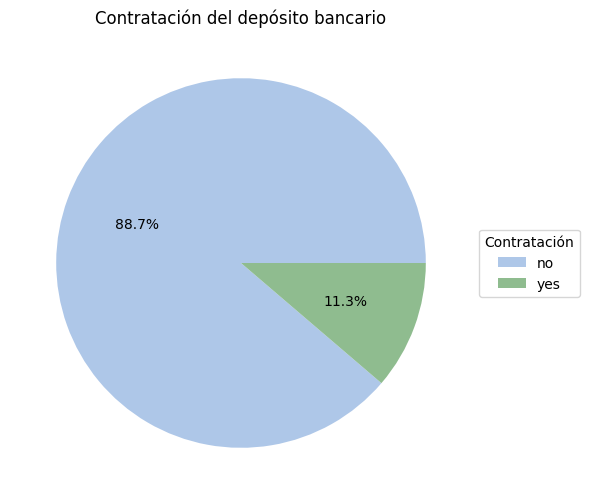

In [340]:
# Visualización de los datos de contrataciones del depósito bancario
plt.figure(figsize=(12, 6))
plt.pie(bank_marketing["y"].value_counts(), autopct='%1.1f%%', colors=colores)
plt.title("Contratación del depósito bancario")

plt.legend(title="Contratación", labels=bank_marketing["y"].unique(), loc="center left", bbox_to_anchor=(1.0, 0.5))

plt.show()

### Datos demográficos: edad, trabajo, educación y estado marital y educación

**Análísis de las datos demográficos**
* **Edad**. Le edad promedio de contratación es de 40 años. No obstante, hay una amplia dispersión, desde una edad mínima de 17 años (indicando la presencia de clientes menores de edad, quienes no pueden contratar el depósito bancario) hasta una edad máxima notable de 92 años.

* **Trabajo**. Al examinar las contrataciones según el tipo de trabajo, destacamos que las posiciones administrativas lideran con un 29.1%, seguidas por los roles técnicos con un 15.7%, y las personas de negocios con un 13.8%. Este panorama revela una notable volatilidad en las preferencias laborales de los clientes. Contrariamente a las expectativas, no se evidencian tendencias claras en las contrataciones relacionadas con niveles salariales; es decir, no se observa que las personas con trabajos mejor remunerados contraten más que aquellas con empleos menos remunerados.
Resulta sorprendente constatar que del total de estudiantes contactados el 31.4% realiza la contratación, así como el 25.2% de los jubilados, quienes alcanzan un 25.2%. 

* **Educación**. Las contrataciones provienen de individuos con un elevado nivel de educación. Un significativo 36% de las contrataciones son de personas con educación universitaria, seguidas por un 22.2% que ha completado la educación secundaria (high school). 

* **Estado marital**. La mayoría de las contrataciones son realizadas por personas casados, representando un 54.6% del total, seguidos de aquellos solteros, con un 34.9%. 

#### Edad

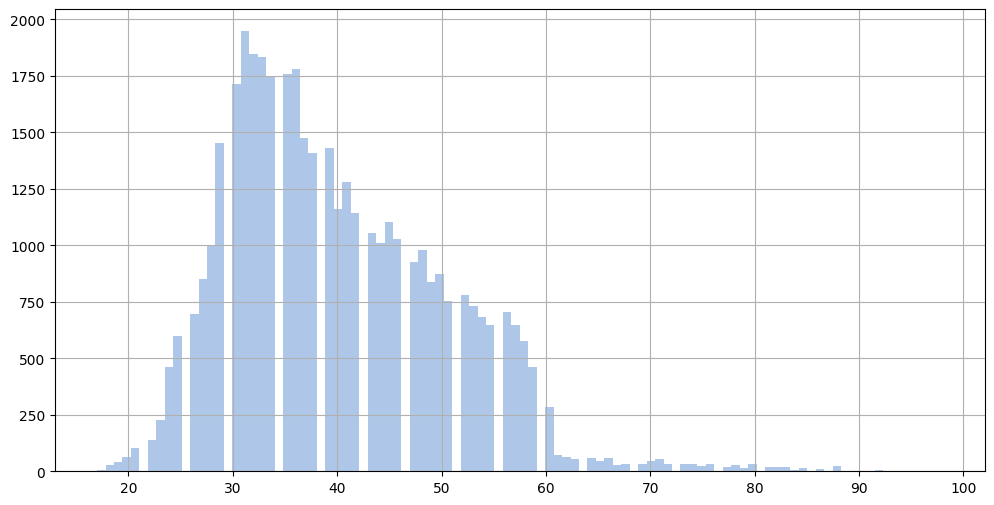

In [341]:
#Histograma de la edad
bank_marketing["age"].hist(bins=100, figsize=(12,6), color=colores[0])
plt.show()

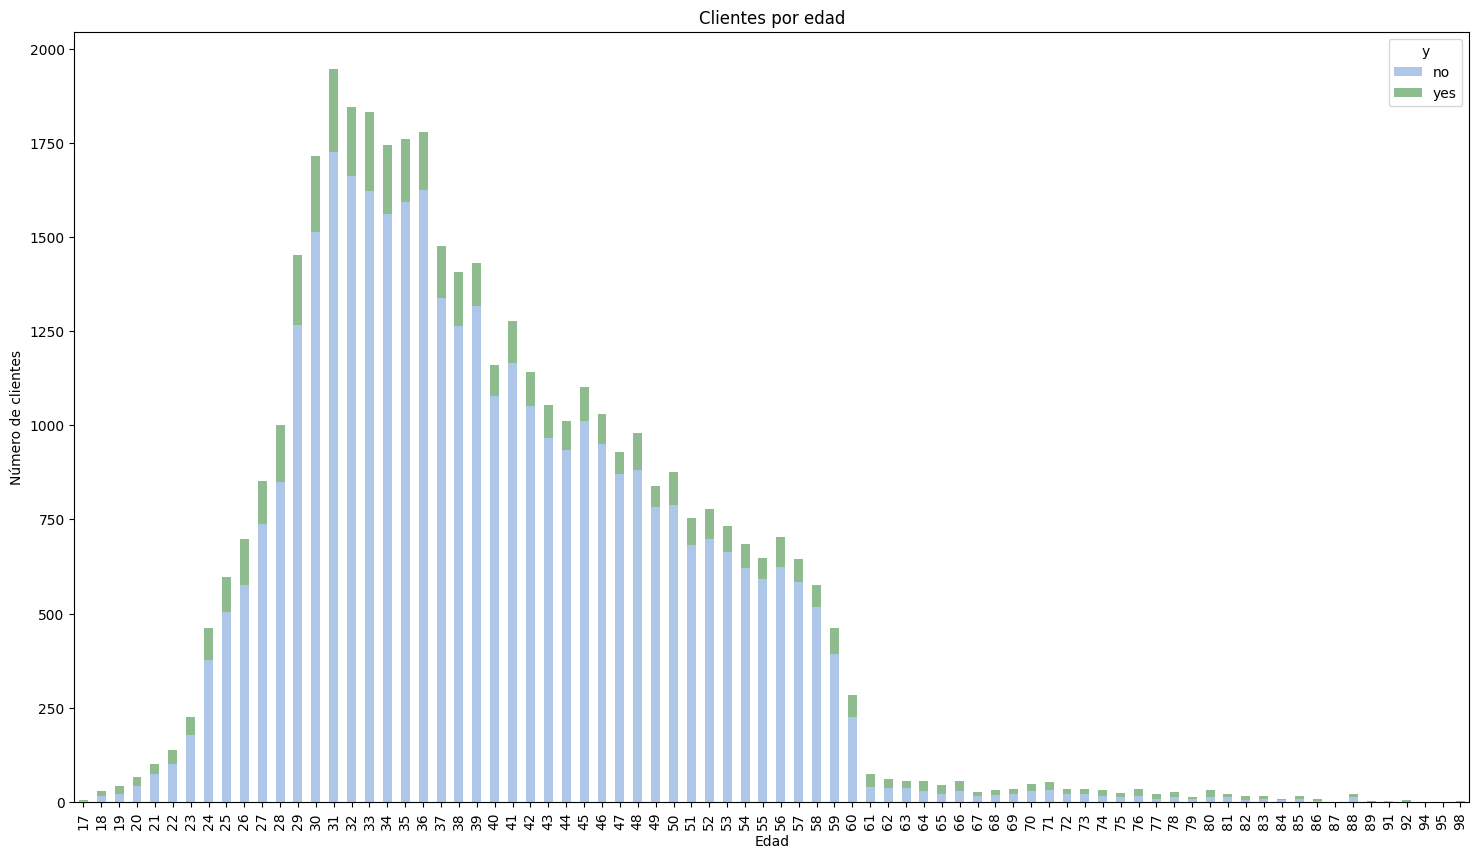

In [342]:
# Número de contrataciones por edad

age_counts = bank_marketing.groupby(['age', 'y']).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(18, 10))
age_counts.plot(kind='bar', stacked=True, ax=ax, color=colores)

ax.set_title('Clientes por edad')
ax.set_xlabel('Edad')
ax.set_ylabel('Número de clientes')

plt.show()



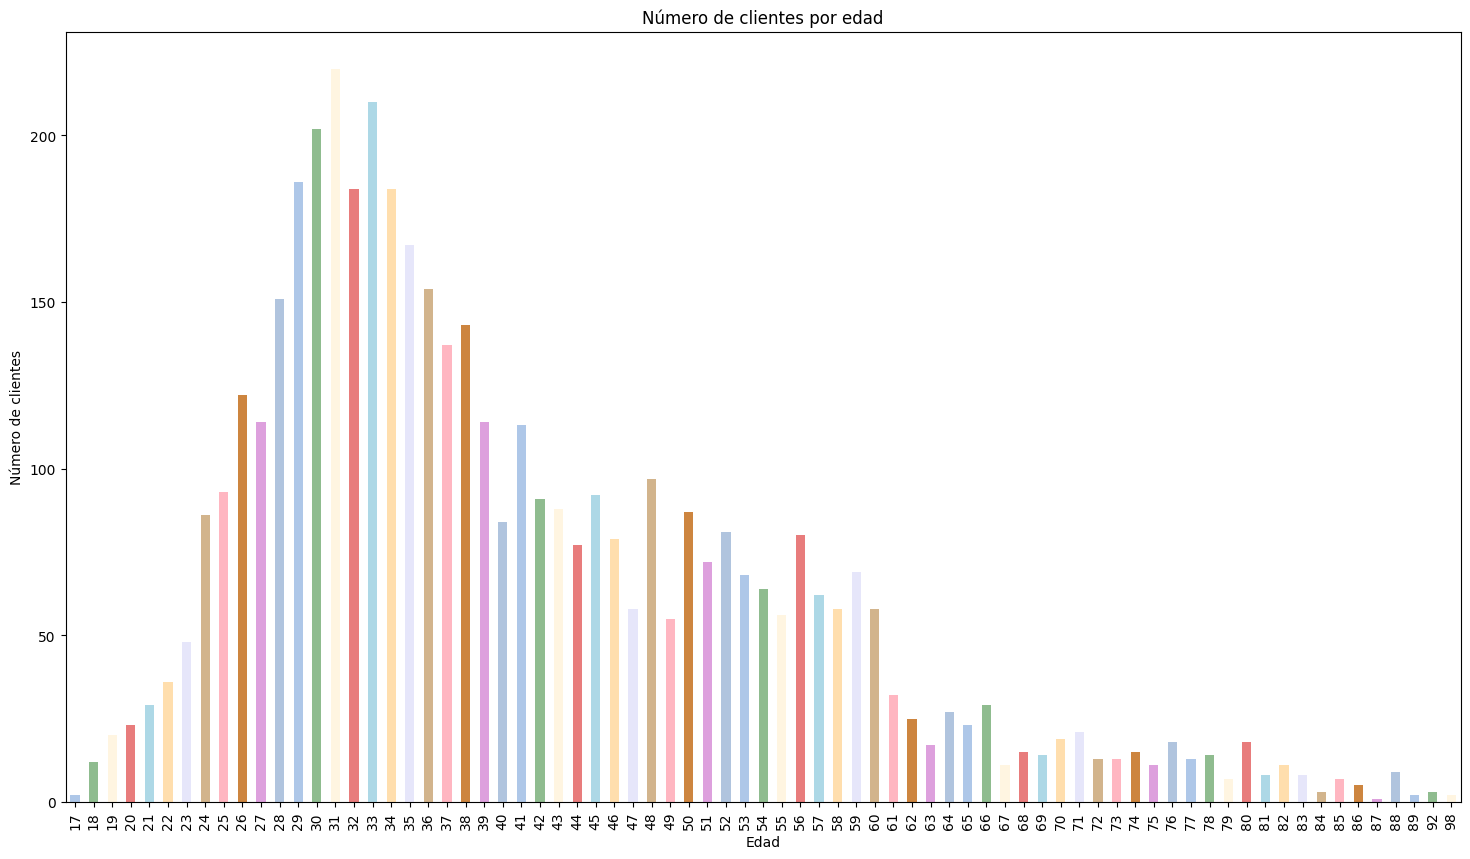

In [343]:
# Número de clientes por edad
contrataciones_edad = bank_marketing[bank_marketing['y'] == 'yes'].groupby('age').size()

fig, ax = plt.subplots(figsize=(18, 10))
contrataciones_edad.plot(kind='bar', stacked=True, ax=ax, color=colores)

ax.set_title('Número de clientes por edad')
ax.set_xlabel('Edad')
ax.set_ylabel('Número de clientes')
plt.show()


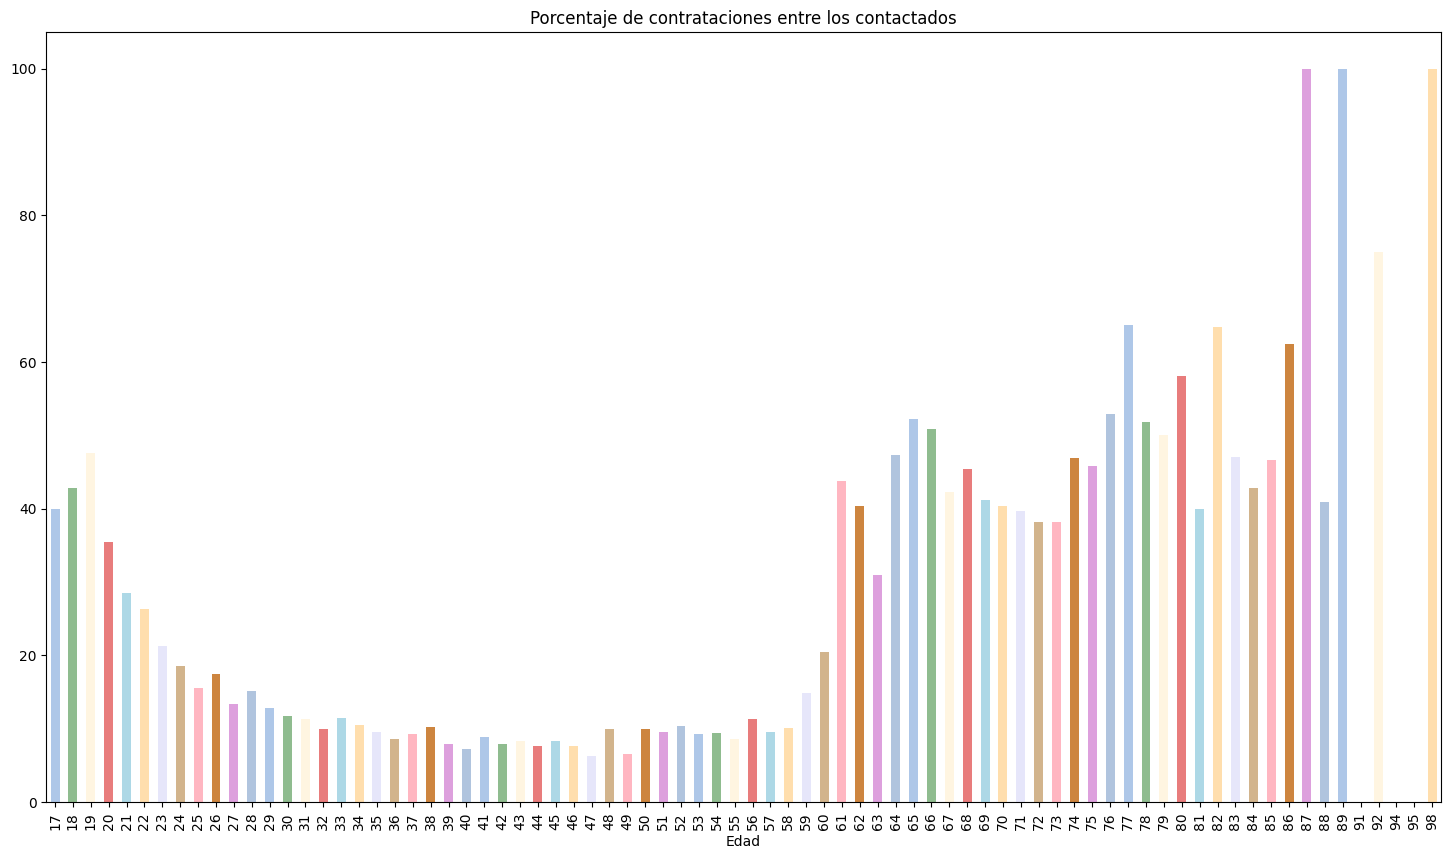

In [344]:
# Porcentaje de contrataciones entre las personas contactadas por edad
contrataciones_edad_porcentaje = bank_marketing[bank_marketing['y'] == 'yes'].groupby('age').size() / bank_marketing.groupby('age').size() * 100

fig, ax = plt.subplots(figsize=(18, 10))
contrataciones_edad_porcentaje.plot(kind='bar', stacked=True, ax=ax, color=colores)

ax.set_title('Porcentaje de contrataciones entre los contactados')
ax.set_xlabel('Edad')
plt.show()

#### Trabajo

Text(0.5, 1.0, 'Contrataciones')

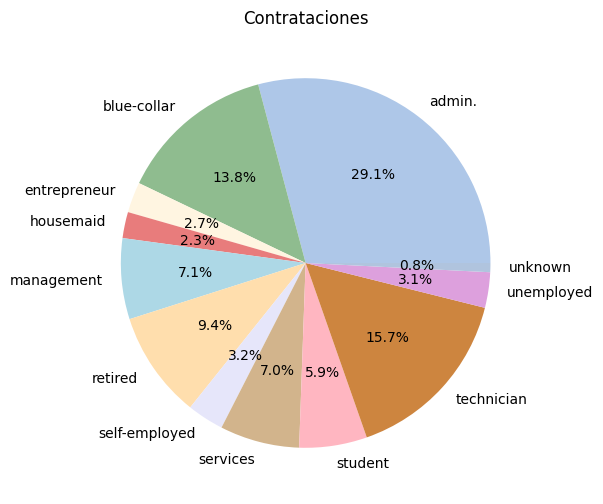

In [345]:
# Contrataciones por tipo de trabajo
contrataciones_job = bank_marketing[bank_marketing['y'] == 'yes'].groupby('job').size()

plt.figure(figsize=(12, 6))
plt.pie(contrataciones_job, labels=contrataciones_job.index, autopct='%1.1f%%', colors=colores)
plt.title("Contrataciones")

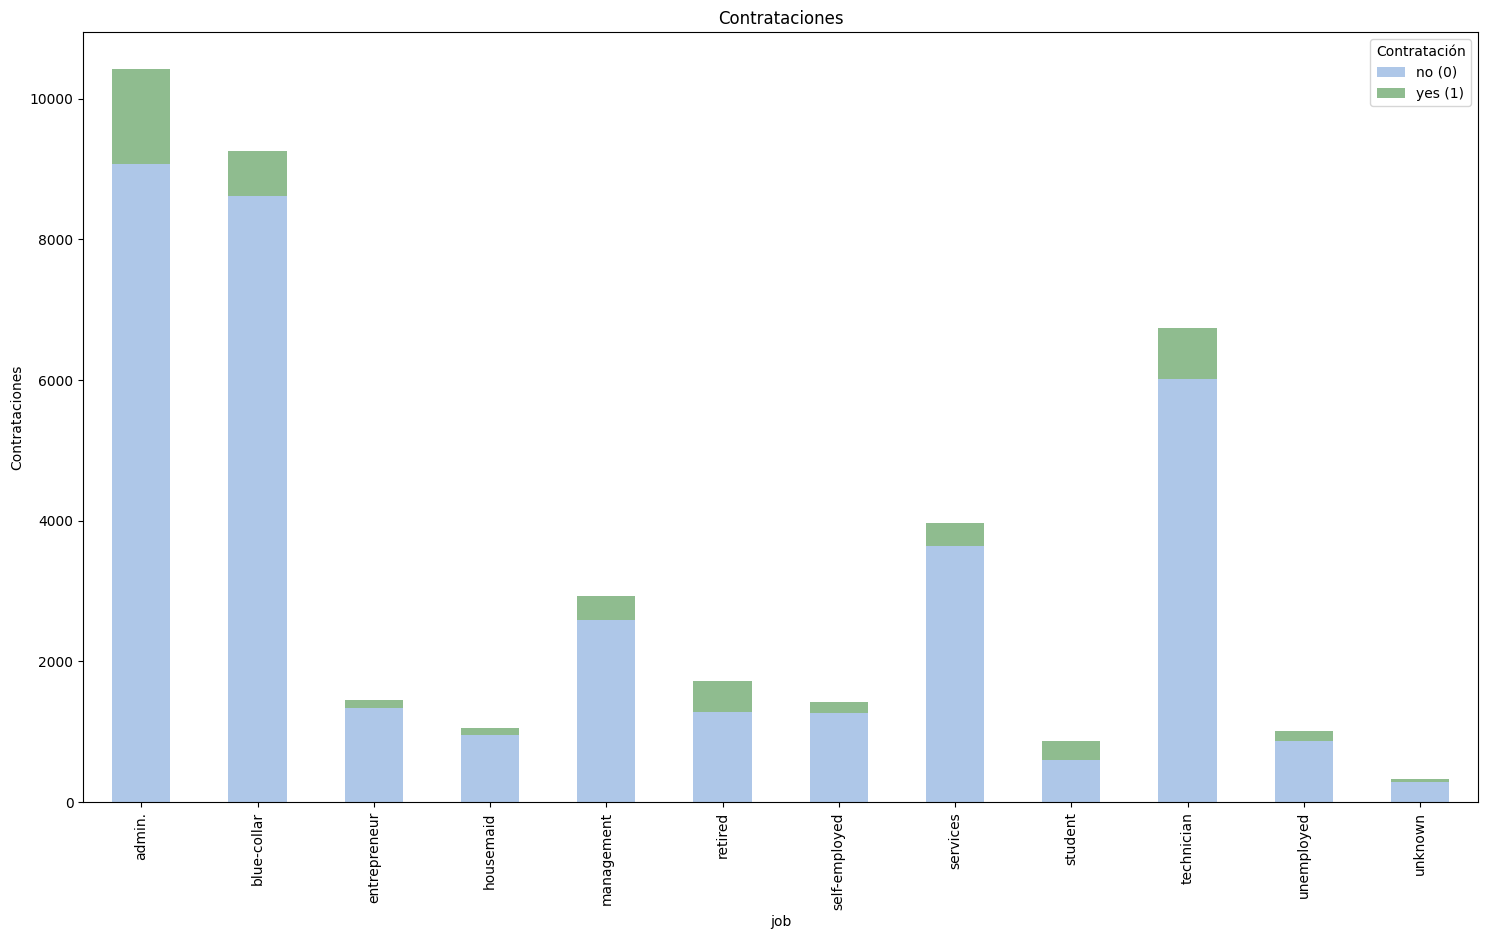

In [346]:
# Contrataciones por trabajos
job_counts = bank_marketing.groupby(['job', 'y']).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(18, 10))
job_counts.plot(kind='bar', stacked=True, ax=ax, color=colores)

ax.set_title('Contrataciones')
ax.set_ylabel('Contrataciones')

labels_y = bank_marketing['y'].unique()

ax.legend(title="Contratación", labels=[f"{label} ({i})" for i, label in enumerate(labels_y)], loc="upper right")

plt.show()


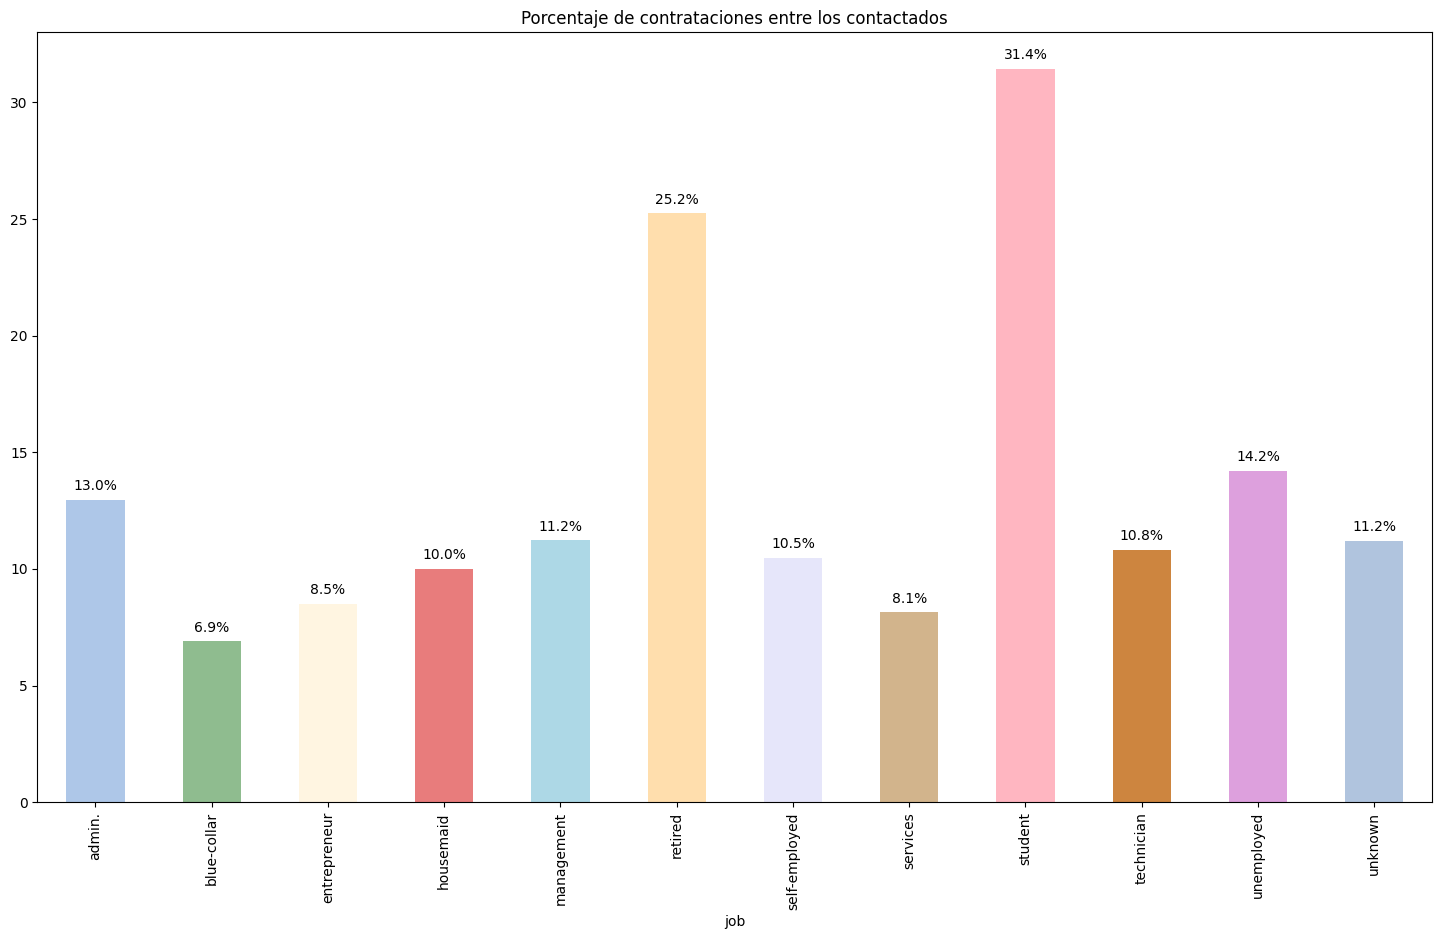

In [347]:
# Porcentaje de contrataciones por tipo de trabajo. 
contrataciones_job_porcentaje = bank_marketing[bank_marketing['y'] == 'yes'].groupby('job').size() / bank_marketing.groupby('job').size() * 100


fig, ax = plt.subplots(figsize=(18, 10))
contrataciones_job_porcentaje.plot(kind='bar', stacked=True, ax=ax, color=colores)

ax.set_title('Porcentaje de contrataciones entre los contactados')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    
plt.show()

#### Educación

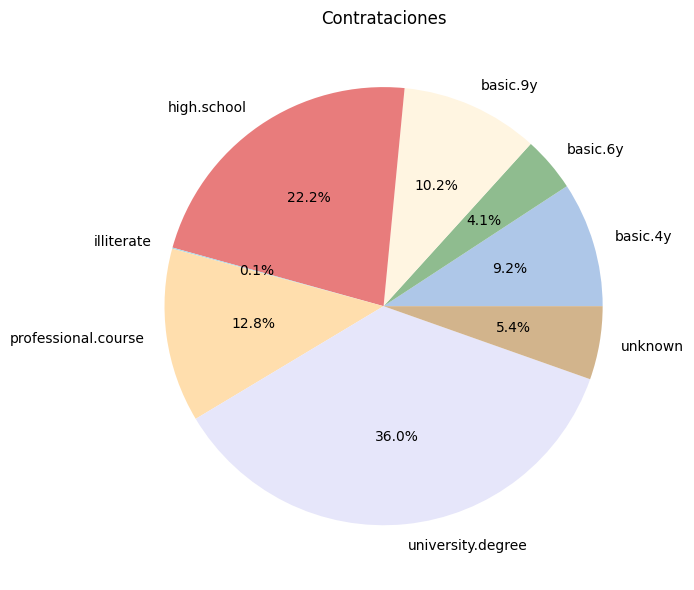

In [348]:
# Contrataciones por nivel académico
contrataciones_education = bank_marketing[bank_marketing['y'] == 'yes'].groupby('education').size()

plt.figure(figsize=(14, 6))
plt.pie(contrataciones_education, labels=contrataciones_education.index, autopct='%1.1f%%', colors=colores)
plt.title("Contrataciones")

plt.tight_layout()
plt.show()

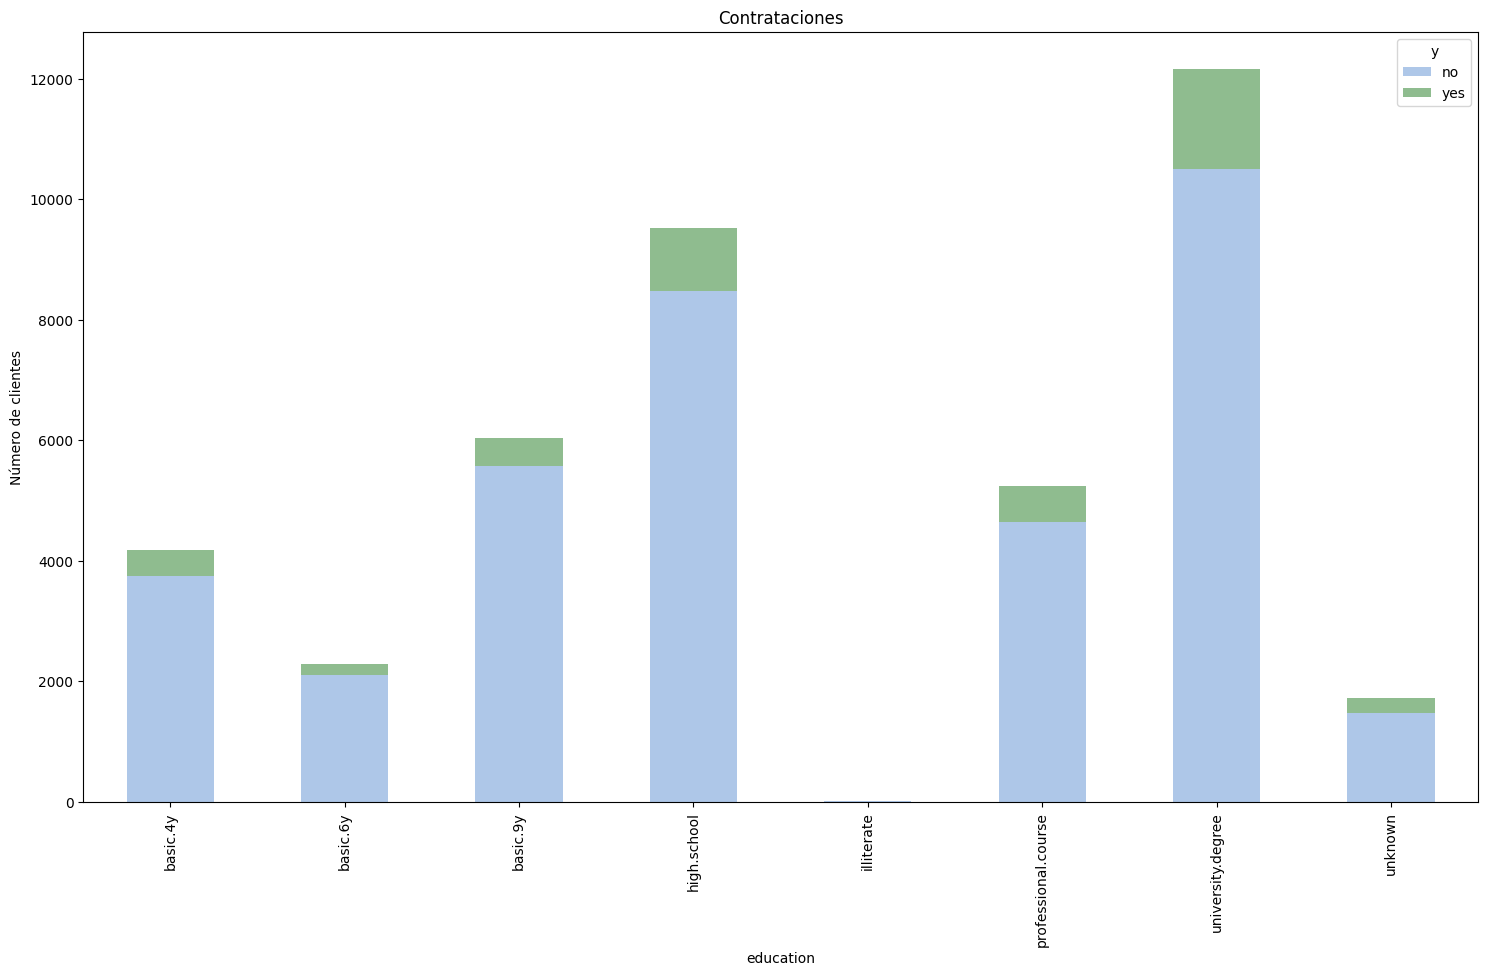

In [349]:
# Contrataciones por nivel académico
education_counts = bank_marketing.groupby(['education', 'y']).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(18, 10))
education_counts.plot(kind='bar', stacked=True, ax=ax, color=colores)

ax.set_title('Contrataciones')
ax.set_ylabel('Número de clientes')

plt.show()

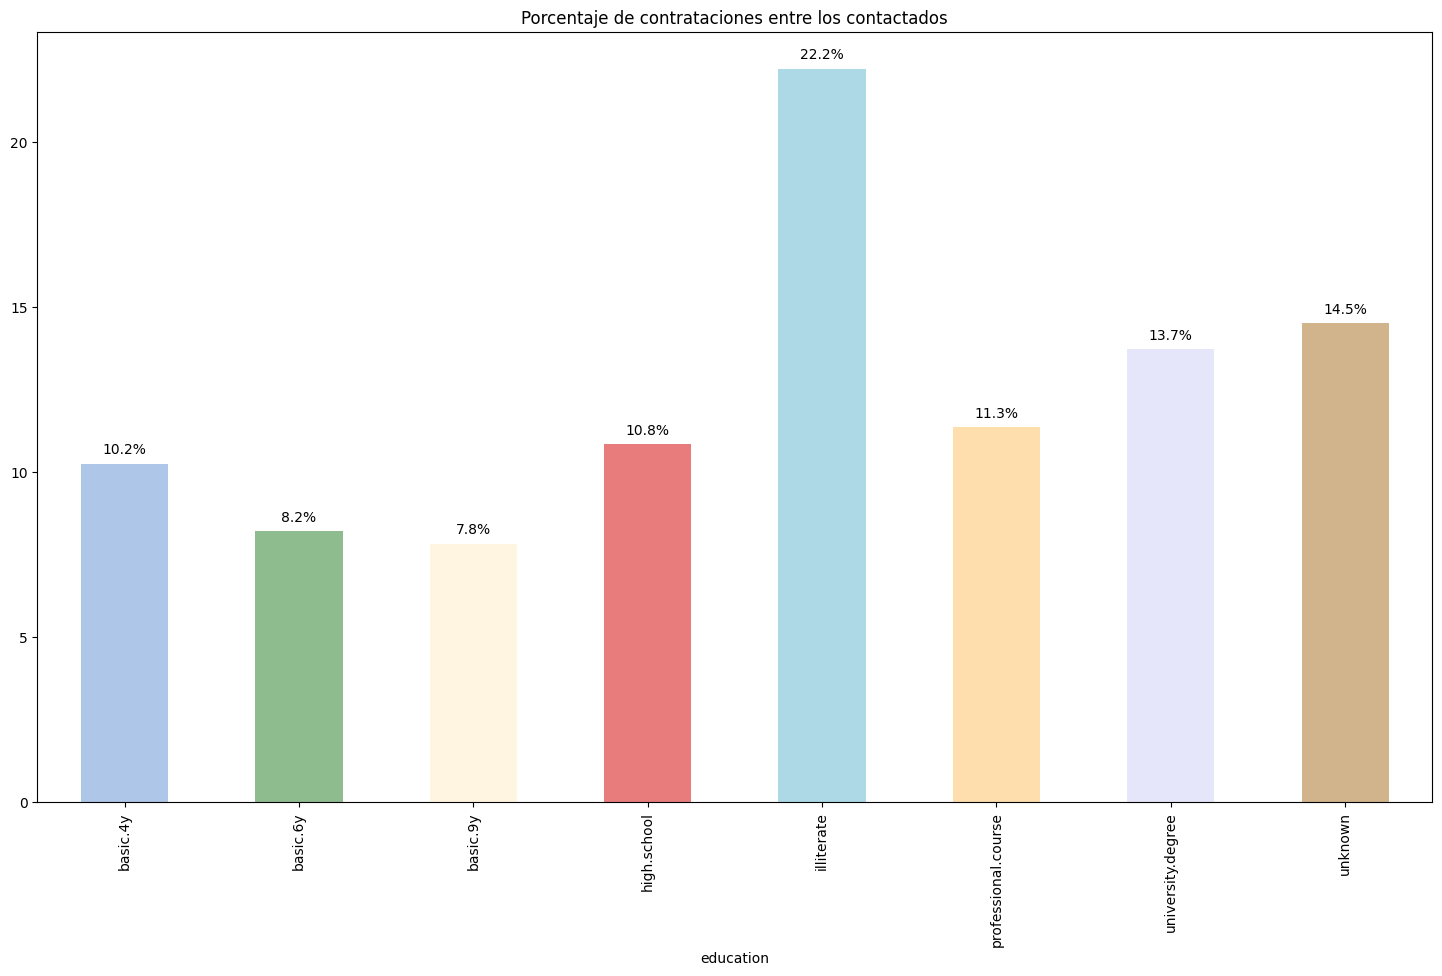

In [350]:
# Porcentaje de contrataciones entre los contactados
contrataciones_education_porcentaje = bank_marketing[bank_marketing['y'] == 'yes'].groupby('education').size() / bank_marketing.groupby('education').size() * 100

fig, ax = plt.subplots(figsize=(18, 10))
contrataciones_education_porcentaje.plot(kind='bar', stacked=True, ax=ax, color=colores)

ax.set_title('Porcentaje de contrataciones entre los contactados')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    
plt.show()

#### Estado marital

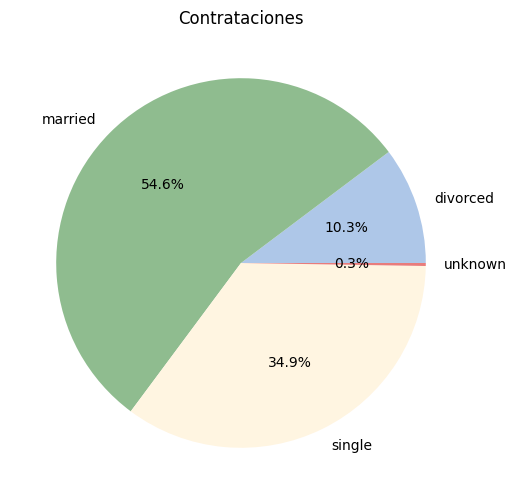

In [351]:
# Contrataciones por estado marital
marital_contrataciones = bank_marketing[bank_marketing['y'] == 'yes'].groupby('marital').size()

plt.figure(figsize=(12, 6))
plt.pie(marital_contrataciones, labels=marital_contrataciones.index, autopct='%1.1f%%', colors=colores)
plt.title("Contrataciones")

plt.show()


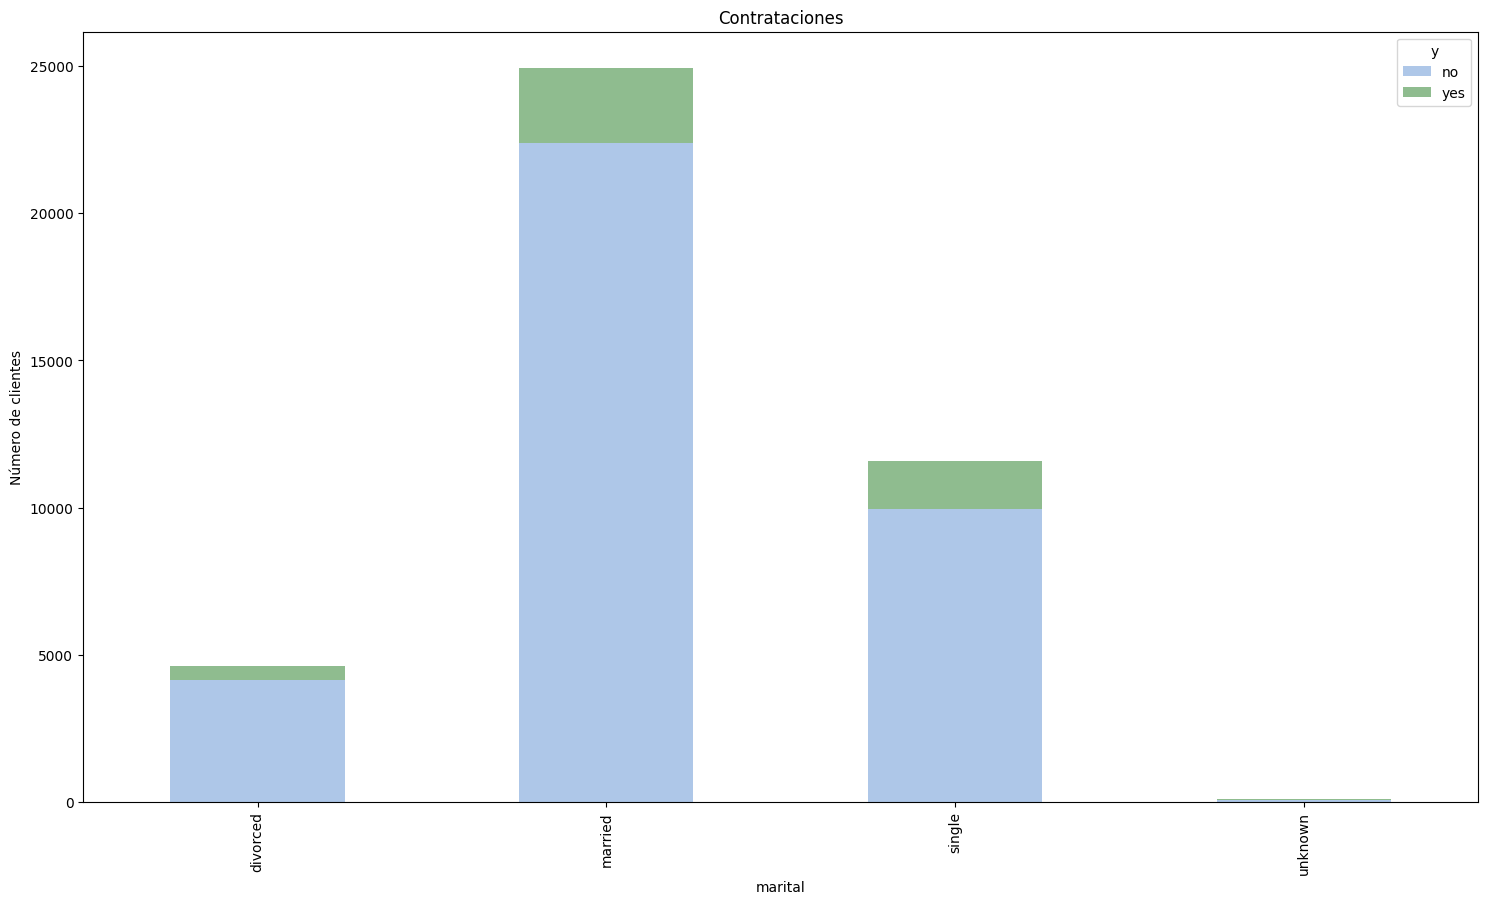

In [352]:
# Contrataciones por estado marital

marital_counts = bank_marketing.groupby(['marital', 'y']).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(18, 10))
marital_counts.plot(kind='bar', stacked=True, ax=ax, color=colores)

ax.set_title('Contrataciones')
ax.set_ylabel('Número de clientes')

plt.show()

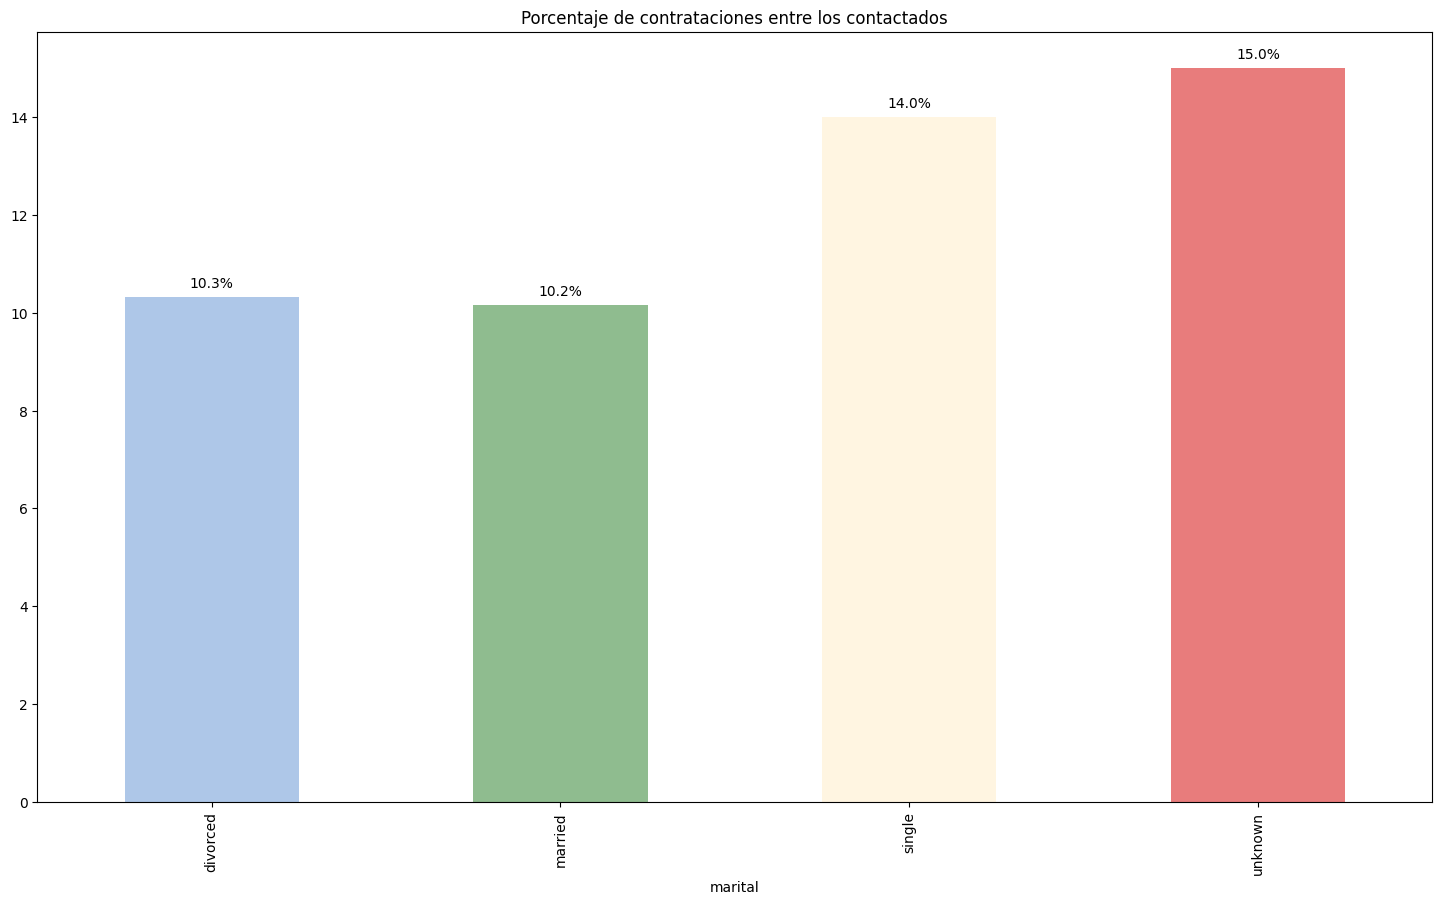

In [353]:
# Porcentaje de contrataciones por estado marital entre las personas contactadas
contrataciones_marital_porcentaje = bank_marketing[bank_marketing['y'] == 'yes'].groupby('marital').size() / bank_marketing.groupby('marital').size() * 100

fig, ax = plt.subplots(figsize=(18, 10))
contrataciones_marital_porcentaje.plot(kind='bar', stacked=True, ax=ax, color=colores)

ax.set_title('Porcentaje de contrataciones entre los contactados')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    
plt.show()

### Estado Financiero: impagos, préstamos del hogar y préstamos personales

**Análisis del estado financiero**

* **Impagos**: El 90.5% de las personas que contratan no presentan impagos, evidenciando un criterio sólido de filtrado por parte del banco. Tan solo 3 de las personas contactadas mostraban historial de impagos. Este primer filtro indica una estrategia eficaz para minimizar riesgos crediticios.

* **Préstamos del hogar**: Destaca que un significativo 54% de las contrataciones provienen de personas que ya poseen préstamos del hogar con el banco. Este patrón sugiere una relación positiva entre la contratación de nuevos productos y la existencia de préstamos previos relacionados con el hogar.

* **Préstamos personales**: La mayoría de los contactos se enfocan en personas que no tienen préstamos personales, representando un 83% de las contrataciones.

#### Impagos

In [354]:
# Balance de datos
bank_marketing['default'].value_counts()

default
no         32588
unknown     8597
yes            3
Name: count, dtype: int64

Text(0.5, 1.0, 'Contrataciones | Personas con impagos')

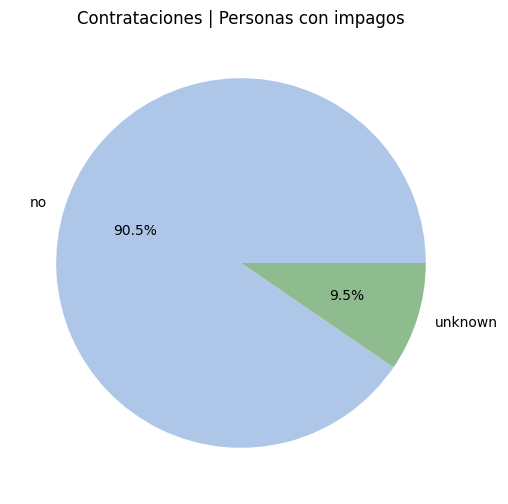

In [355]:
# Proporción de usuarios con contrataciones
contrataciones_default = bank_marketing[bank_marketing['y'] == 'yes'].groupby('default').size()

plt.figure(figsize=(12, 6))
plt.pie(contrataciones_default, labels=contrataciones_default.index, autopct='%1.1f%%', colors=colores)
plt.title("Contrataciones | Personas con impagos")

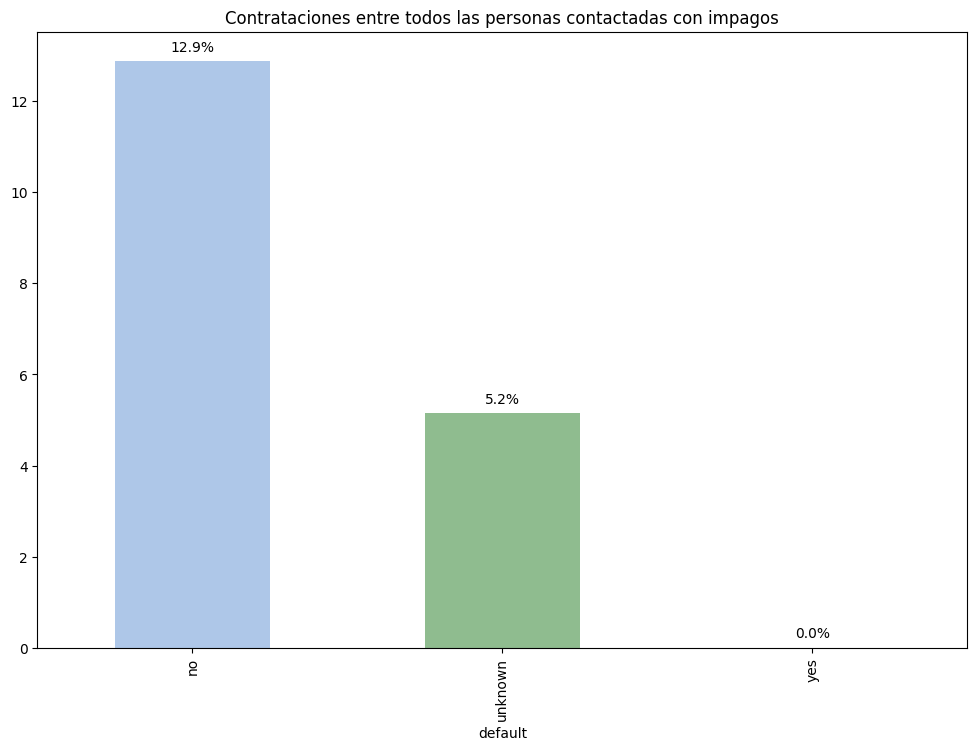

In [356]:
# Porcentaje de contrataciones entre los contactados 
contrataciones_default_porcentaje = bank_marketing[bank_marketing['y'] == 'yes'].groupby('default').size() / bank_marketing.groupby('default').size() * 100

fig, ax = plt.subplots(figsize=(12, 8))
contrataciones_default_porcentaje.plot(kind='bar', stacked=True, ax=ax, color=colores)

ax.set_title('Contrataciones entre todos las personas contactadas con impagos')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    
plt.show()

#### Préstamos del hogar

In [357]:
# Balance de datos
bank_marketing['housing'].value_counts()

housing
yes        21576
no         18622
unknown      990
Name: count, dtype: int64

Text(0.5, 1.0, 'Contrataciones | Personas con préstamo de viviendas')

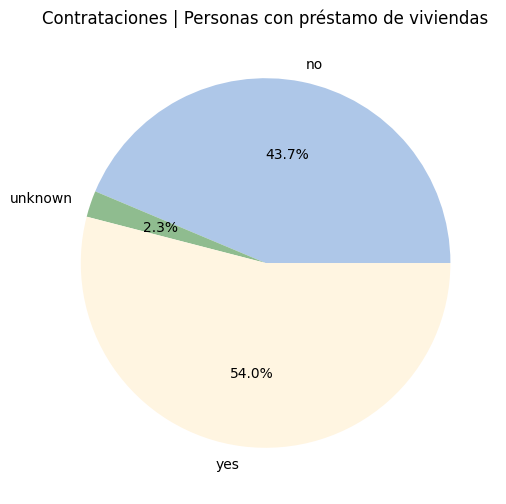

In [358]:
# Proporción de usuarios con contrataciones
contrataciones_housing = bank_marketing[bank_marketing['y'] == 'yes'].groupby('housing').size()

plt.figure(figsize=(12, 6))
plt.pie(contrataciones_housing, labels=contrataciones_housing.index, autopct='%1.1f%%', colors=colores)
plt.title("Contrataciones | Personas con préstamo de viviendas")

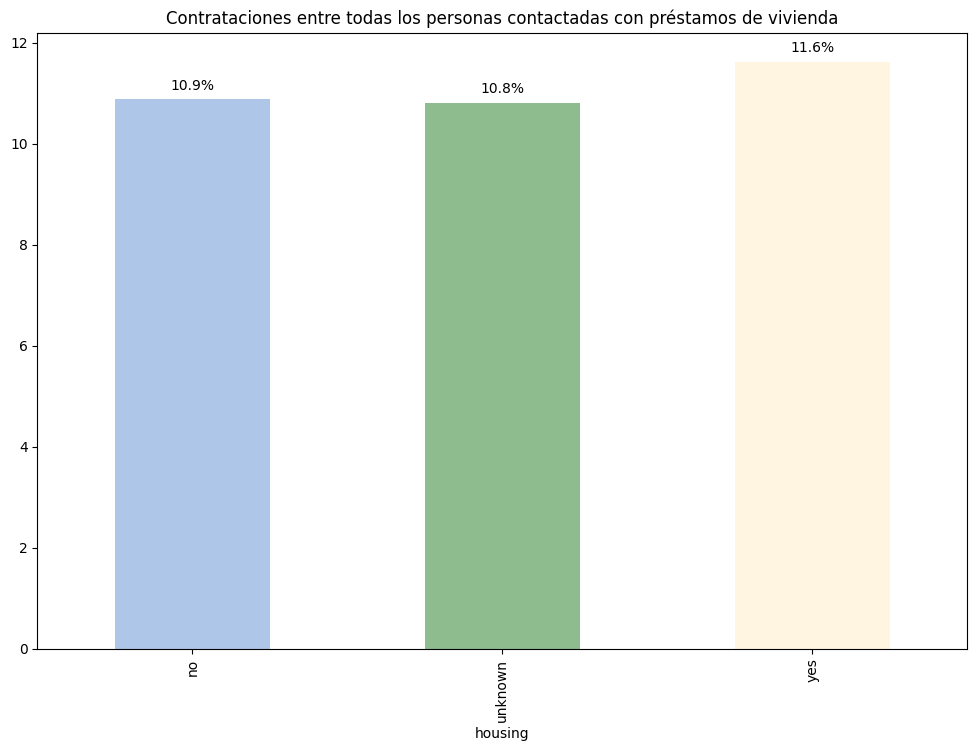

In [359]:
# Porcentaje de contrataciones entre los contactados 
contrataciones_housing_porcentaje = bank_marketing[bank_marketing['y'] == 'yes'].groupby('housing').size() / bank_marketing.groupby('housing').size() * 100

fig, ax = plt.subplots(figsize=(12, 8))
contrataciones_housing_porcentaje.plot(kind='bar', stacked=True, ax=ax, color=colores)

ax.set_title('Contrataciones entre todas los personas contactadas con préstamos de vivienda')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    
plt.show()

#### Préstamos personales

In [360]:
# Balance de datos
bank_marketing['loan'].value_counts()

loan
no         33950
yes         6248
unknown      990
Name: count, dtype: int64

Text(0.5, 1.0, 'Contrataciones | Personas con préstamo personal')

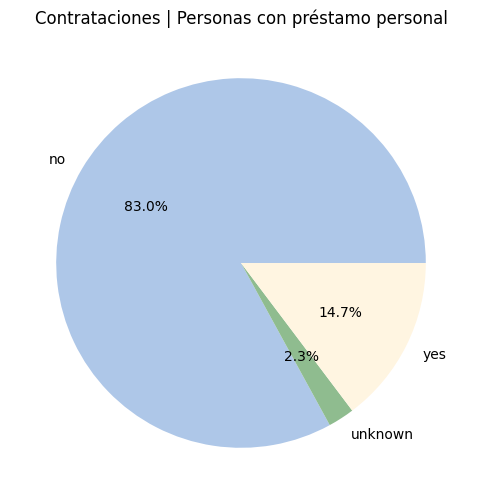

In [361]:
# Proporción de usuarios con contrataciones
contrataciones_loan = bank_marketing[bank_marketing['y'] == 'yes'].groupby('loan').size()

plt.figure(figsize=(12, 6))
plt.pie(contrataciones_loan, labels=contrataciones_loan.index, autopct='%1.1f%%', colors=colores)
plt.title("Contrataciones | Personas con préstamo personal")

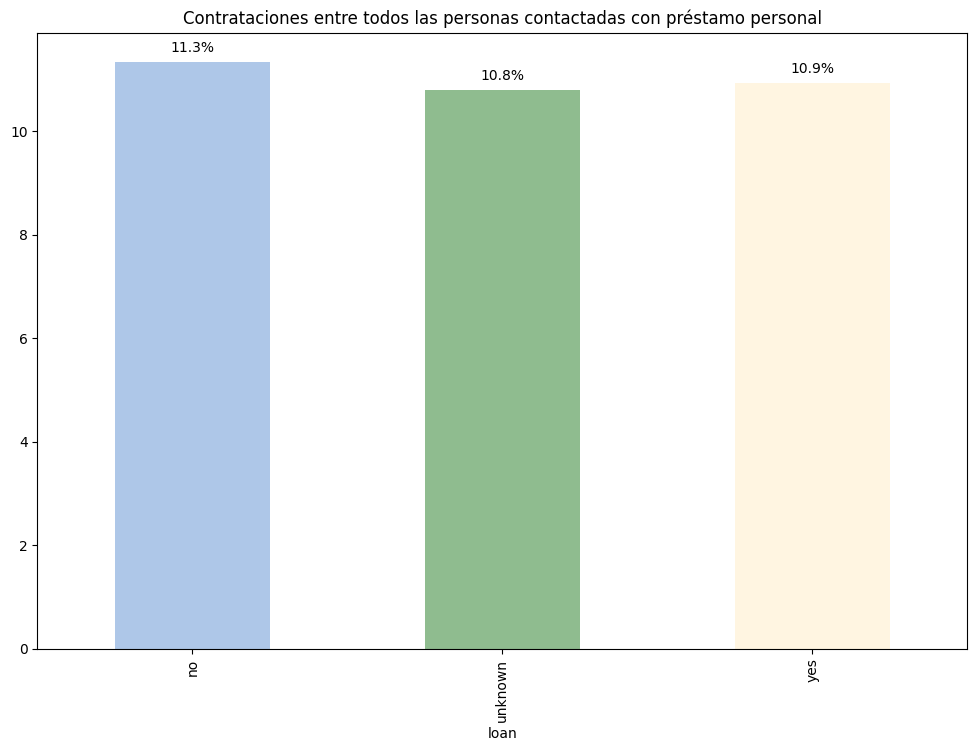

In [362]:
# Porcentaje de contrataciones entre los contactados 
contrataciones_loan_porcentaje = bank_marketing[bank_marketing['y'] == 'yes'].groupby('loan').size() / bank_marketing.groupby('loan').size() * 100

fig, ax = plt.subplots(figsize=(12, 8))
contrataciones_loan_porcentaje.plot(kind='bar', stacked=True, ax=ax, color=colores)

ax.set_title('Contrataciones entre todos las personas contactadas con préstamo personal')
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    
plt.show()

### Contacto de la campaña anterior: dispositivo del usuario, mes, día de la semana, número de contactos, campaña anterior. 

**Análisis del tipo de contacto de la campaña anterior**

* **Tipo de dipositivo del usuario**: Predominantemente, el 83% de las contrataciones se llevaron a cabo a través de dispositivos móviles, señalando una preferencia marcada por la interacción desde estos dispositivos.

* **Mes**: No se observa un mes que destaque sobre los demás en términos de contrataciones. La distribución de las contrataciones se mantiene bastante equitativa a lo largo de los diferentes meses.

* **Día de la semana**: Similar a la distribución mensual, no hay un día de la semana que sobresalga en términos de contrataciones. La actividad de contrataciones se distribuye uniformemente a lo largo de los días de la semana.

* **Duración**:  La mayoría de las llamadas tienen una duración de 2 a 4 minutos, siendo 4 minutos el intervalo más común para las contrataciones. Sin embargo, es notable que a partir de los 12 minutos, el porcentaje de contrataciones entre las personas contactadas experimenta un aumento considerable. Este hallazgo sugiere que las interacciones más extensas pueden tener un impacto positivo en la toma de decisiones del cliente durante la campaña.

* **Número de contactos**: Se observa que el 49.6% de las contrataciones se llevaron a cabo con un solo contacto, mientras que el 26.1% ocurrieron después de dos contactos, y el 12.4% después de tres. Resulta interesante notar que a medida que aumenta el número de contactos, disminuye el porcentaje de contrataciones. Este patrón sugiere la importancia de la eficacia en la primera o segunda interacción, ya que la tasa de contratación tiende a decrecer con cada contacto adicional.

* **Campaña anterior**: La mayoría de las contrataciones provienen de personas que no fueron contactadas en la campaña anterior, representando un 67.7%. Por otro lado, el 19.3% de las contrataciones se realizaron con individuos que ya habían sido contactados en la campaña previa y que, a pesar de ello, decidieron contratar en esta ocasión.

#### Dispositivo del usuario

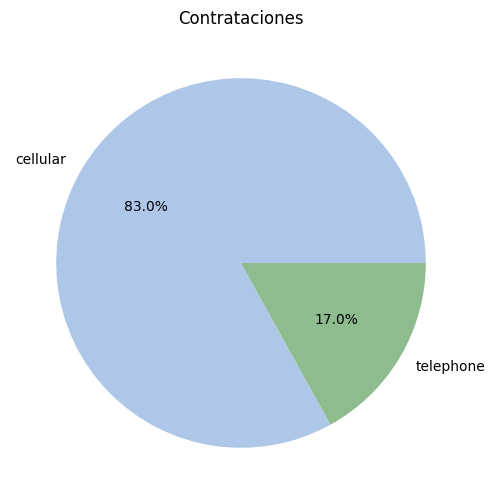

In [363]:
# Contrataciones por tipo de dispositivo
contact_contrataciones = bank_marketing[bank_marketing["y"] == 'yes'].groupby("contact").size()

plt.figure(figsize=(12, 6))
plt.pie(contact_contrataciones, labels=contact_contrataciones.index, autopct='%1.1f%%', colors=colores)
plt.title("Contrataciones")

plt.show()

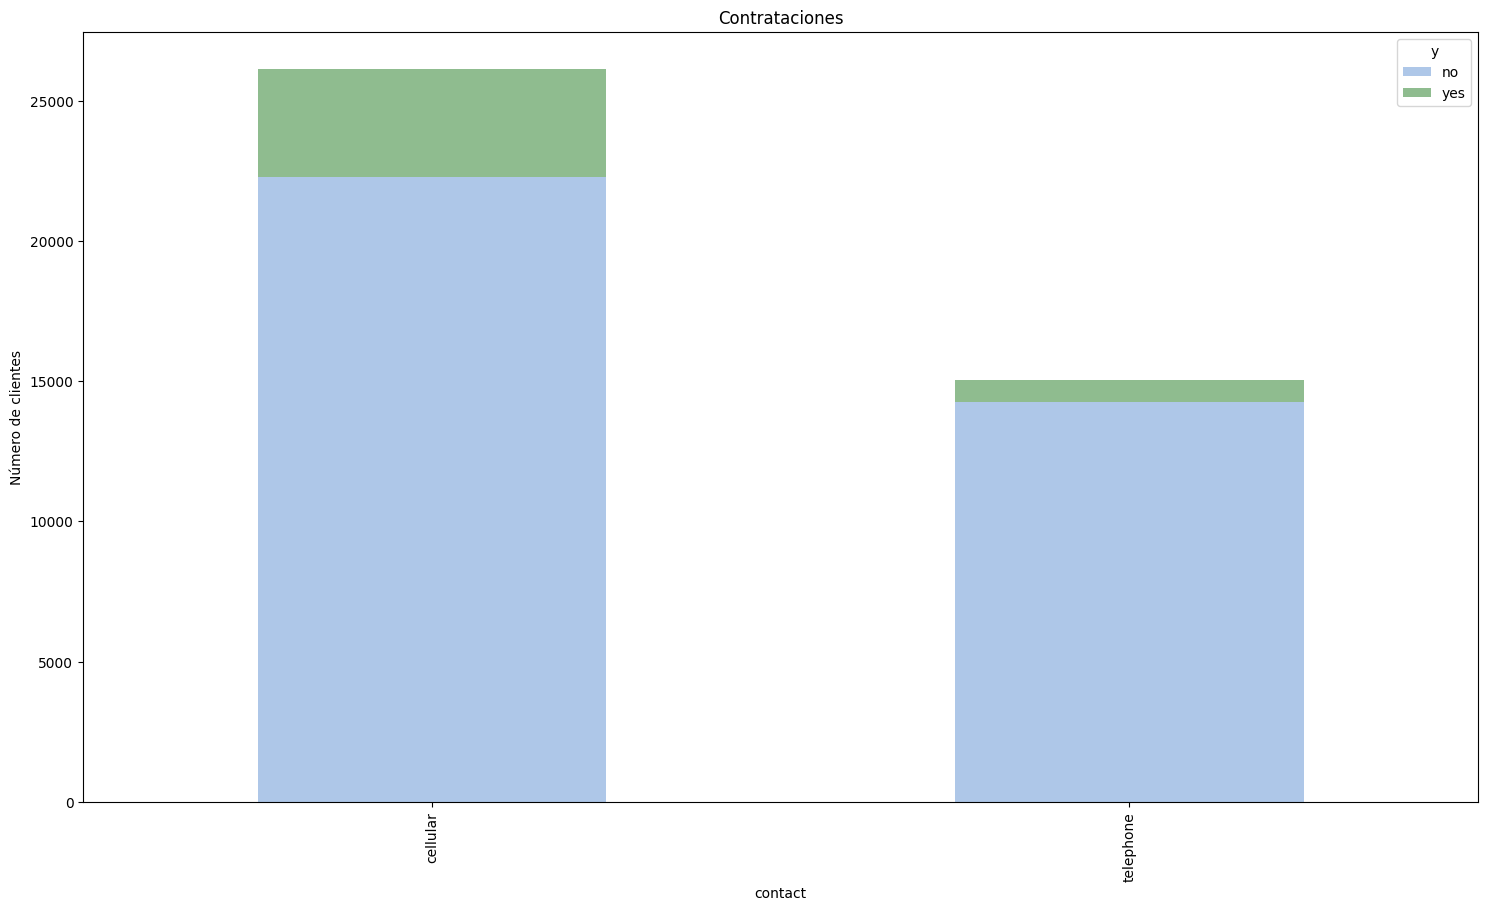

In [364]:
# Contrataciones por tipo de dispositivo

contact_counts = bank_marketing.groupby(['contact', 'y']).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(18, 10))
contact_counts.plot(kind='bar', stacked=True, ax=ax, color=colores)

ax.set_title('Contrataciones')
ax.set_ylabel('Número de clientes')

plt.show()

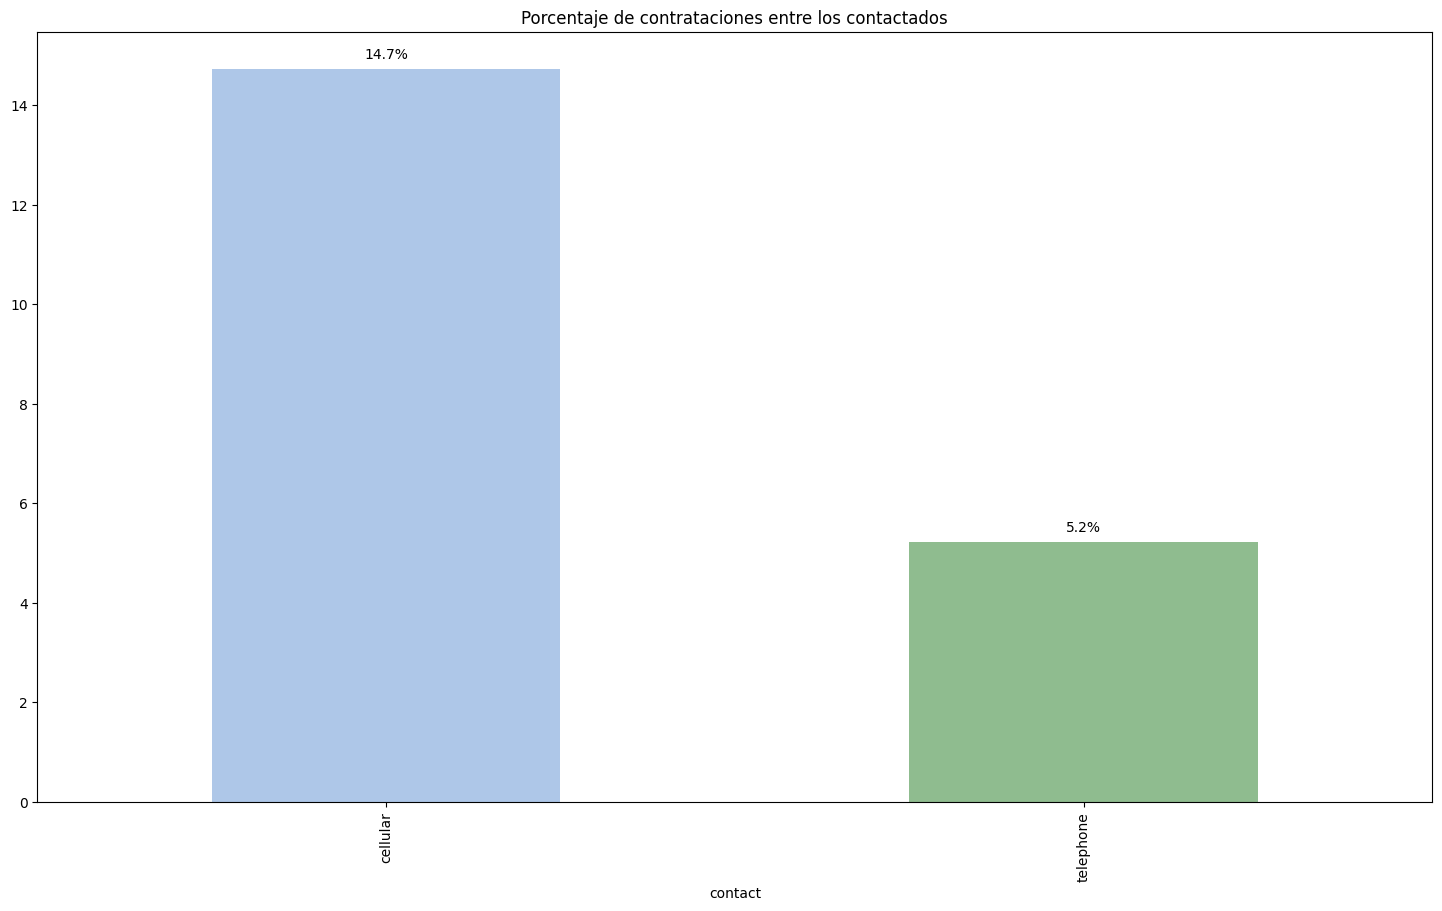

In [365]:
# Porcentaje de contrataciones entre el tipo de dispositivo

contrataciones_contactos_porcentaje = bank_marketing[bank_marketing['y'] == 'yes'].groupby('contact').size() / bank_marketing.groupby('contact').size() * 100

fig, ax = plt.subplots(figsize=(18, 10))
contrataciones_contactos_porcentaje.plot(kind='bar', stacked=True, ax=ax, color=colores)

ax.set_title('Porcentaje de contrataciones entre los contactados')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    
plt.show()

#### Mes

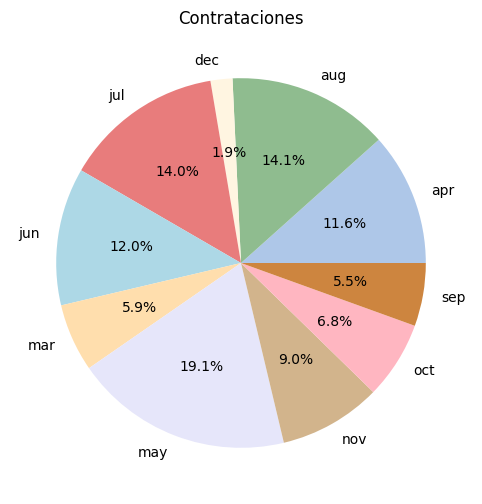

In [366]:
# Contrataciones por tipo de dispositivo

month_contrataciones = bank_marketing[bank_marketing["y"] == 'yes'].groupby("month").size()

plt.figure(figsize=(12, 6))
plt.pie(month_contrataciones, labels=month_contrataciones.index, autopct='%1.1f%%', colors=colores)
plt.title("Contrataciones")

plt.show()



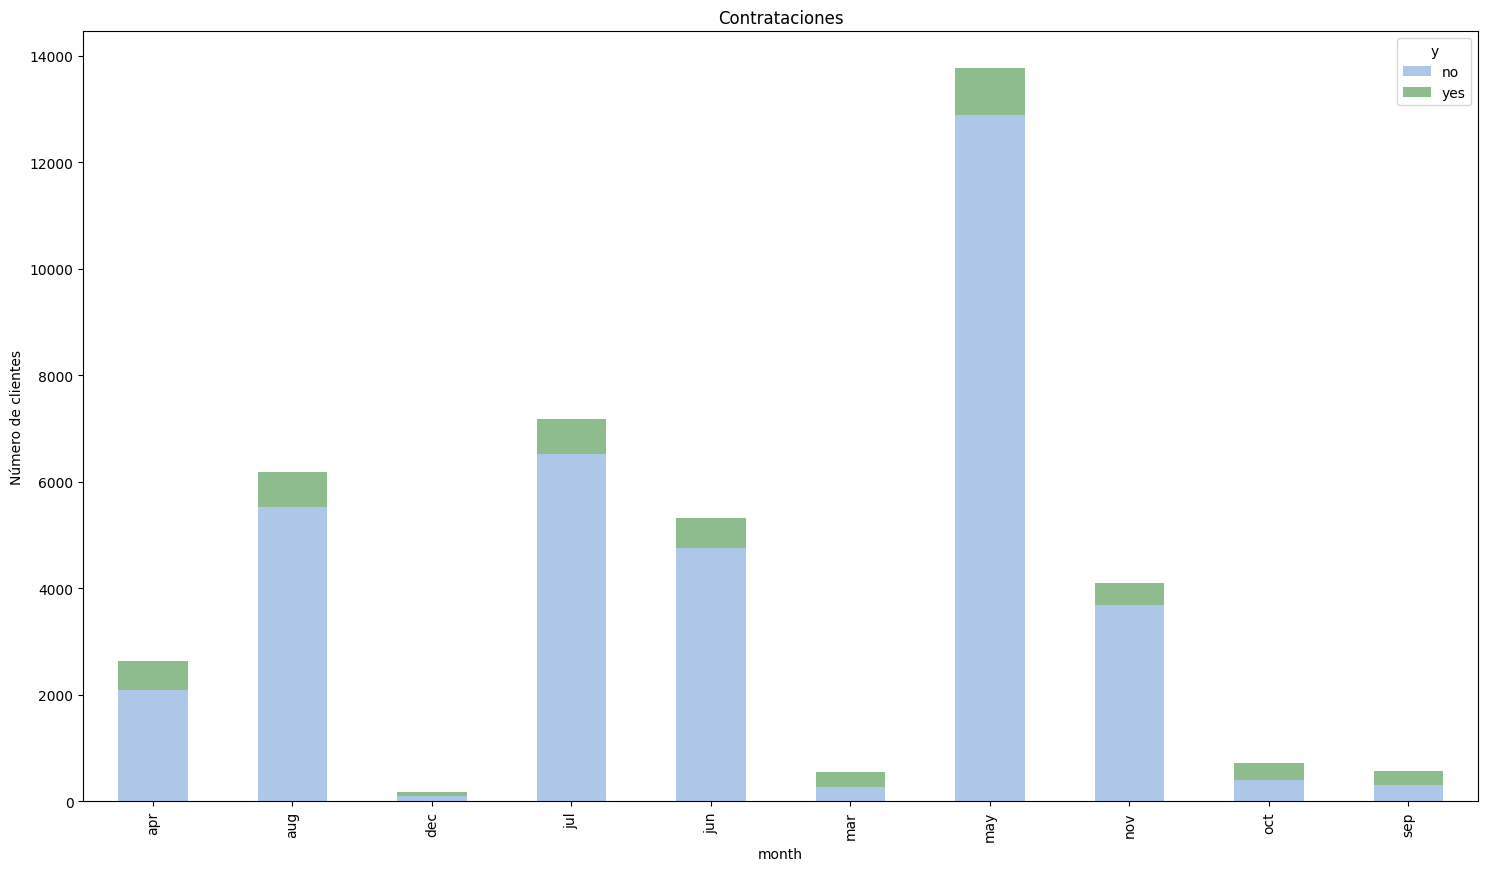

In [367]:
# Contrataciones por tipo de dispositivo

month_counts = bank_marketing.groupby(['month', 'y']).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(18, 10))
month_counts.plot(kind='bar', stacked=True, ax=ax, color=colores)

ax.set_title('Contrataciones')
ax.set_ylabel('Número de clientes')

plt.show()

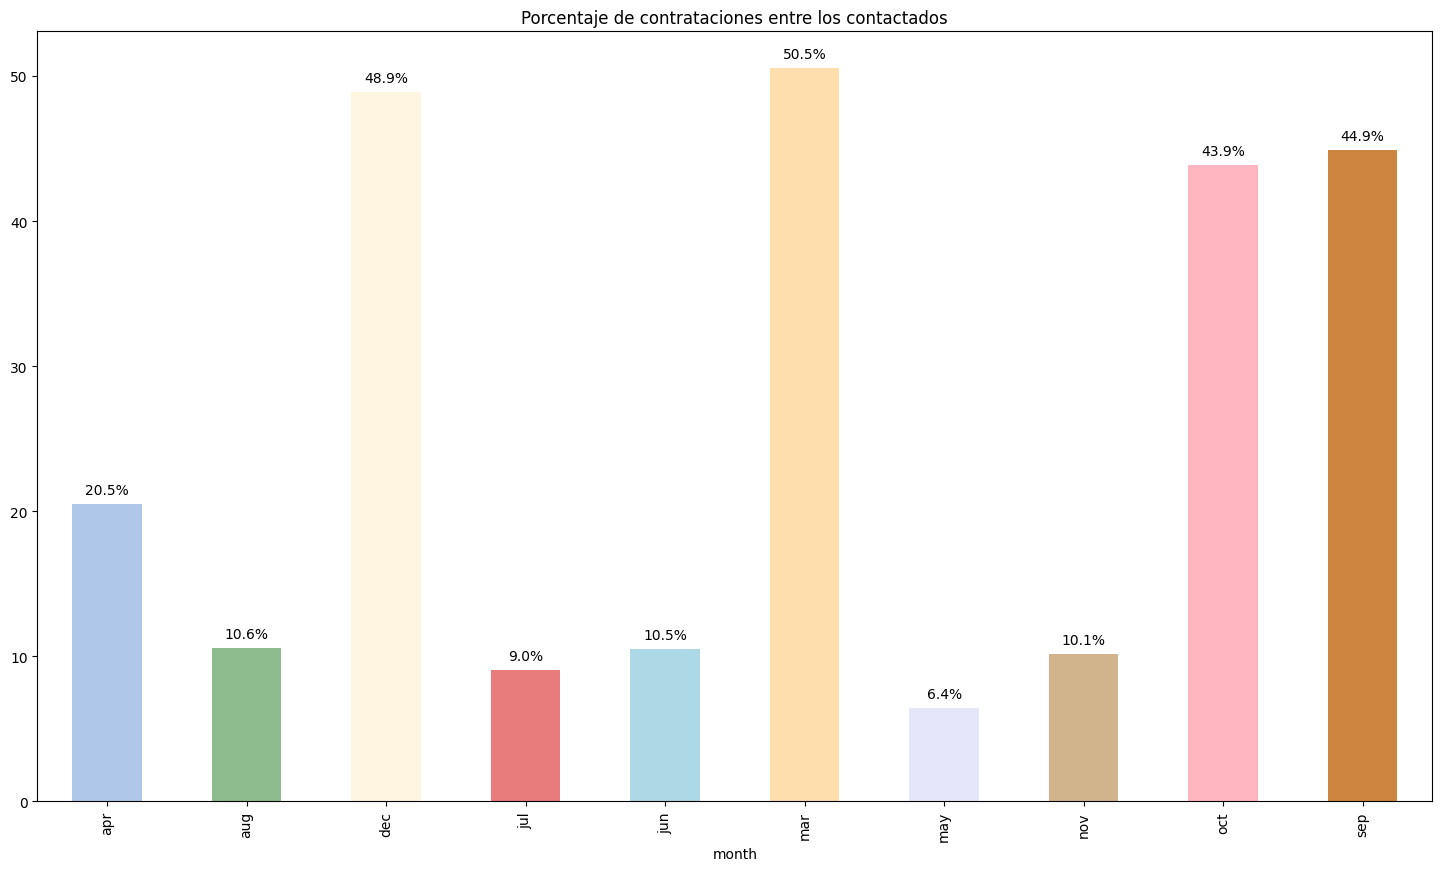

In [368]:
# Porcentaje de contrataciones entre las personas contactadas

contrataciones_month_porcentaje = bank_marketing[bank_marketing['y'] == 'yes'].groupby('month').size() / bank_marketing.groupby('month').size() * 100

fig, ax = plt.subplots(figsize=(18, 10))
contrataciones_month_porcentaje.plot(kind='bar', stacked=True, ax=ax, color=colores)

ax.set_title('Porcentaje de contrataciones entre los contactados')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    
plt.show()

#### Día de la semana

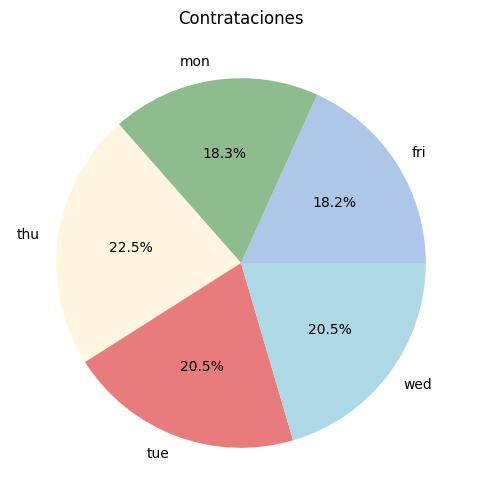

In [369]:
# Contrataciones por día de la semana
day_contrataciones = bank_marketing[bank_marketing["y"] == 'yes'].groupby("day_of_week").size()

plt.figure(figsize=(12, 6))
plt.pie(day_contrataciones, labels=day_contrataciones.index, autopct='%1.1f%%', colors=colores)
plt.title("Contrataciones")

plt.show()

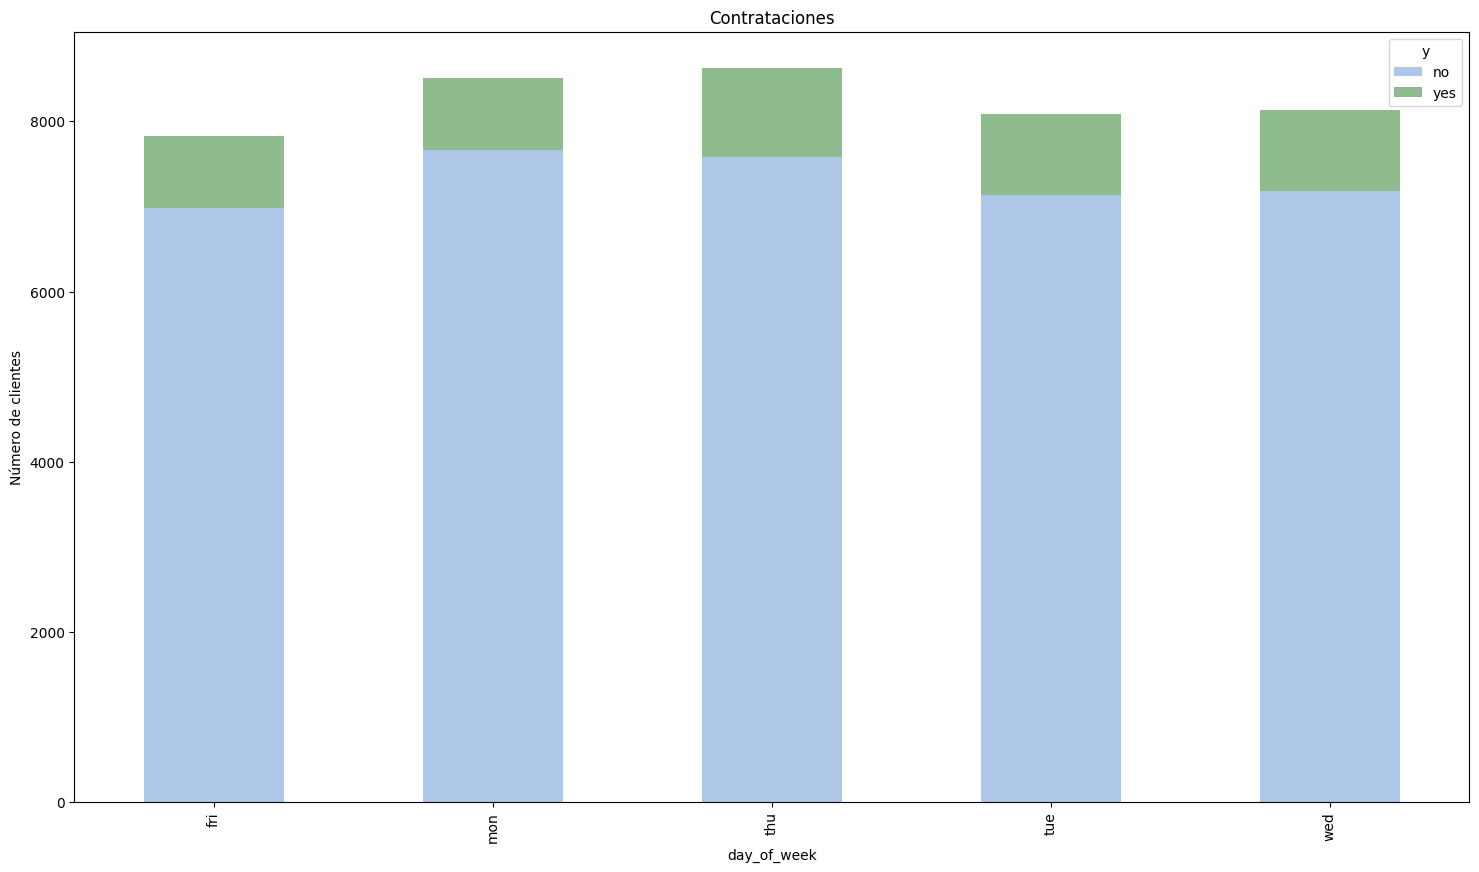

In [370]:
# Contrataciones por día de la semana
day_counts = bank_marketing.groupby(['day_of_week', 'y']).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(18, 10))
day_counts.plot(kind='bar', stacked=True, ax=ax, color=colores)

ax.set_title('Contrataciones')
ax.set_ylabel('Número de clientes')

plt.show()

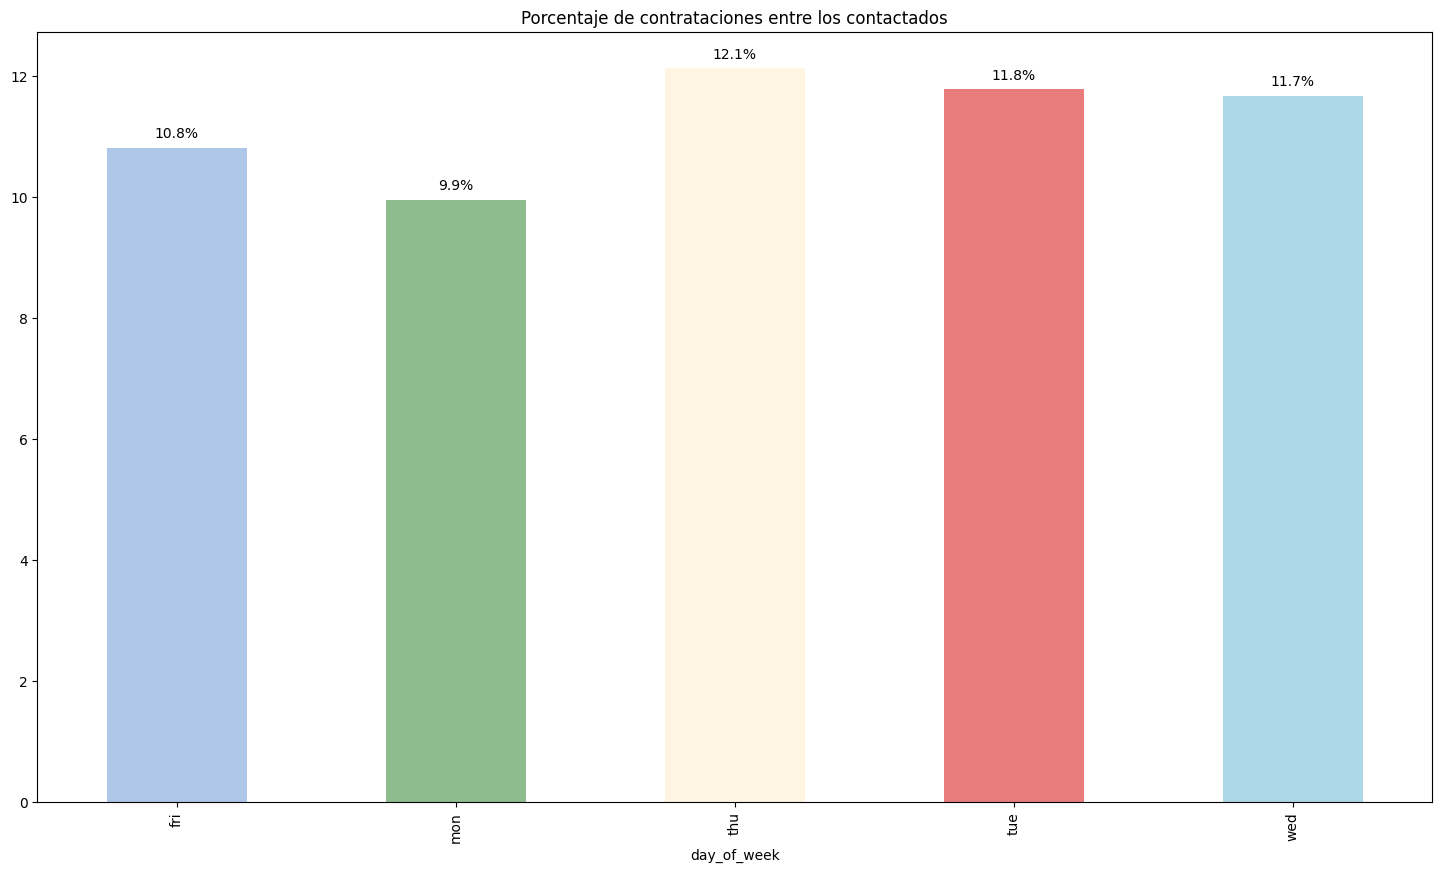

In [371]:
# Porcentaje de contrataciones por día de la semana por el total de contactados
contrataciones_day_porcentaje = bank_marketing[bank_marketing['y'] == 'yes'].groupby('day_of_week').size() / bank_marketing.groupby('day_of_week').size() * 100

fig, ax = plt.subplots(figsize=(18, 10))
contrataciones_day_porcentaje.plot(kind='bar', stacked=True, ax=ax, color=colores)

ax.set_title('Porcentaje de contrataciones entre los contactados')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    
plt.show()

#### Duración de la llamada

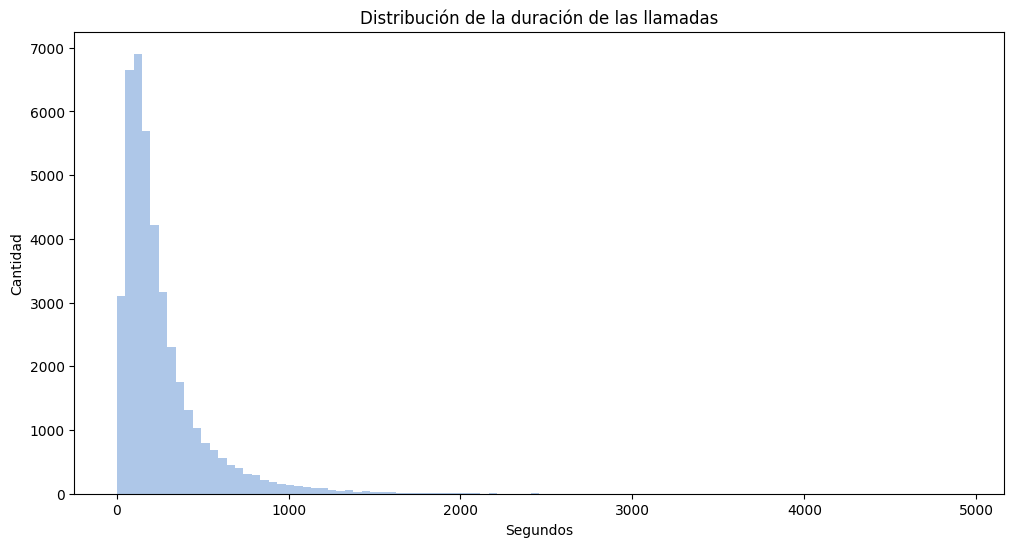

In [372]:
# Balance de las llamadas
duration_counts = bank_marketing["duration"]

plt.figure(figsize=(12, 6))
plt.hist(duration_counts, bins=100, color=colores[0])
plt.xlabel("Segundos")  
plt.ylabel("Cantidad")  
plt.title("Distribución de la duración de las llamadas")
plt.show()

In [373]:
#Crear una columna con intervalos de duración para hacer una mejor lectura
max_valor = 4918
intervalos = [0, 60, 120, 180, 240, 300, 360, 420, 480, 540, 
              600, 660, 720, 780, 840, 900, 960, 1020, 1080, 1140, 1200,  max_valor]
etiquetas = ['1min', '2min', '3min', '4min', '5min', '6min', '7min', '8min', '9min', '10min', '11min', '12min', '13min', '14min', '15min', '16min', '17min', '18min', '19min', '20min', 'Más de 20min']
# Crear una nueva columna 'duration_interval' con los intervalos
bank_marketing['duration_interval'] = pd.cut(bank_marketing['duration'], bins=intervalos, labels=etiquetas, right=False)


In [374]:
bank_marketing["duration_interval"].value_counts()

duration_interval
2min            8614
3min            7793
4min            5505
1min            4181
5min            3845
6min            2680
7min            1920
8min            1341
9min            1025
10min            806
11min            662
12min            515
Más de 20min     514
13min            411
14min            347
15min            259
16min            209
17min            170
18min            146
19min            134
20min            110
Name: count, dtype: int64

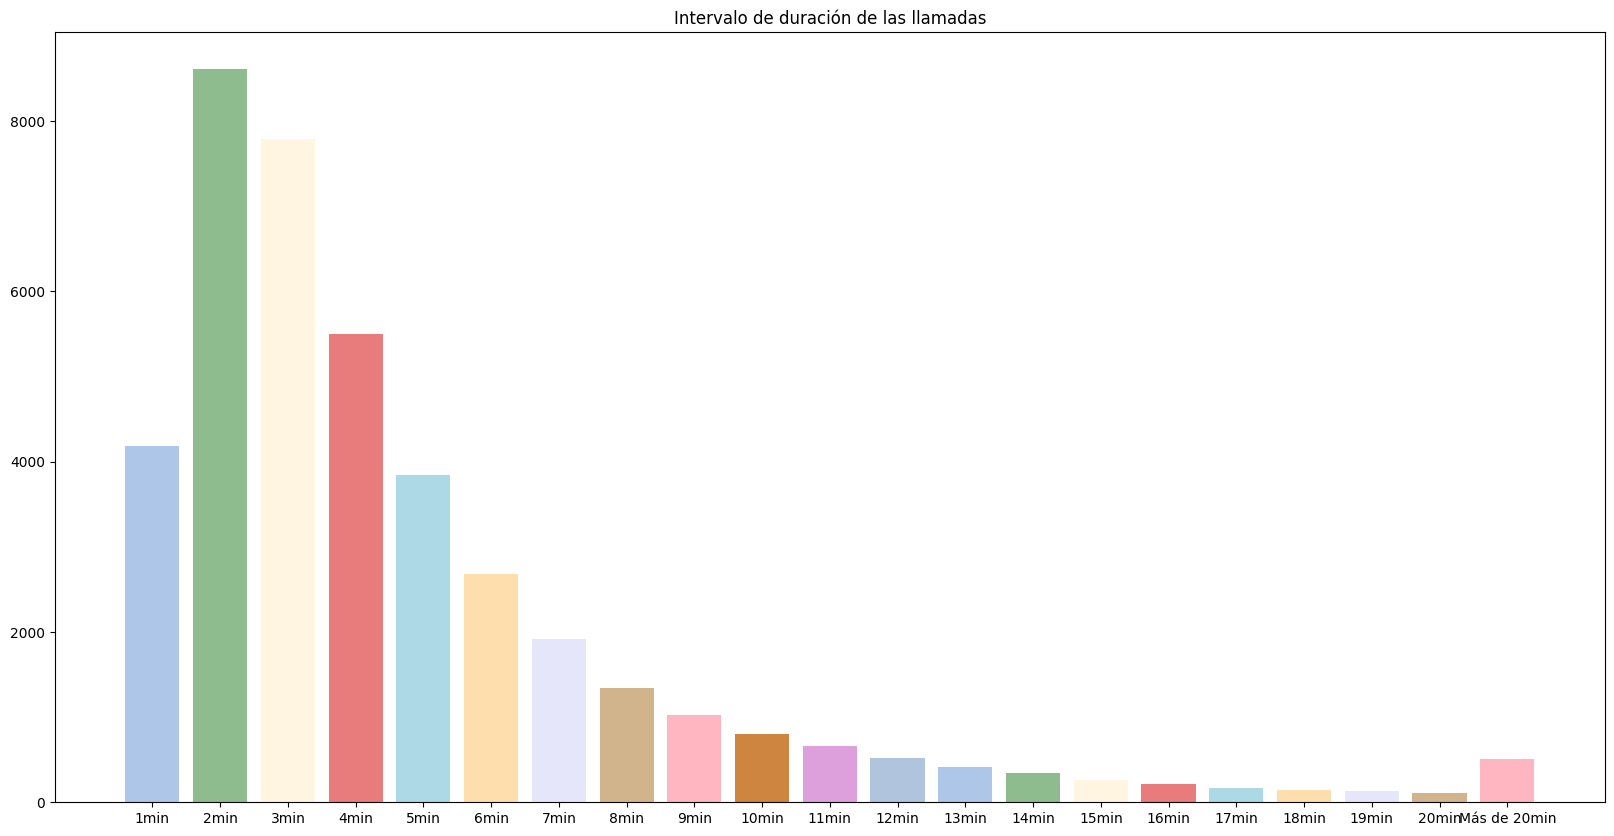

In [375]:
# Balance de la duración de las llamadas
duration_interval_counts = bank_marketing["duration_interval"].value_counts()

duracion_ordenada = ['1min', '2min', '3min', '4min', '5min', '6min', '7min', '8min', '9min', '10min', '11min', '12min', '13min', '14min', '15min', '16min', '17min', '18min', '19min', '20min', 'Más de 20min']

duracion_mapping = {min: i for i, min in enumerate(duracion_ordenada)}
duration_interval_counts = duration_interval_counts.reindex(duracion_ordenada)

plt.figure(figsize=(20, 10))

plt.bar(duration_interval_counts.index, duration_interval_counts, color=colores)
plt.title("Intervalo de duración de las llamadas")

plt.show()


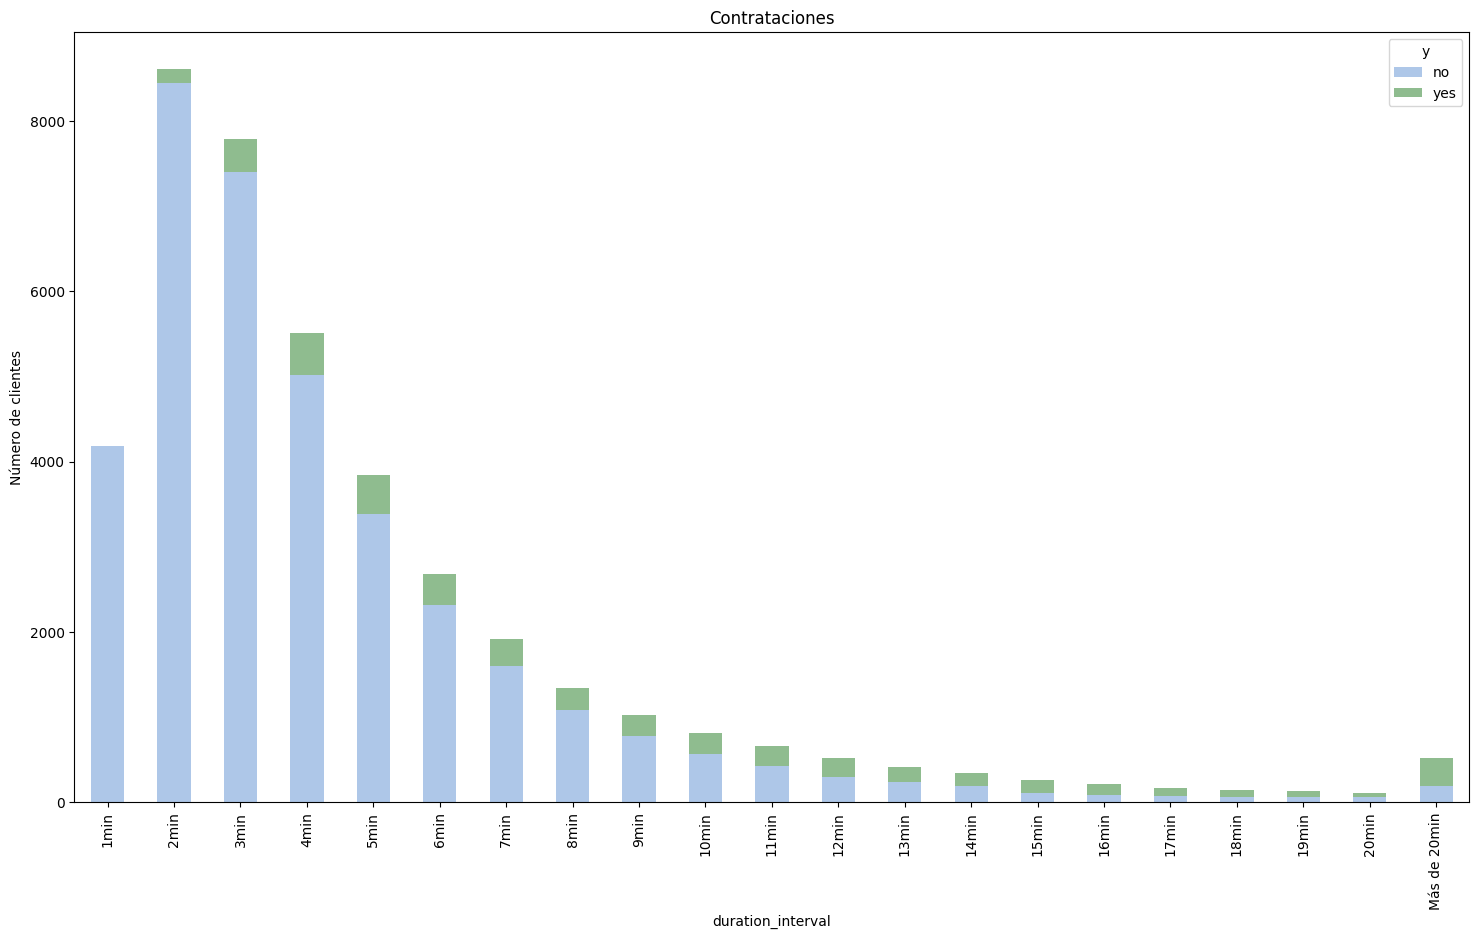

In [376]:
# Contratados y no contratados
call_counts = bank_marketing.groupby(['duration_interval', 'y']).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(18, 10))
call_counts.plot(kind='bar', stacked=True, ax=ax, color=colores)

ax.set_title('Contrataciones')
ax.set_ylabel('Número de clientes')
plt.show()

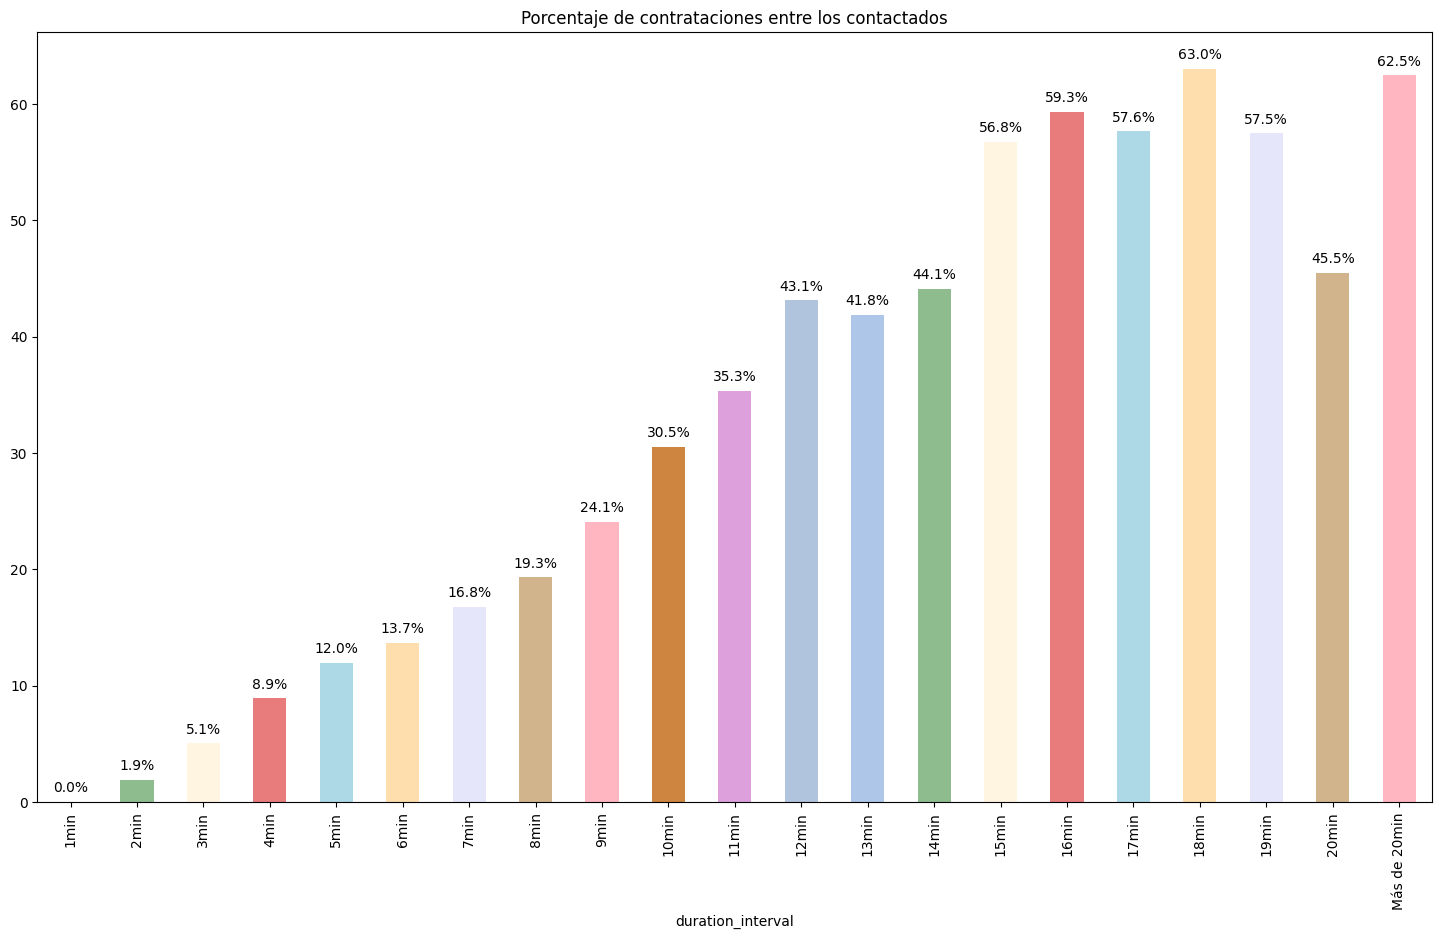

In [377]:
contrataciones_duration_porcentaje = bank_marketing[bank_marketing['y'] == 'yes'].groupby('duration_interval').size() / bank_marketing.groupby('duration_interval').size() * 100

# Del total de contactados cuántos contratan
fig, ax = plt.subplots(figsize=(18, 10))
contrataciones_duration_porcentaje.plot(kind='bar', stacked=True, ax=ax, color=colores)

# Configuración del gráfico
ax.set_title('Porcentaje de contrataciones entre los contactados')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    
plt.show()

In [378]:
bank_marketing.drop('duration_interval', axis=1, inplace=True)

#### Número de contactos

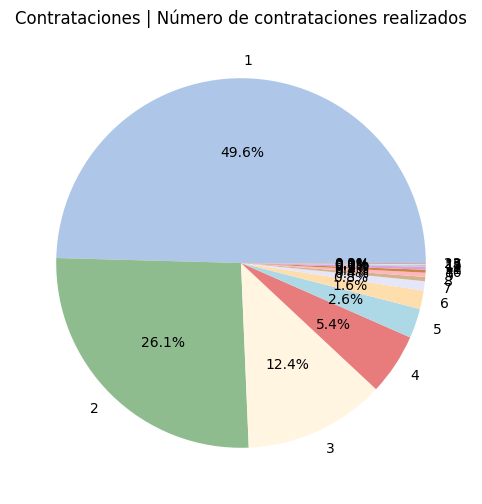

In [379]:
# Contrataciones por el número de contactos realizados
campaign_contrataciones = bank_marketing[bank_marketing["y"] == 'yes'].groupby("campaign").size()

plt.figure(figsize=(10, 6))
plt.pie(campaign_contrataciones, labels=campaign_contrataciones.index, autopct='%1.1f%%', colors=colores)
plt.title("Contrataciones | Número de contrataciones realizados")

plt.show()

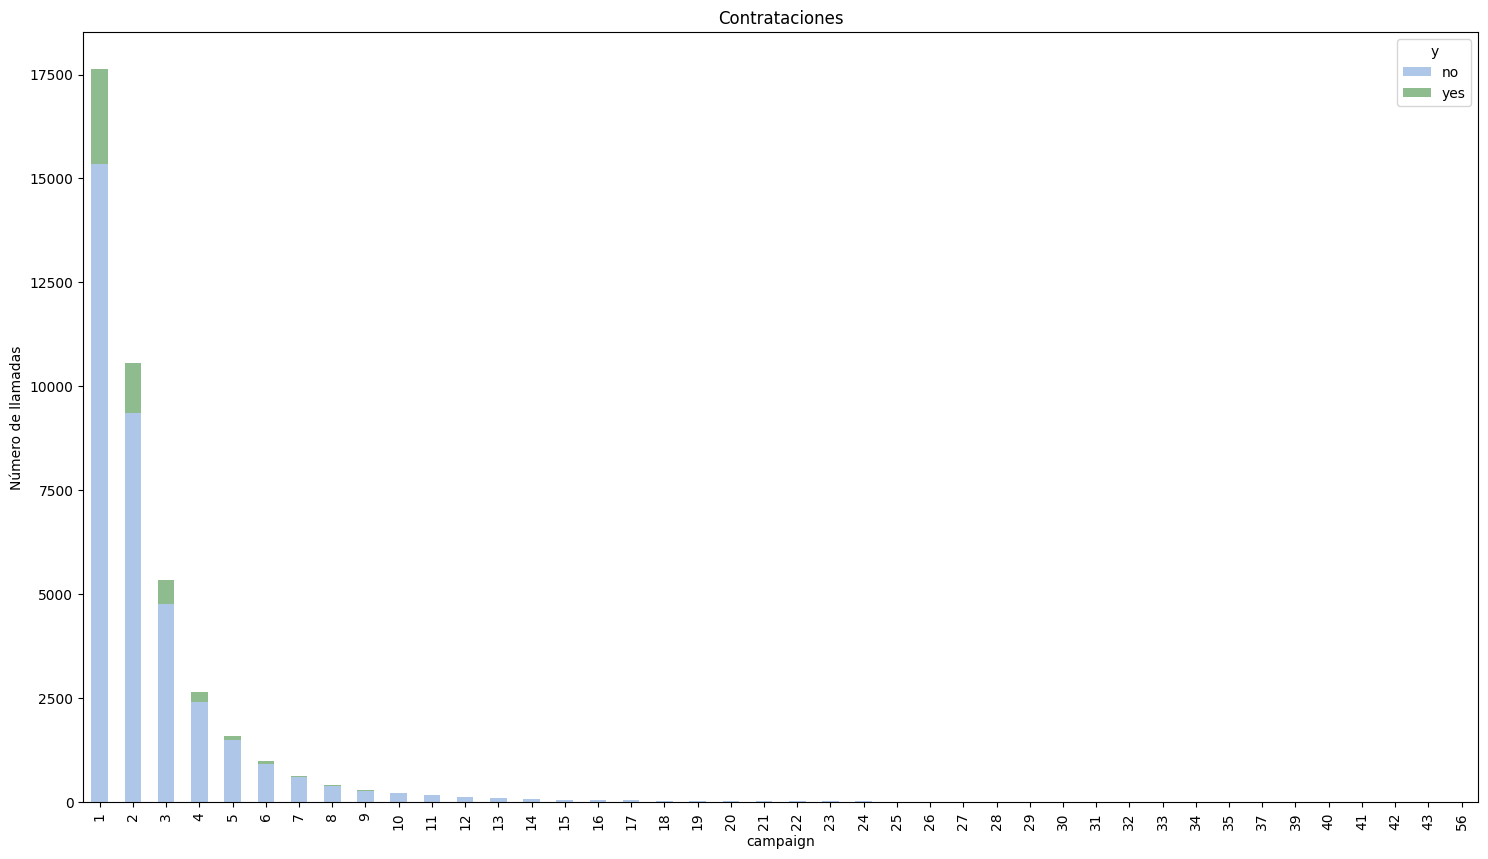

In [380]:
# Contratados y no contratados
campaign_counts = bank_marketing.groupby(['campaign', 'y']).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(18, 10))
campaign_counts.plot(kind='bar', stacked=True, ax=ax, color=colores)

ax.set_title('Contrataciones')
ax.set_ylabel('Número de llamadas')
plt.show()

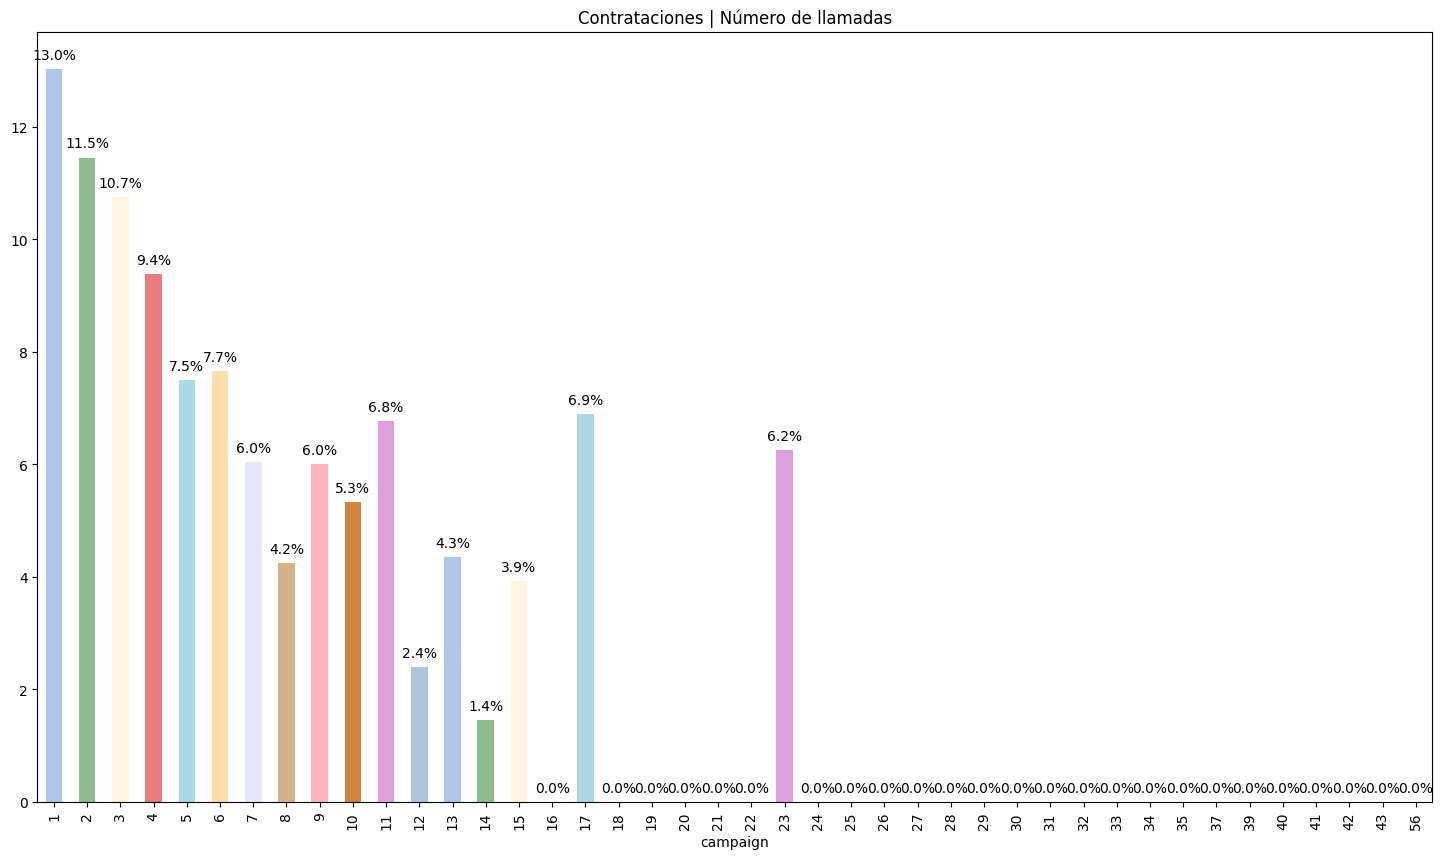

In [381]:
# Porcentaje de contrataciones por el total de las llamadas realizadas. 
campaign_porcentaje = bank_marketing[bank_marketing['y'] == 'yes'].groupby('campaign').size() / bank_marketing.groupby('campaign').size() * 100

fig, ax = plt.subplots(figsize=(18, 10))
campaign_porcentaje.plot(kind='bar', stacked=True, ax=ax, color=colores)

ax.set_title('Contrataciones | Número de llamadas')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    
plt.show()

#### Resultado a la campaña anterior

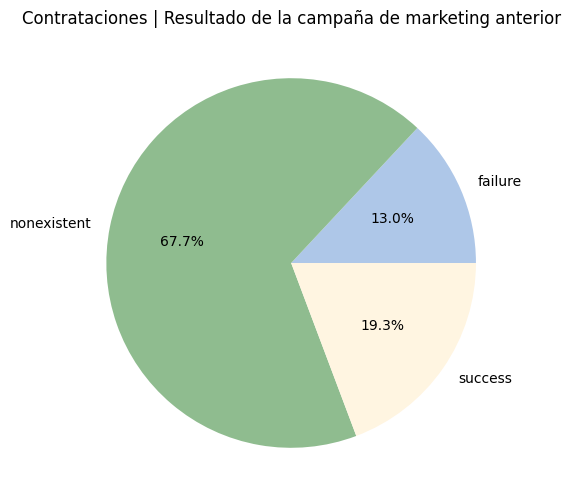

In [382]:
# Resultado de la campaña de marketing anterior
poutcome_contrataciones = bank_marketing[bank_marketing["y"] == 'yes'].groupby("poutcome").size()

plt.figure(figsize=(10, 6))
plt.pie(poutcome_contrataciones, labels=poutcome_contrataciones.index, autopct='%1.1f%%', colors=colores)
plt.title("Contrataciones | Resultado de la campaña de marketing anterior")

plt.show()

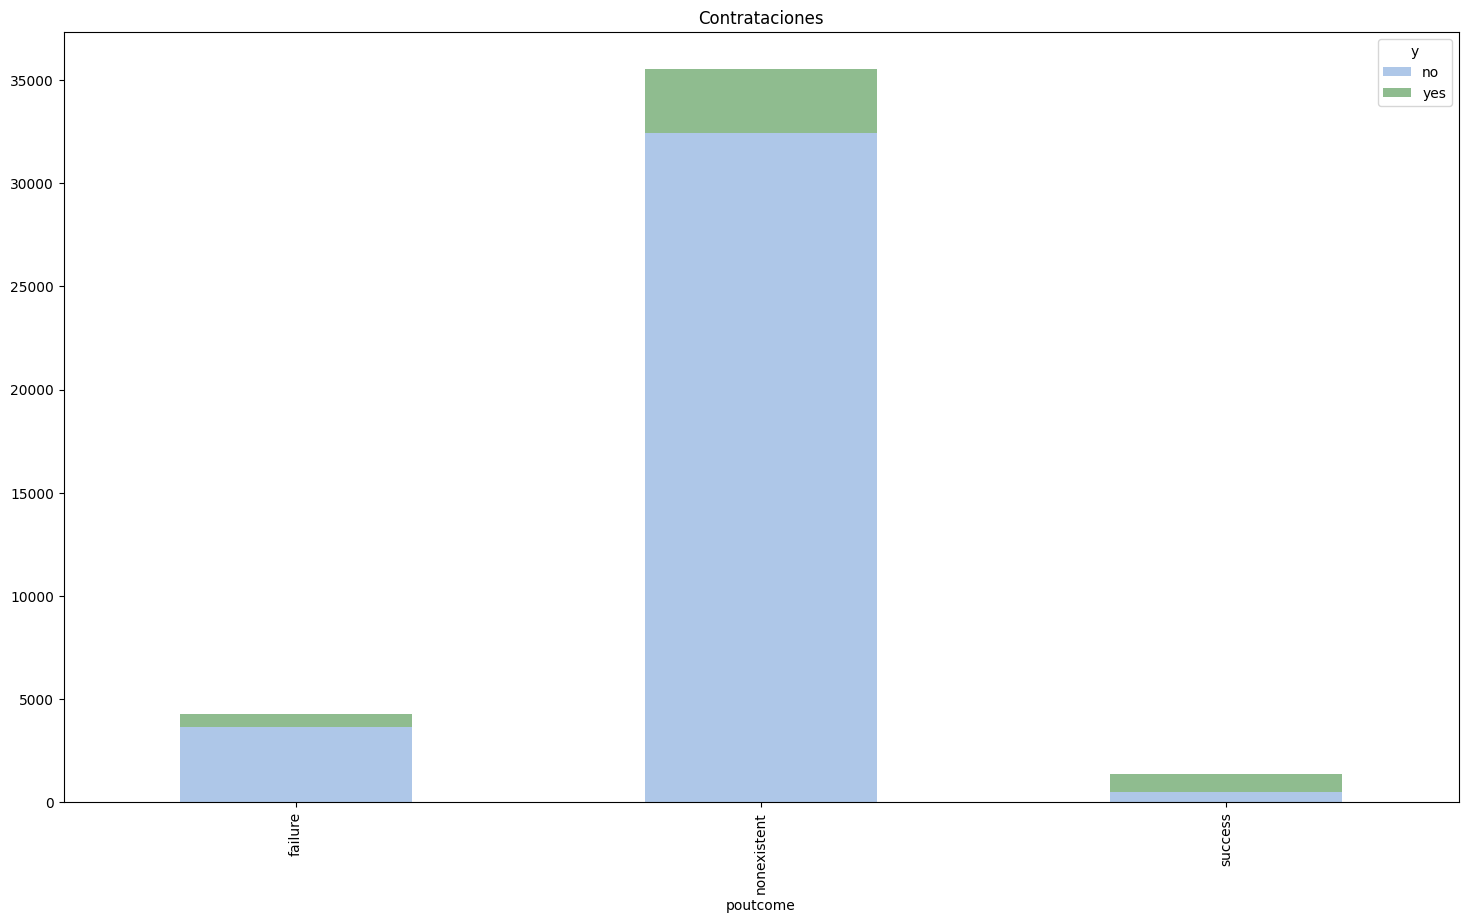

In [383]:
# Contratados y no contratados
poutcome_counts = bank_marketing.groupby(['poutcome', 'y']).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(18, 10))
poutcome_counts.plot(kind='bar', stacked=True, ax=ax, color=colores)

ax.set_title('Contrataciones')
plt.show()

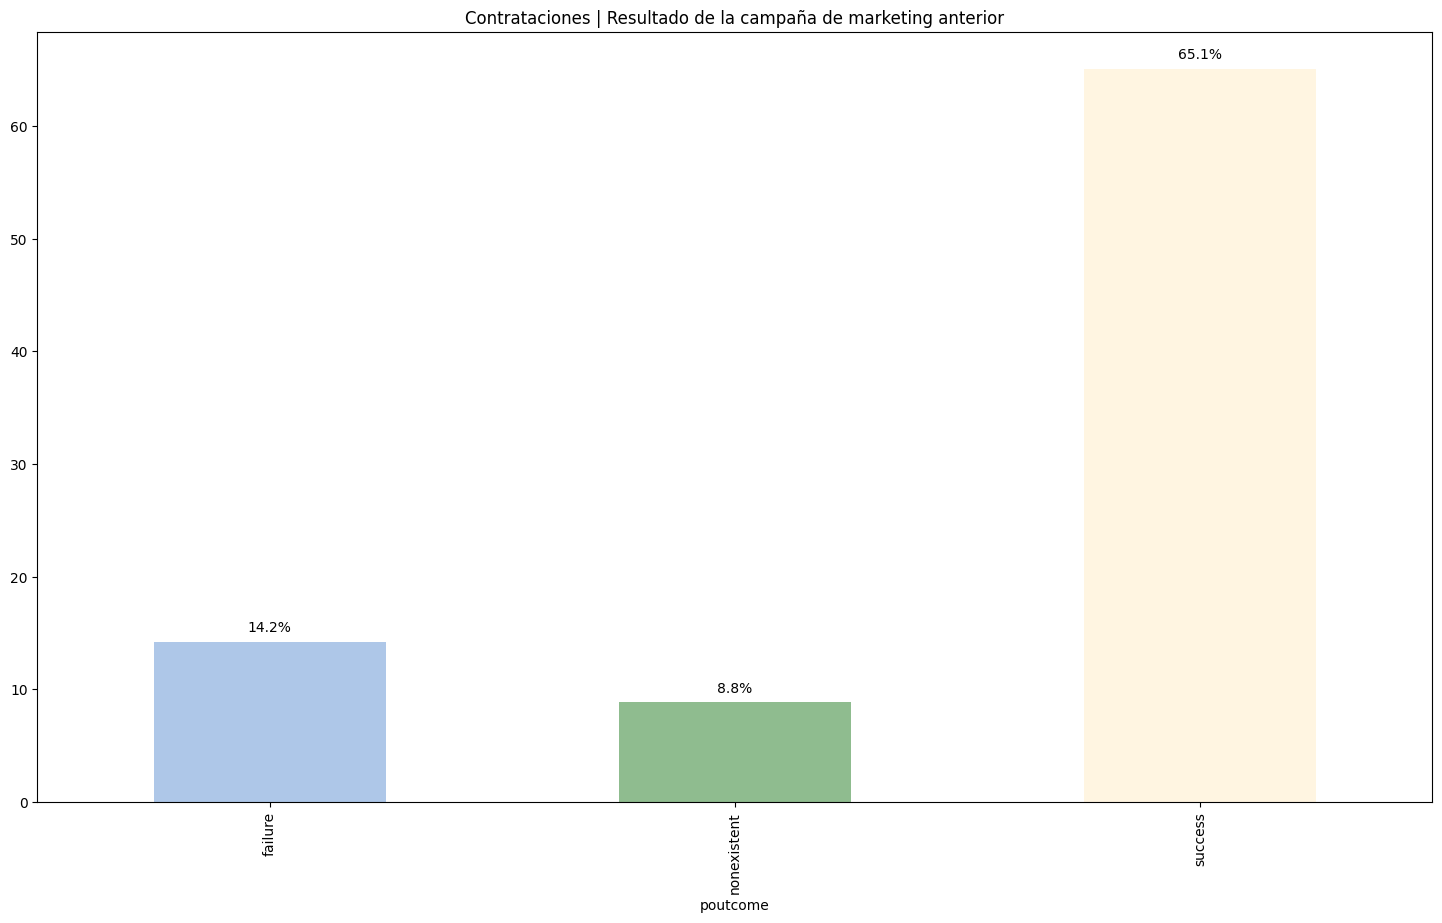

In [384]:
# Porcentaje de contrataciones por el total de contactados. 
poutcome_porcentaje = bank_marketing[bank_marketing['y'] == 'yes'].groupby('poutcome').size() / bank_marketing.groupby('poutcome').size() * 100

fig, ax = plt.subplots(figsize=(18, 10))
poutcome_porcentaje.plot(kind='bar', stacked=True, ax=ax, color=colores)

ax.set_title('Contrataciones | Resultado de la campaña de marketing anterior')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    
plt.show()

### Estado de la economía

**Análisis del estado de la economía**

* **Tasa de variación del empleo**: La mayoría de las contrataciones se llevaron a cabo con una tasa de variación del empleo de -1.8, representando un 31.5%, seguido por un 1.4. Sin embargo, es relevante señalar que la mayor parte de los contactos también se realizaron con estas tasas. Este hallazgo sugiere que, aunque estas tasas están asociadas con contrataciones significativas, la relación entre la tasa de variación del empleo y las contrataciones no es lineal.

* **Índice de precios al consumidor**: No se observa una variación sustancial entre un índice y otro, ya que todos son bastante similares, indicando una alta volatilidad en este indicador económico.

* **Índice de confianza del consumidor**: Al igual que con el IPC, no hay una variación significativa entre los índices, revelando una alta volatilidad en el índice de confianza del consumidor.

* **Euribor**: Dada su naturaleza diaria, el Euribor emerge como una variable crítica para nuestro estudio. La mayoría de las contrataciones se realizaron con un índice de 5099.1, representando el 23.5%, seguido por 5228.1 con un 18.7%. Es destacable que a medida que el índice del Euribor disminuye, se observa un aumento en las contrataciones. Este patrón sugiere una relación inversa entre el Euribor y las contrataciones, indicando que tasas más bajas están asociadas con un mayor número de contrataciones.

#### Tasa de variación del empleo

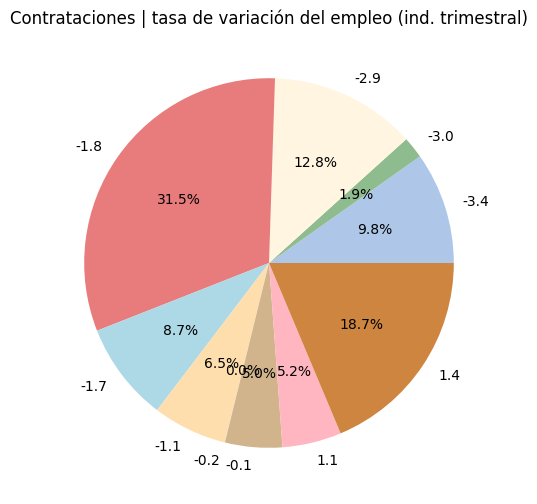

In [385]:
# Número de contactos realizados
emp_contrataciones = bank_marketing[bank_marketing["y"] == 'yes'].groupby("emp.var.rate").size()

plt.figure(figsize=(10, 6))
plt.pie(emp_contrataciones, labels=emp_contrataciones.index, autopct='%1.1f%%', colors=colores)
plt.title("Contrataciones | tasa de variación del empleo (ind. trimestral)")

plt.show()

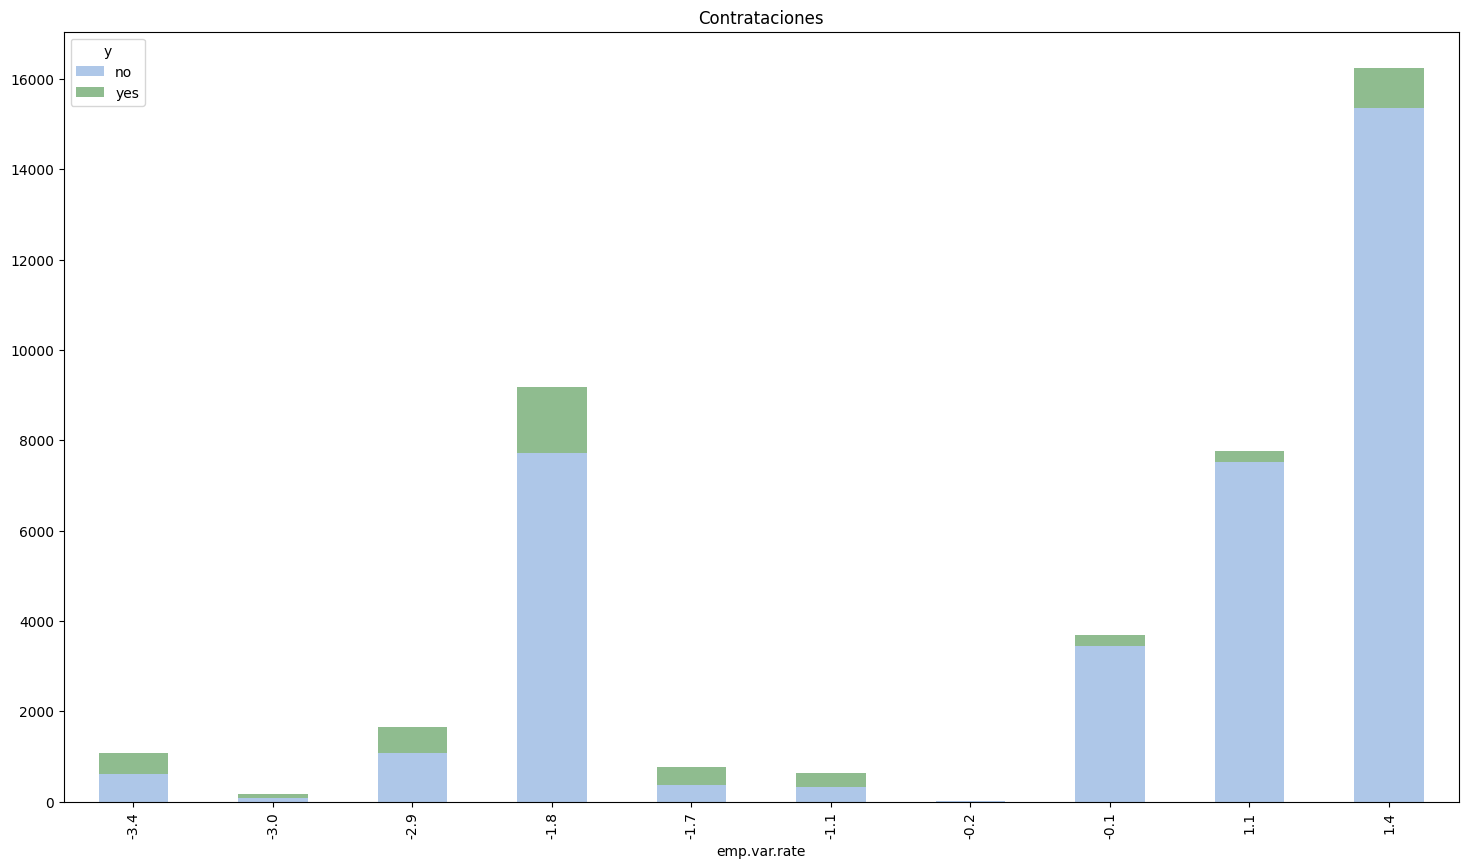

In [386]:
# Contratados y no contratados
emp_counts = bank_marketing.groupby(['emp.var.rate', 'y']).size().unstack(fill_value=0)


fig, ax = plt.subplots(figsize=(18, 10))
emp_counts.plot(kind='bar', stacked=True, ax=ax, color=colores)

ax.set_title('Contrataciones')
plt.show()

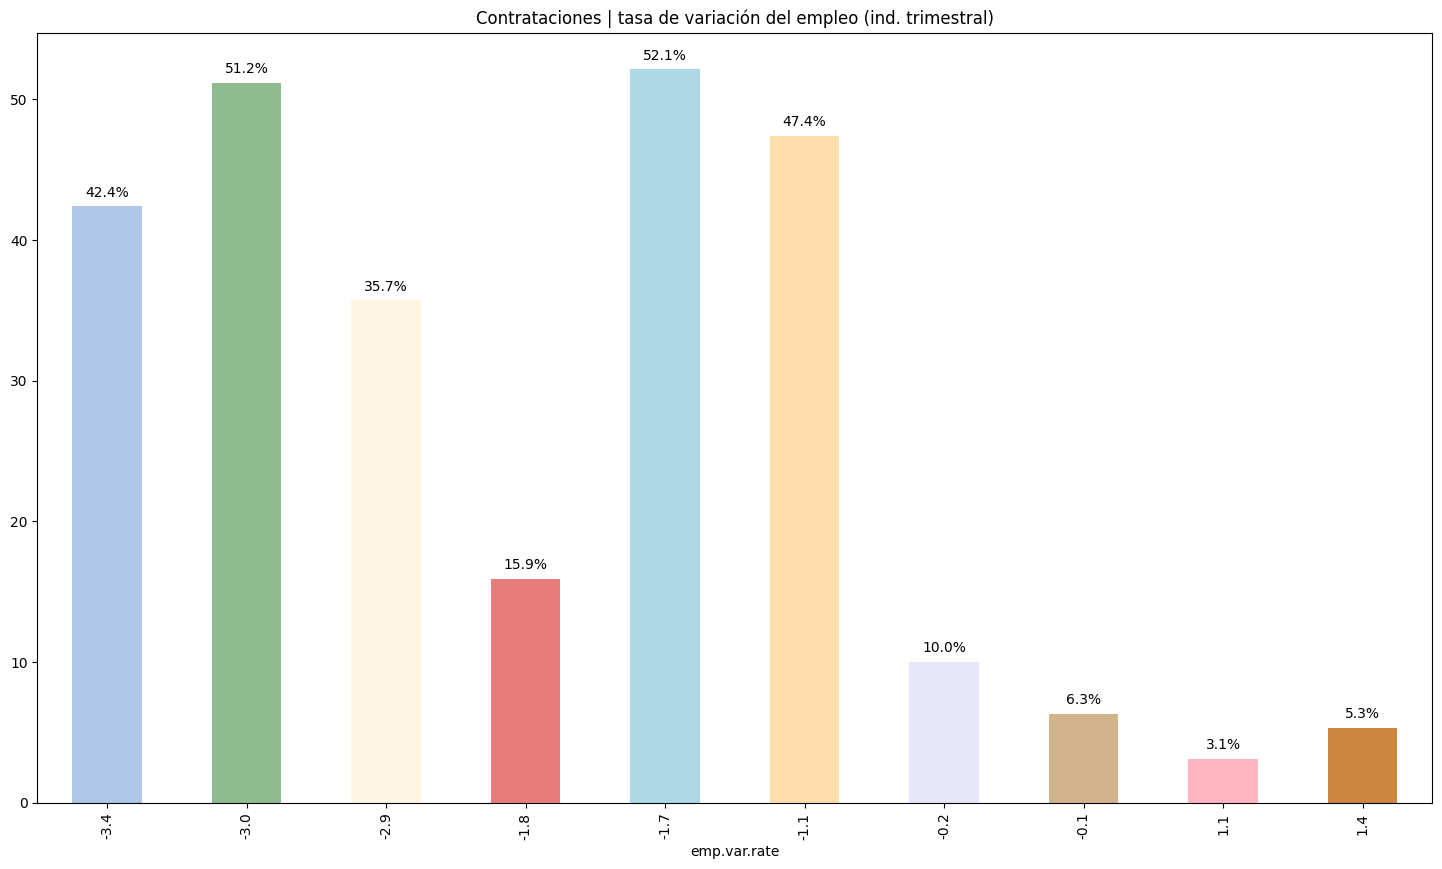

In [387]:
emp_porcentaje = bank_marketing[bank_marketing['y'] == 'yes'].groupby('emp.var.rate').size() / bank_marketing.groupby('emp.var.rate').size() * 100

# Del total de contactados cuántos contratan
fig, ax = plt.subplots(figsize=(18, 10))
emp_porcentaje.plot(kind='bar', stacked=True, ax=ax, color=colores)

# Configuración del gráfico
ax.set_title('Contrataciones | tasa de variación del empleo (ind. trimestral)')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    
plt.show()

#### Índice de precios al consumidor

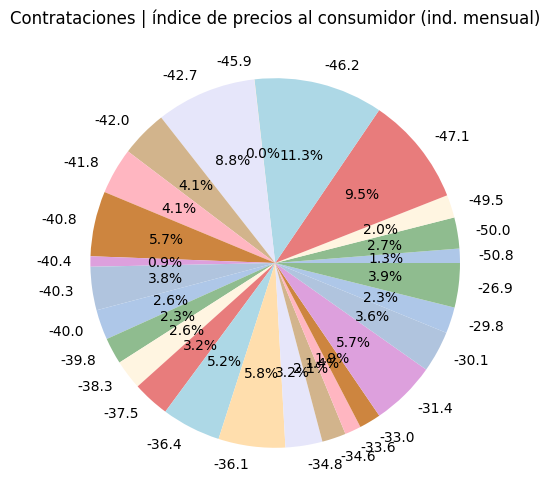

In [388]:
# Número de contactos realizados
conf_contrataciones = bank_marketing[bank_marketing["y"] == 'yes'].groupby("cons.conf.idx").size()

plt.figure(figsize=(10, 6))
plt.pie(conf_contrataciones, labels=conf_contrataciones.index, autopct='%1.1f%%', colors=colores)
plt.title("Contrataciones | índice de precios al consumidor (ind. mensual)")

plt.show()

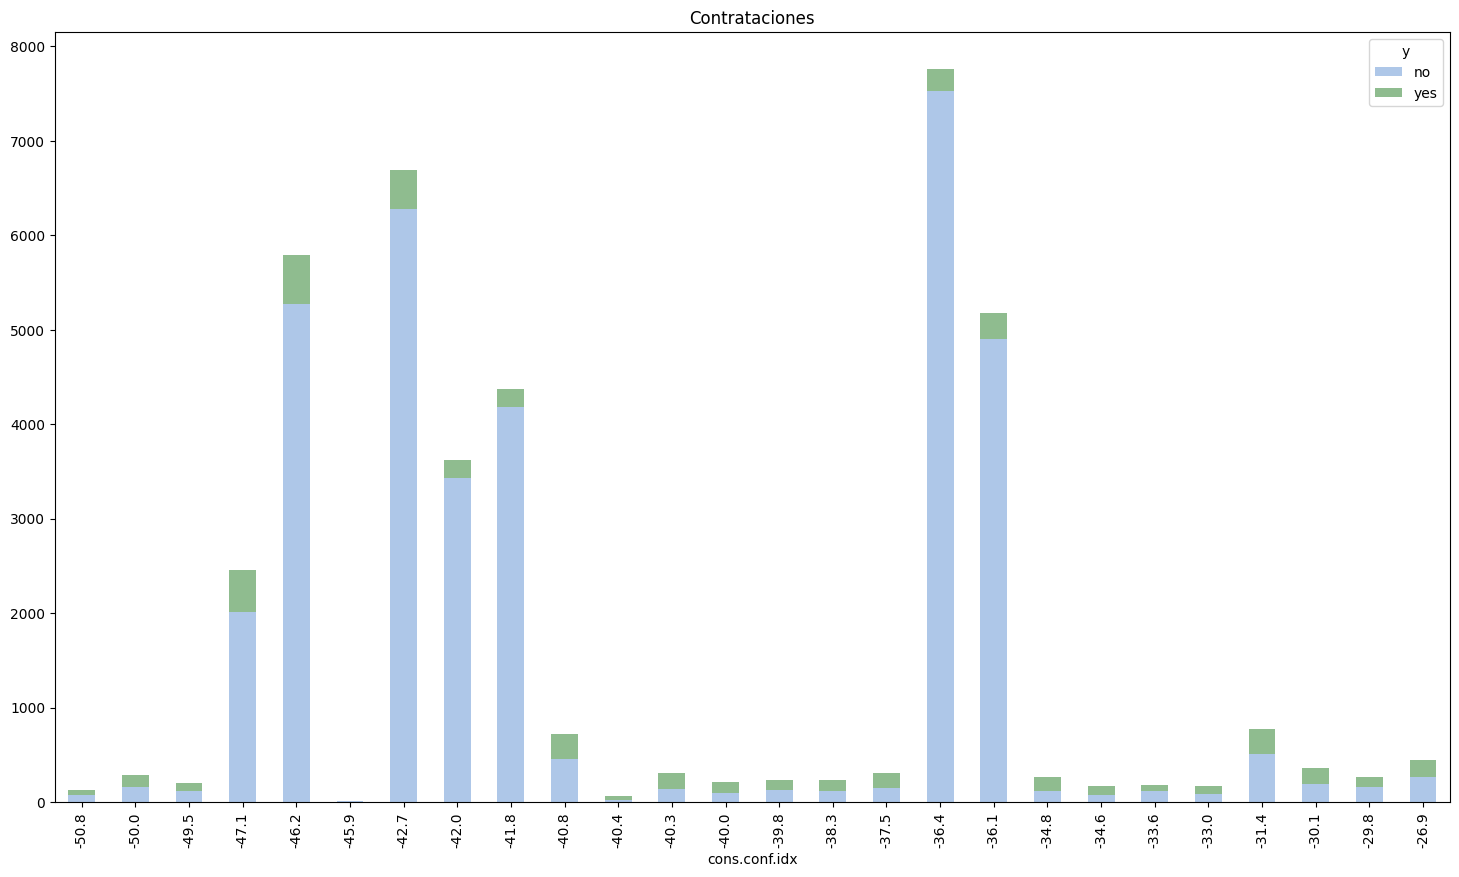

In [389]:
conf_counts = bank_marketing.groupby(['cons.conf.idx', 'y']).size().unstack(fill_value=0)

# Contratados y no contratados
fig, ax = plt.subplots(figsize=(18, 10))
conf_counts.plot(kind='bar', stacked=True, ax=ax, color=colores)

ax.set_title('Contrataciones')
plt.show()

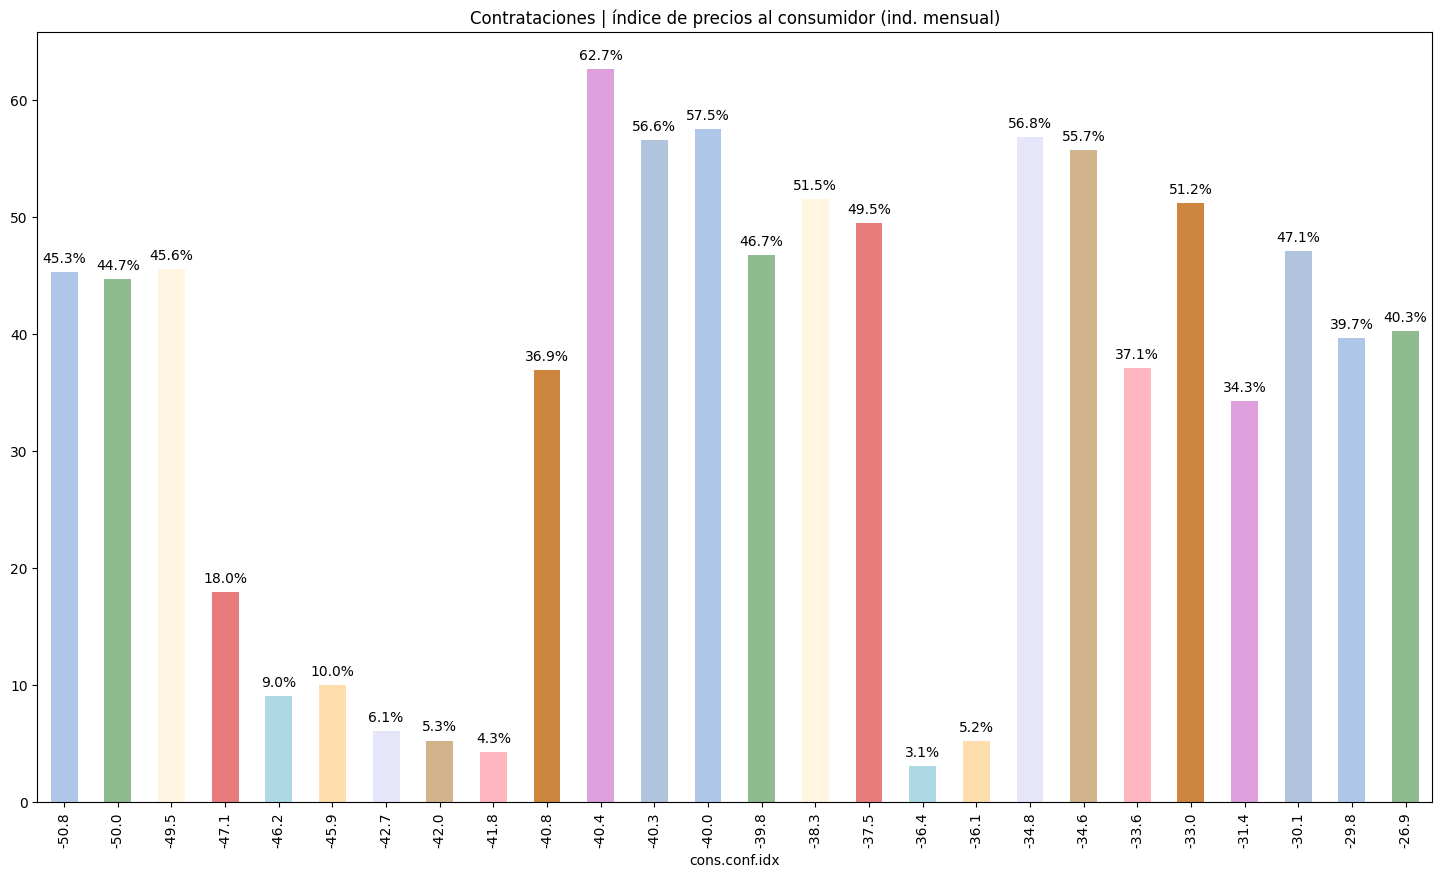

In [390]:
conf_porcentaje = bank_marketing[bank_marketing['y'] == 'yes'].groupby('cons.conf.idx').size() / bank_marketing.groupby('cons.conf.idx').size() * 100

# Del total de contactados cuántos contratan
fig, ax = plt.subplots(figsize=(18, 10))
conf_porcentaje.plot(kind='bar', stacked=True, ax=ax, color=colores)

# Configuración del gráfico
ax.set_title('Contrataciones | índice de precios al consumidor (ind. mensual)')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    
plt.show()

#### Índice de confianza del consumidor

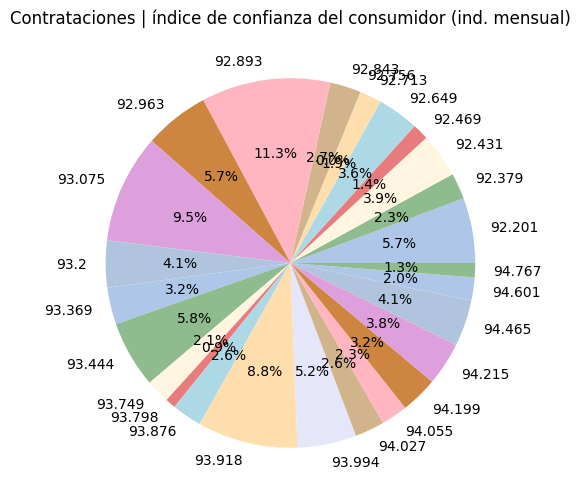

In [391]:
# Número de contactos realizados
price_contrataciones = bank_marketing[bank_marketing["y"] == 'yes'].groupby("cons.price.idx").size()

# Visualización de datos
plt.figure(figsize=(10, 6))
plt.pie(price_contrataciones, labels=price_contrataciones.index, autopct='%1.1f%%', colors=colores)
plt.title("Contrataciones | índice de confianza del consumidor (ind. mensual)")

plt.show()

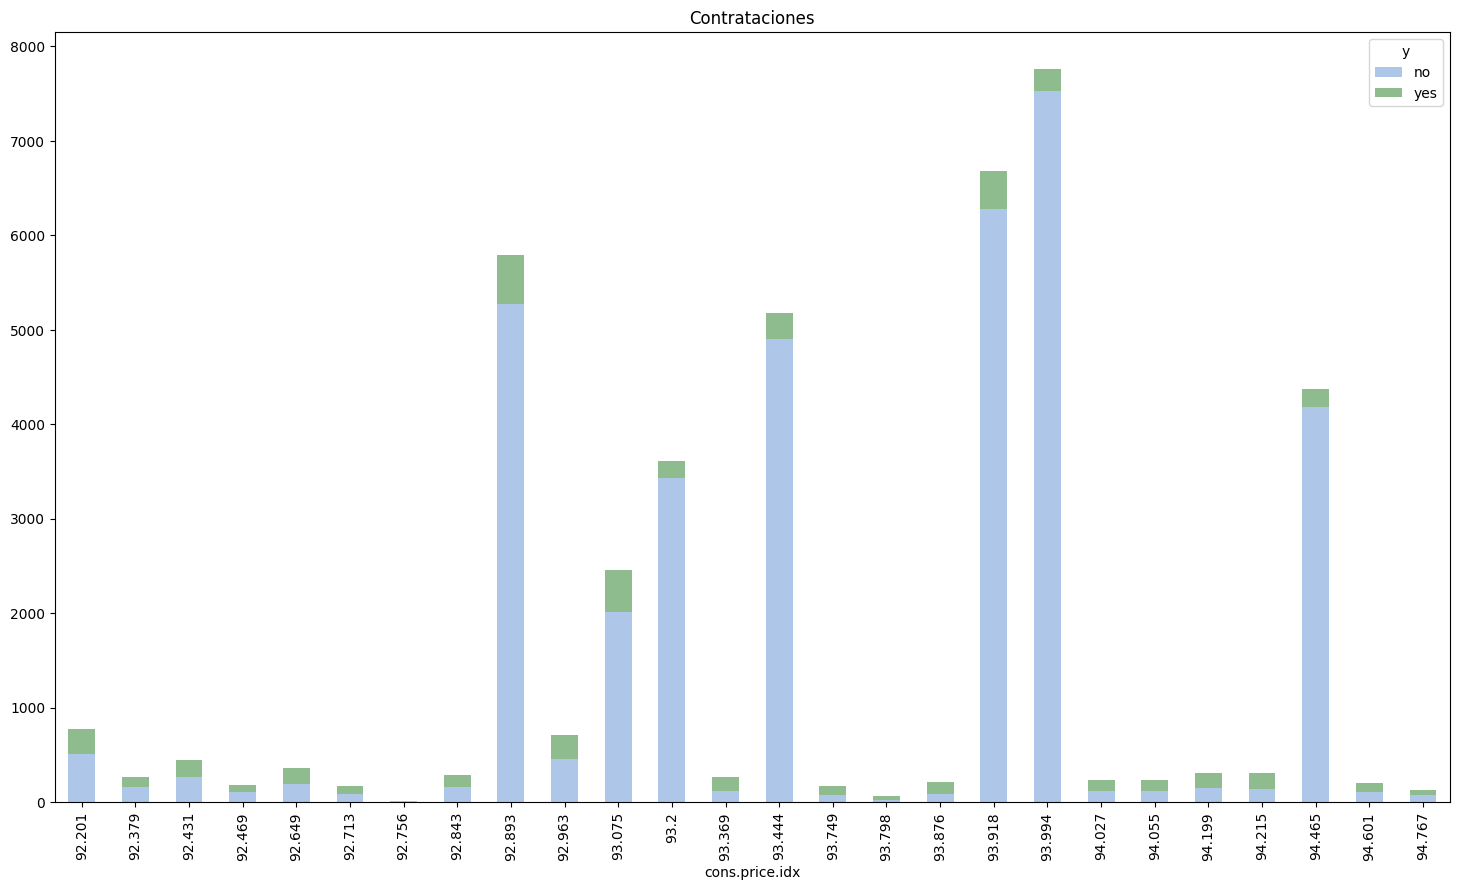

In [392]:
# Contratados y no contratados
price_counts = bank_marketing.groupby(['cons.price.idx', 'y']).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(18, 10))
price_counts.plot(kind='bar', stacked=True, ax=ax, color=colores)

ax.set_title('Contrataciones')
plt.show()

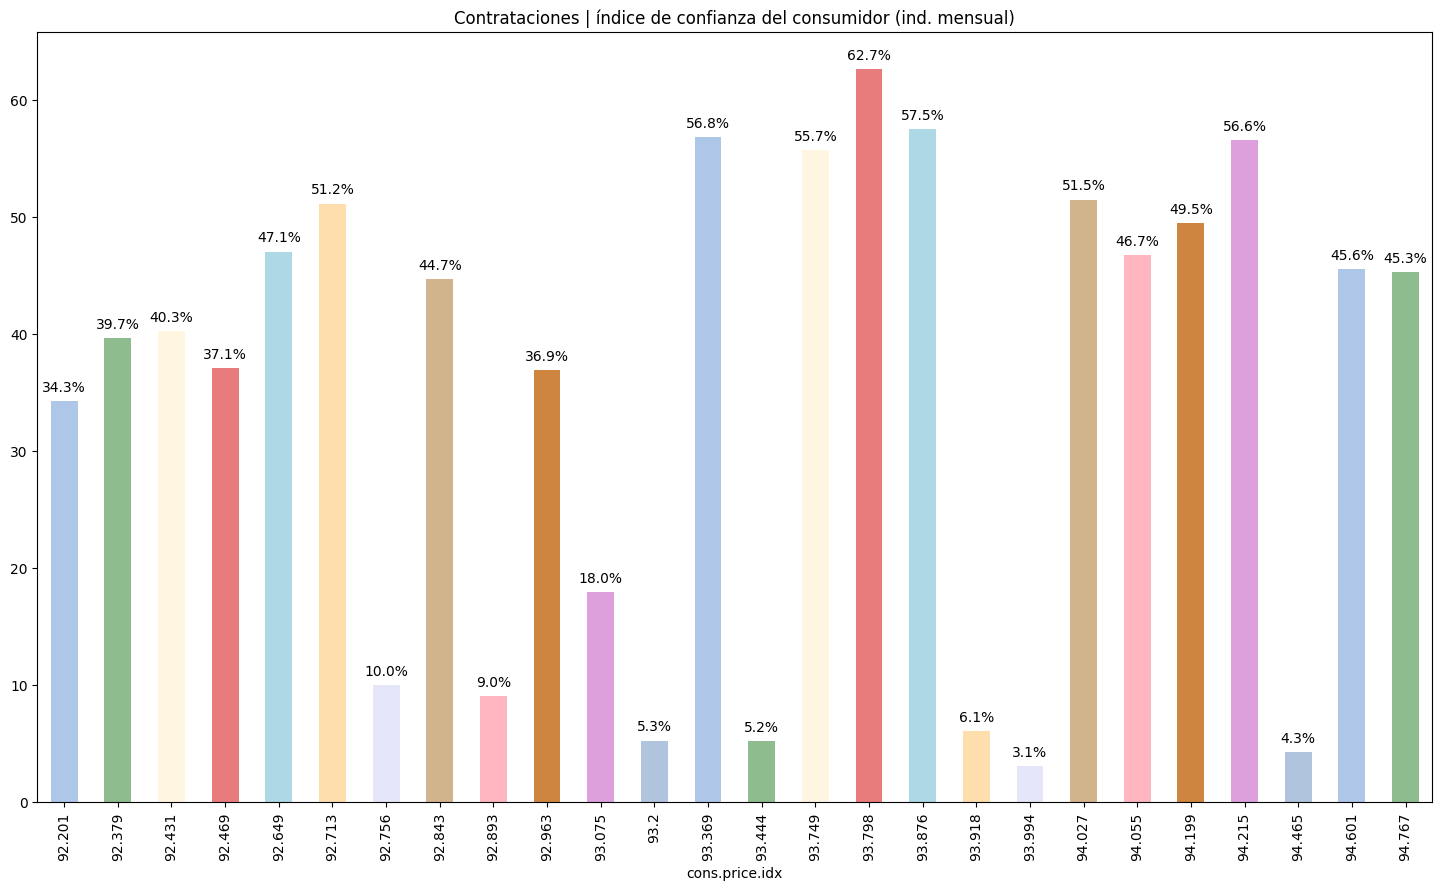

In [393]:
# Del total de contactados cuántos contratan
price_porcentaje = bank_marketing[bank_marketing['y'] == 'yes'].groupby('cons.price.idx').size() / bank_marketing.groupby('cons.price.idx').size() * 100

fig, ax = plt.subplots(figsize=(18, 10))
price_porcentaje.plot(kind='bar', stacked=True, ax=ax, color=colores)

ax.set_title('Contrataciones | índice de confianza del consumidor (ind. mensual)')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    
plt.show()

#### Euribor

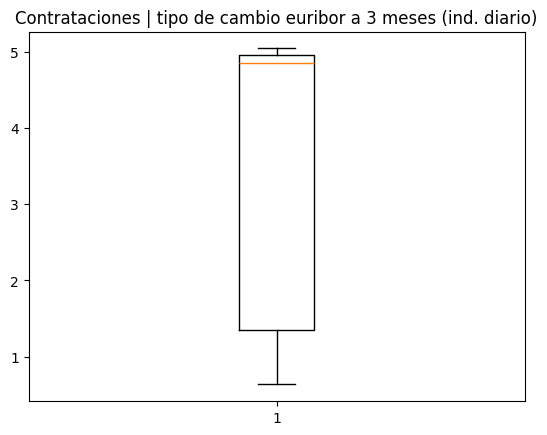

In [394]:
# Número de contactos realizados
euribor_contrataciones = bank_marketing[bank_marketing["y"] == 'yes'].groupby("euribor3m").size()

# Visualización de datos
plt.boxplot(bank_marketing["euribor3m"])
plt.title("Contrataciones | tipo de cambio euribor a 3 meses (ind. diario)")

plt.show()

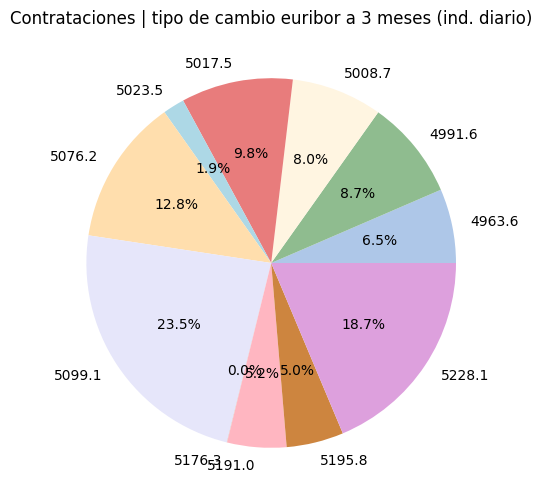

In [395]:
# Número de contactos realizados
employed_contrataciones = bank_marketing[bank_marketing["y"] == 'yes'].groupby("nr.employed").size()

plt.figure(figsize=(10, 6))
plt.pie(employed_contrataciones, labels=employed_contrataciones.index, autopct='%1.1f%%', colors=colores)
plt.title("Contrataciones | tipo de cambio euribor a 3 meses (ind. diario)")

plt.show()

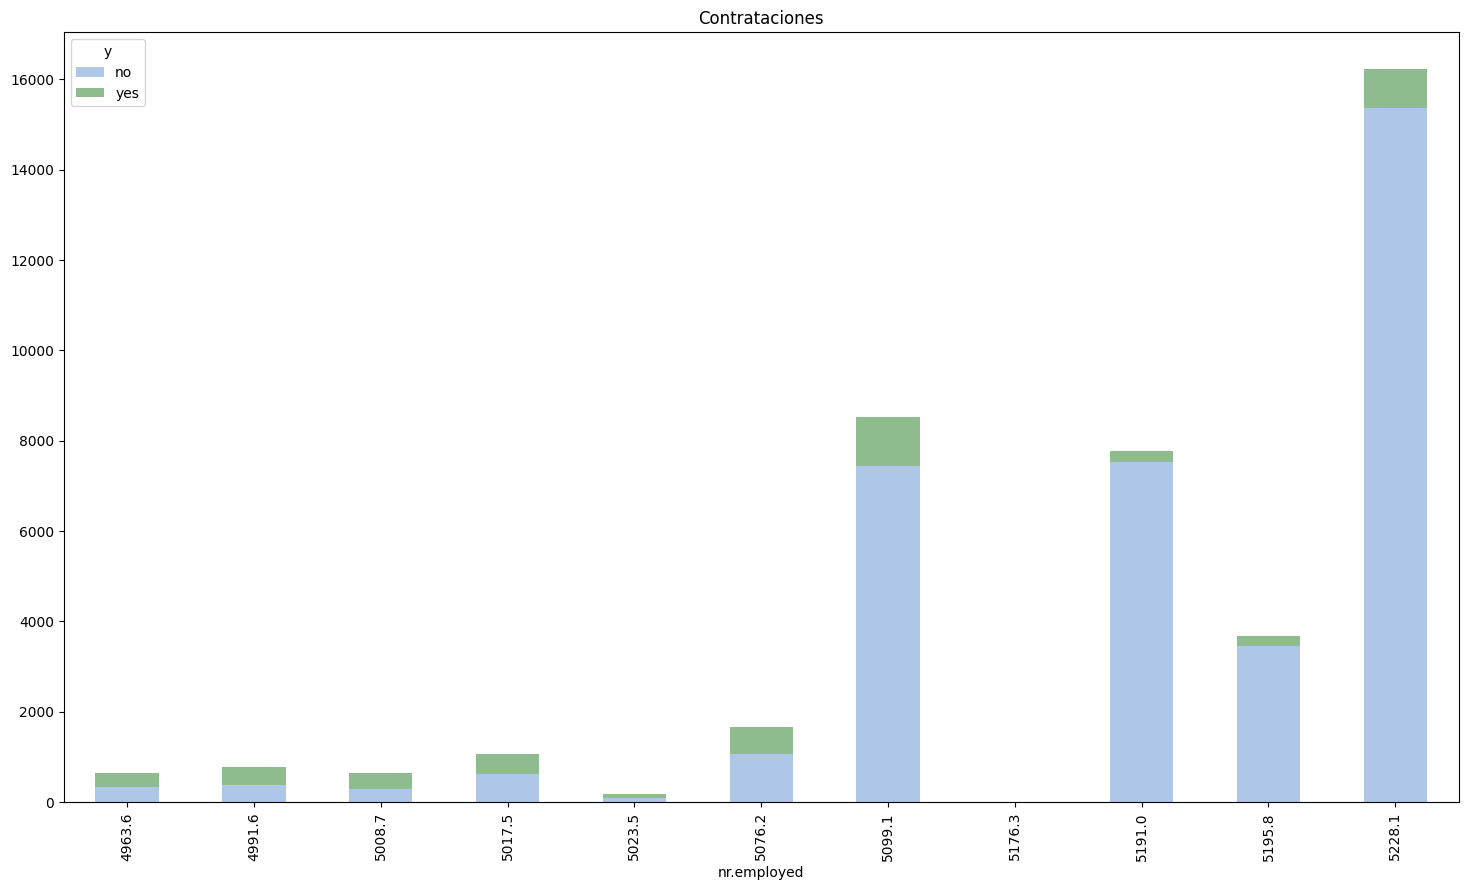

In [396]:
# Contratados y no contratados
employed_counts = bank_marketing.groupby(['nr.employed', 'y']).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(18, 10))
employed_counts.plot(kind='bar', stacked=True, ax=ax, color=colores)

ax.set_title('Contrataciones')
plt.show()

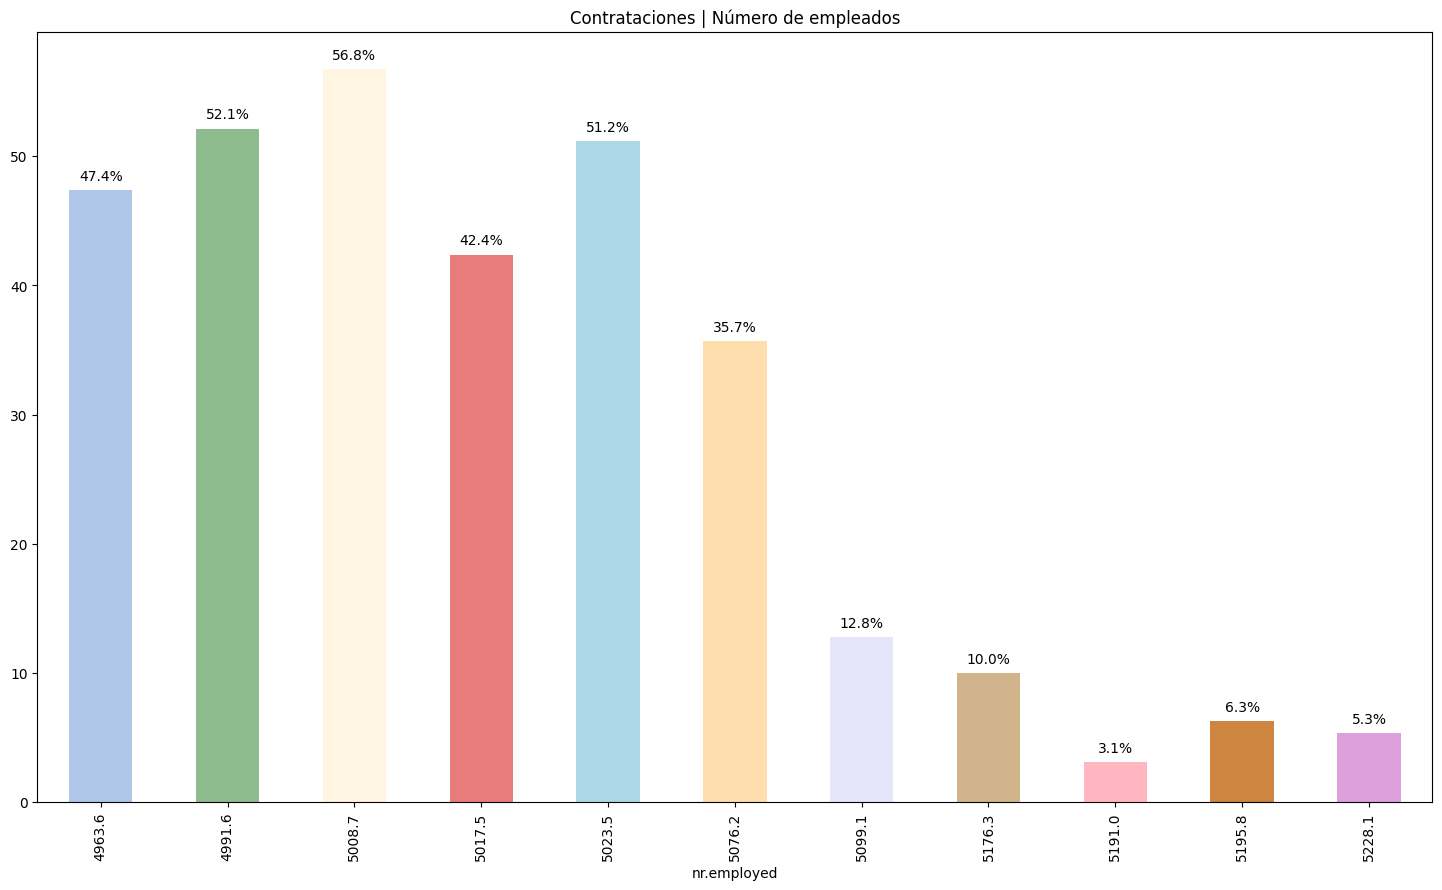

In [397]:
# Del total de contactados cuántos contratan
employed_porcentaje = bank_marketing[bank_marketing['y'] == 'yes'].groupby('nr.employed').size() / bank_marketing.groupby('nr.employed').size() * 100

fig, ax = plt.subplots(figsize=(18, 10))
employed_porcentaje.plot(kind='bar', stacked=True, ax=ax, color=colores)

ax.set_title('Contrataciones | Número de empleados')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    
plt.show()

### Correlaciones

En el siguiente apartado dedicado al análisis de correlaciones, exploraremos las relaciones entre diversas variables relevantes para nuestra investigación. Es crucial destacar que, a medida que examinamos detenidamente estas asociaciones, no se observarán correlaciones directas destacables entre las variable de análisis, la contratación o no del plazo bancario, y el resto de variables. Este hallazgo subraya la complejidad y la diversidad de factores que influyen en nuestro conjunto de datos, proporcionando una visión más completa y matizada de las interrelaciones entre las distintas características analizadas.

In [398]:
# Pasar numérico el target
bank_marketing['y'] = bank_marketing['y'].map({'yes': 1, 'no': 0})

#### Mapa de calor de correlación: Explorando las relaciones entre variables numéricas

El Mapa de Calor de Correlación analiza las relaciones entre variables en un conjunto de datos y visualiza la magnitud y dirección de las correlaciones. Este gráfico utiliza colores para representar los valores de correlación, permitiendo una interpretación rápida e intuitiva de las asociaciones entre las variables.

* No hay correlaciones directas. 

* **Duración de la Llamada y la contratación**: Se identifica una correlación fuerte entre la duración de la llamada y la probabilidad de contratación.

* **Emp.var.rate y sus correlaciones**: La variable Emp.var.rate (tasa de variación del empleo, indicador trimestral) presenta correlaciones significativas con euribor3m, nr.employed, y cons.price.idx. Para simplificar el análisis y evitar multicolinealidad, se ha decidido conservar únicamente la variable euribor3m debido a su naturaleza diaria, en contraste con los demás datos que son trimestrales. Esta elección se realiza para mantener la representatividad y relevancia del conjunto de datos.

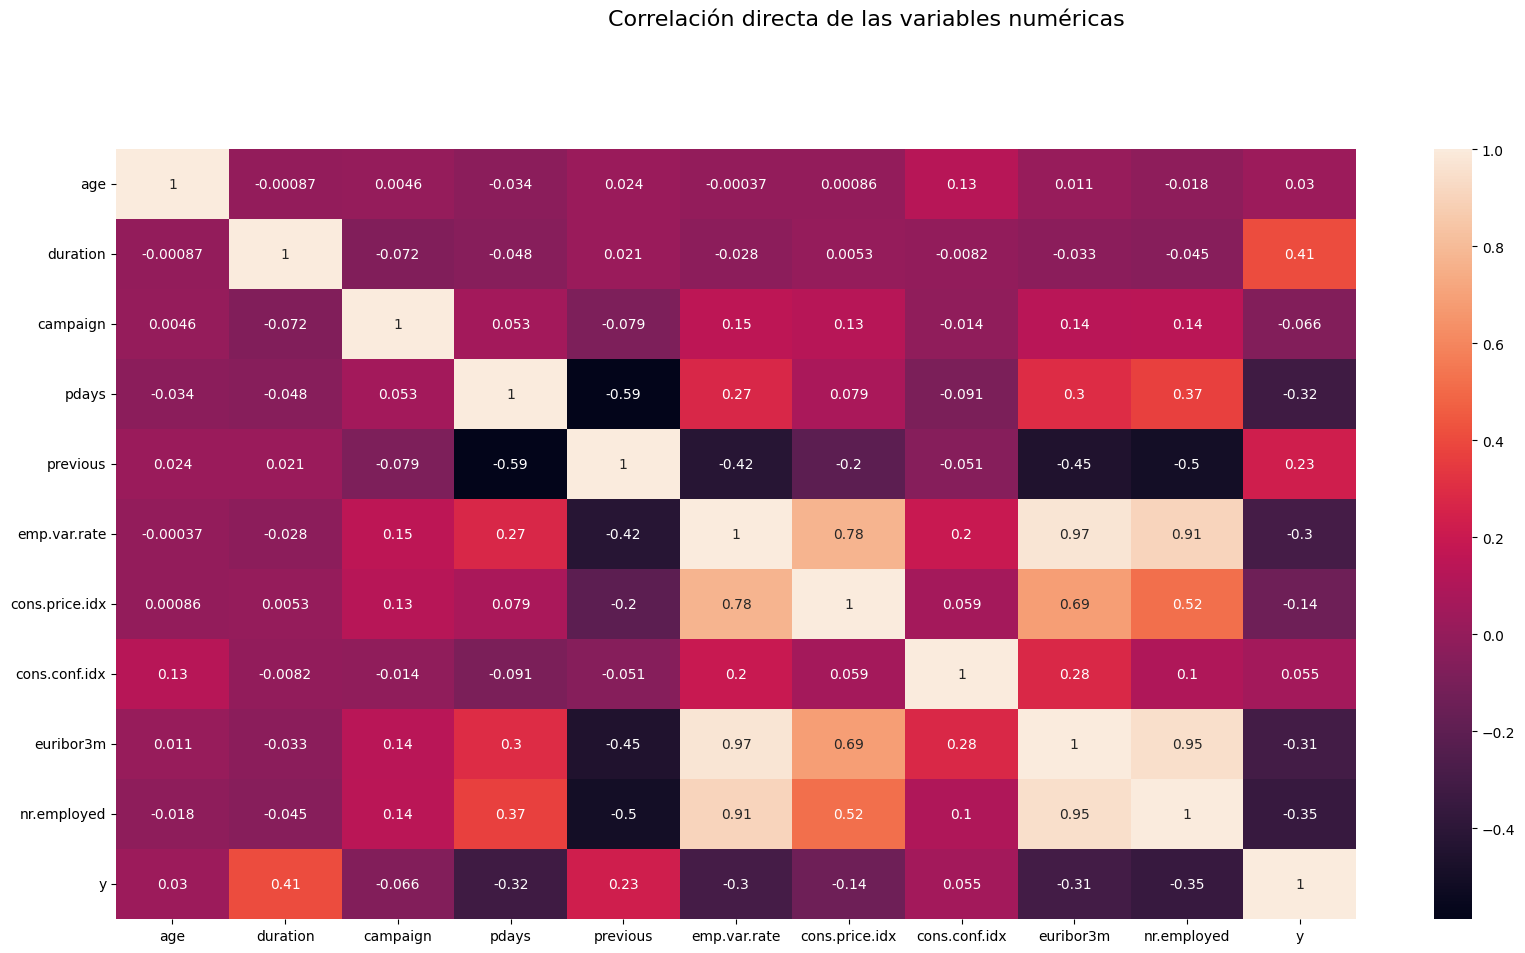

In [399]:
# Analizando la correlación de las categorías numéricas
plt.figure(figsize=(20, 10))
sns.heatmap(bank_marketing.corr(numeric_only=True), annot=True)
plt.suptitle('Correlación directa de las variables numéricas', y=1.02, size=16)
plt.show()

#### Matriz Phi-K: Explorando Asociaciones No Lineales en el Conjunto de Datos

La matriz Phi analiza y mide asociaciones no lineales entre variables. Es especialmente útil cuando se trabaja con variables categóricas, permite cuantificar la fuerza y la dirección de las relaciones entre estas variables. La matriz Phi examina la dependencia entre pares de variables categóricas, proporcionando información sobre la presencia y la intensidad de asociaciones no lineales en el conjunto de datos.

* Se observa una correlación significativa y superposición entre las variables Housing (préstamo de vivienda) y Loan (préstamo personal). Por consiguiente, he tomado la decisión de eliminar la columna "Loan", ya que, además, presenta una correlación directa más baja con la variable objetivo.

* De manera similar, la variable Month muestra una fuerte correlación con Cons.conf.idx (índice de confianza del consumidor) y Emp.var.rate (tasa de variación del empleo). Dado que la correlación con la variable objetivo es menor para "Month", he elegido eliminar esta columna. Esta elección se justifica, ya que el estado de la economía puede tener una relevancia superior al mes en el que se realiza el contacto.

interval columns not set, guessing: ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y']


<Axes: >

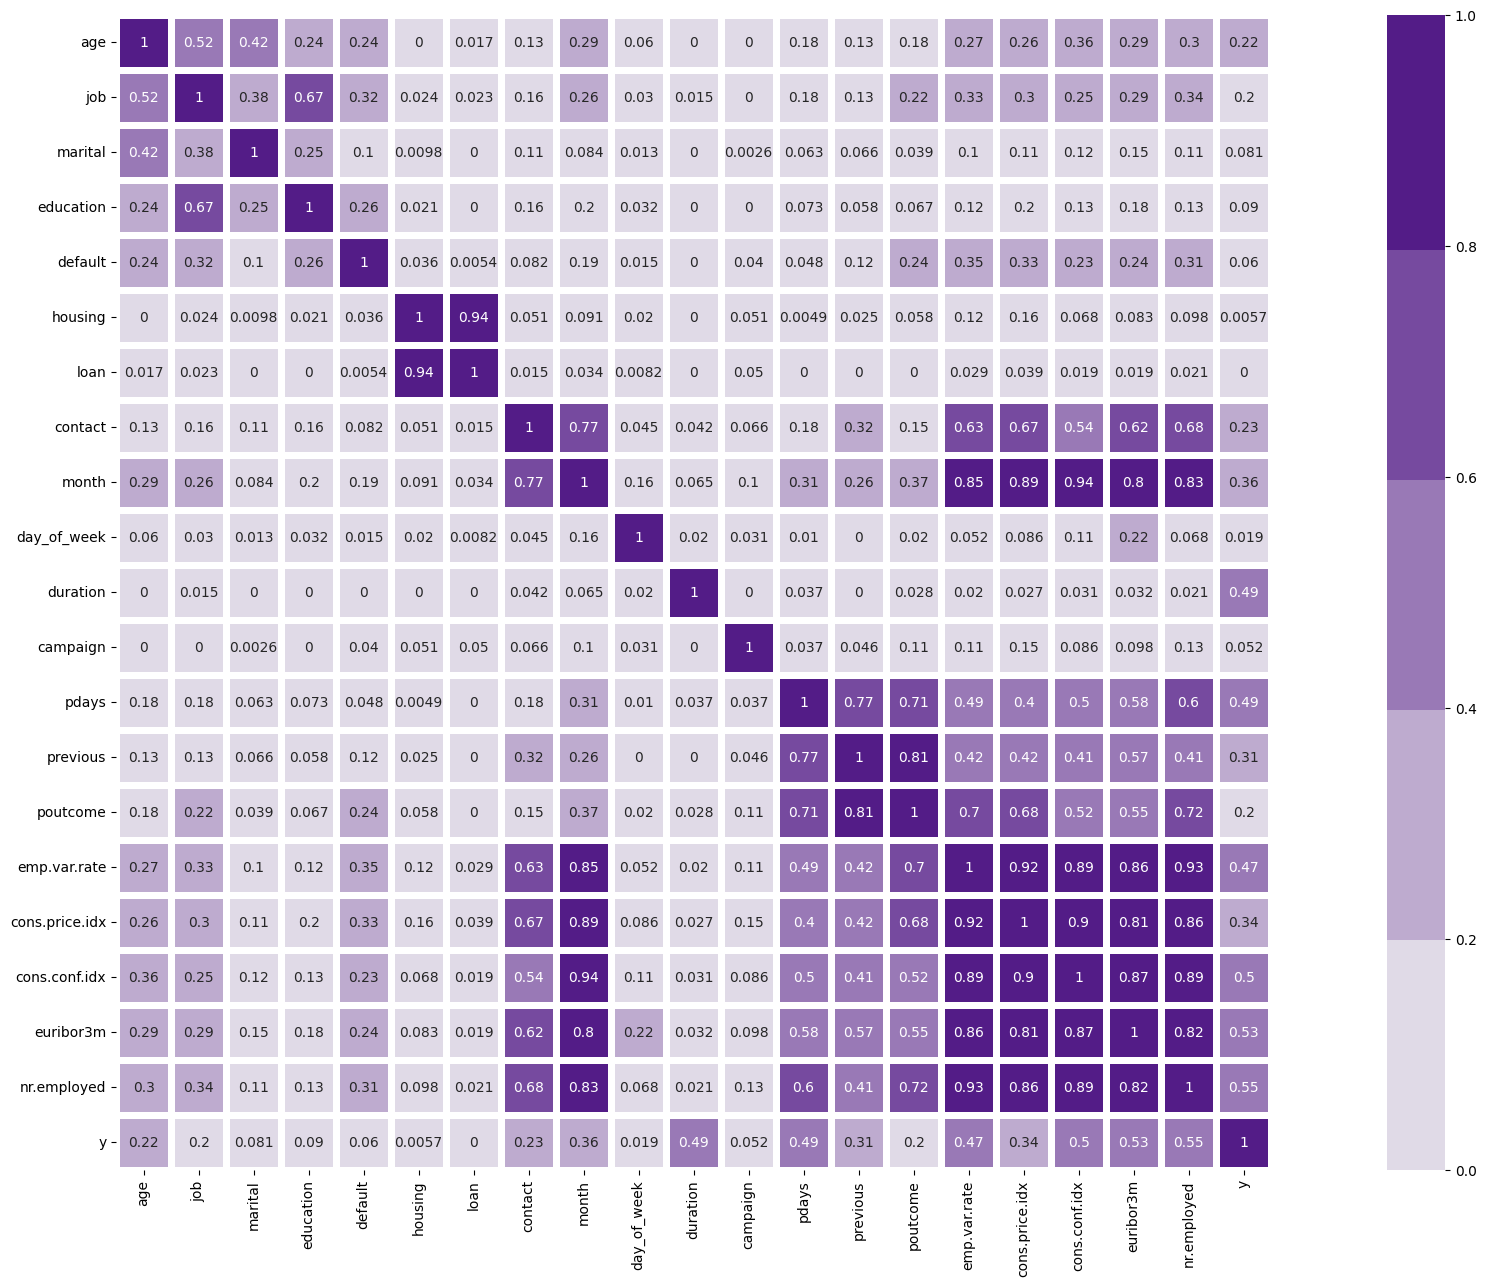

In [400]:
phik_matrix = bank_marketing.phik_matrix()
plt.figure(figsize=(30,15))
sns.heatmap(phik_matrix,
            vmin=0,
            vmax=1,
            center=0,
            cmap=sns.diverging_palette(145,280,s=85,l=25,n=10),
            square=True,
            annot=True,
            linewidths=5)

## 04. Modelado 1 - Definiendo las decisiones sobre a quién dirigir el primer contacto.

Este primer modelo se desarrolla con el propósito de brindar apoyo a los representantes bancarios en la predicción del éxito de las llamadas, con un enfoque específico en priorizar la primera llamada sobre otras. En términos sencillos, el objetivo principal es otorgar prioridad a aquellas llamadas que presenten una probabilidad más elevada de éxito. Esta iniciativa busca mejorar la eficiencia y la efectividad de las interacciones telefónicas, permitiendo a los representantes dirigir sus esfuerzos hacia contactos con mayores posibilidades de resultar en un resultado positivo.

Se emplea la métrica de recall cómo métrica clave debido a la naturaleza específica del objetivo: priorizar la primera llamada. El recall mide la capacidad del modelo para capturar correctamente los casos positivos. En este contexto, un alto recall significa que el modelo identifica con precisión las llamadas exitosas, lo cual es crucial para lograr el objetivo de asignar prioridad a las llamadas con mayor probabilidad de éxito. Priorizar el recall ayuda a minimizar la posibilidad de pasar por alto oportunidades valiosas en la primera interacción, contribuyendo así a la eficacia del modelo en la tarea específica planteada.

### Feature engineering

In [401]:
# Drop de columnas categóricas no útiles para el  modelo
bank_marketing.drop(['contact', 'month', 'day_of_week', 'duration', 
                     'campaign', 'loan', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 
                     'pdays', 'previous', 'nr.employed'], axis=1, inplace=True)


In [402]:
bank_marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        41188 non-null  int64  
 1   job        41188 non-null  object 
 2   marital    41188 non-null  object 
 3   education  41188 non-null  object 
 4   default    41188 non-null  object 
 5   housing    41188 non-null  object 
 6   poutcome   41188 non-null  object 
 7   euribor3m  41188 non-null  float64
 8   y          41188 non-null  int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 2.8+ MB


In [403]:
# Utilizo .getdummies para pasar los valores categóricos a numéricos (one-hot encoding)
categorical_columns = ['job', 'marital', 'housing', 'poutcome', 'education', 'default']

bank_marketing_encoded = pd.get_dummies(bank_marketing, columns=categorical_columns, dtype=bool)
bank_marketing_encoded = bank_marketing_encoded.astype(int)

In [404]:
bank_marketing_encoded

,age,euribor3m,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,...,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes
0,56,4,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,57,4,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2,37,4,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
3,40,4,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,56,4,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,1,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
41184,46,1,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
41185,56,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
41186,44,1,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


In [405]:
bank_marketing_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 36 columns):
 #   Column                         Non-Null Count  Dtype
---  ------                         --------------  -----
 0   age                            41188 non-null  int64
 1   euribor3m                      41188 non-null  int64
 2   y                              41188 non-null  int64
 3   job_admin.                     41188 non-null  int64
 4   job_blue-collar                41188 non-null  int64
 5   job_entrepreneur               41188 non-null  int64
 6   job_housemaid                  41188 non-null  int64
 7   job_management                 41188 non-null  int64
 8   job_retired                    41188 non-null  int64
 9   job_self-employed              41188 non-null  int64
 10  job_services                   41188 non-null  int64
 11  job_student                    41188 non-null  int64
 12  job_technician                 41188 non-null  int64
 13  job_unemployed  

### División del dataset: train y test

In [406]:
x = bank_marketing_encoded.drop('y', axis=1)
y = bank_marketing_encoded['y']

In [407]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

### Balancear variable target: undersampling

In [408]:
bank_marketing_encoded['y'].value_counts()

y
0    36548
1     4640
Name: count, dtype: int64

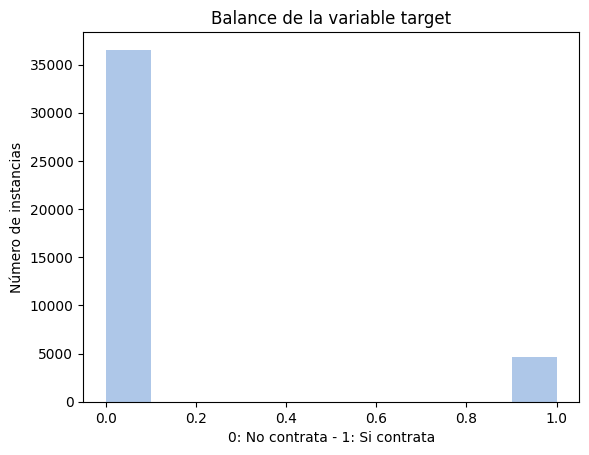

In [409]:
plt.hist(bank_marketing_encoded['y'], color=colores[0])
plt.xlabel('0: No contrata - 1: Si contrata')
plt.ylabel('Número de instancias')
plt.title('Balance de la variable target')
plt.show()

El conjunto de datos exhibe una asimetría. Mi objetivo es predecir si una persona contratará un depósito a plazo fijo o no. Sin embargo, al entrenar el modelo con un conjunto de datos en el que la mayoría de los contactados no ha contratado, la predicción tiende a ser sesgada hacia la negación

Para abordar este desafío, considero varias opciones:

* **Conseguir más datos**: Aunque sería la solución ideal, no es viable en este contexto.
* **Rebalanceo de Datos**: Puedo optar por el oversampling, que consiste en aumentar el número de instancias de la clase minoritaria, o el undersampling, que implica reducir la cantidad de datos de la clase mayoritaria. 
* **Generación de Datos Sintéticos**: Utilizar funciones de bibliotecas como sklearn, como SMOTE (Synthetic Minority Over-sampling Technique), que generan datos sintéticos para la clase minoritaria.
* **Pesos en las Clases**: Se puede aplicar un peso diferente a cada clase mediante el parámetro class_weight para lograr un equilibrio más justo en el modelo.

Después de realizar diversas pruebas, he observado que, en este escenario, la opción más eficiente resulta ser el **undersampling**.

In [410]:
# Undersampling del dataset
rus = RandomUnderSampler(sampling_strategy={0: 4529, 1: 3705}, random_state=42)
X_rus, y_rus = rus.fit_resample(x_train, y_train)

Text(0.5, 1.0, 'Target después del undersampling')

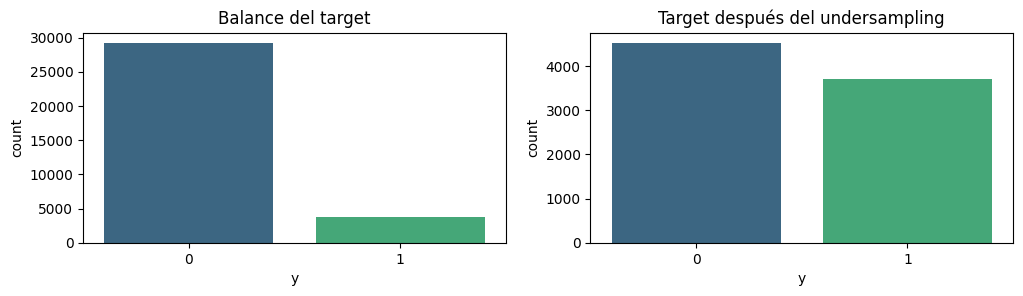

In [411]:
# Frecuencia de las clases antes del balanceo
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
sns.countplot(x=y_train, palette='viridis')
plt.title('Balance del target')

# Frecuencia de las clases después del undersampling
plt.subplot(2, 2, 2)
sns.countplot(x=y_rus, palette='viridis')
plt.title('Target después del undersampling')

### Modelado

In [412]:
# Define el pipeline
pipe = Pipeline(steps=[
    # ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier()) 
])

# Parámetros para Random Forest
random_forest_params = {
    'classifier': [RandomForestClassifier()],
    'classifier__n_estimators': [20, 50, 100, 200],
    'classifier__max_features': [1, 2, 3],
    'classifier__max_depth': [2, 3, 4, 5]
}

# Parámetros para Gradient Boosting
gradient_boosting_param = {
    'classifier': [GradientBoostingClassifier()],
    'classifier__n_estimators': [20, 50, 100, 150, 200],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [2, 3, 4, 5]
}


xgb_param = {
    'classifier': [XGBClassifier()],
    'classifier__n_estimators': [25, 50, 75],
    'classifier__learning_rate': [0.03, 0.07, 0.08, 0.1],
    'classifier__max_depth': [4, 5, 7],
    'classifier__gamma': [0.75, 0.80, 0.90,]
}

# Lista de todos los clasificadores con sus parámetros
search_space = [
    random_forest_params,
    gradient_boosting_param,
    xgb_param,
]

# Se crea el gridsearch indicándole que trabaje con un pipeline y que pruebe todos los parámetros y modelos antes definidos
clf_1 = GridSearchCV(estimator=pipe, param_grid=search_space, cv=10, scoring='recall', n_jobs=6)

# Se entrena el gridsearch
clf_1.fit(X_rus, y_rus)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('classifier',
                                        RandomForestClassifier())]),
             n_jobs=6,
             param_grid=[{'classifier': [RandomForestClassifier()],
                          'classifier__max_depth': [2, 3, 4, 5],
                          'classifier__max_features': [1, 2, 3],
                          'classifier__n_estimators': [20, 50, 100, 200]},
                         {'classifier': [GradientBoostingClassifier()],
                          'classifier__learning_rate': [0.01, 0.1, 0.2],...
                                                       max_depth=None,
                                                       max_leaves=None,
                                                       min_child_weight=None,
                                                       missing=nan,
                                                       monotone_constraints=None,
                                                       multi_strategy=None,
                                                       n_estimators=None,
                                                       n_jobs=None,
                                                       num_parallel_tree=None,
                                                       random_state=None, ...)],
                          'classifier__gamma': [0.75, 0.8, 0.9],
                          'classifier__learning_rate': [0.03, 0.07, 0.08, 0.1],
                          'classifier__max_depth': [4, 5, 7],
                          'classifier__n_estimators': [25, 50, 75]}],
             scoring='recall')

In [413]:
print(f'{clf_1.best_estimator_}\n')
print(f'{clf_1.best_params_}\n')
print(f'{clf_1.best_score_}\n')

Pipeline(steps=[('classifier',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=2))])

{'classifier': GradientBoostingClassifier(), 'classifier__learning_rate': 0.01, 'classifier__max_depth': 2, 'classifier__n_estimators': 100}

0.713099730458221



In [414]:
X_rus_2 = X_rus.copy()
y_rus_2 = y_rus.copy()

In [415]:
X_rus_2.to_csv('../notebooks/x_rus_train_modelo1.csv', index=False)

In [416]:
# Crear el modelo
clf = GradientBoostingClassifier(learning_rate= 0.01,
    max_depth= 2,
    n_estimators= 100)

In [417]:
# Entrenar el modelo ganador
clf.fit(X_rus_2, y_rus_2)


GradientBoostingClassifier(learning_rate=0.01, max_depth=2)

* Modelo de Gradient Boosting con una tasa de aprendizaje baja, árboles de decisión poco profundos y un total de 100 árboles en el ensemble.
* Gradient Boosting es un algoritmo de aprendizaje automático que mejora de manera iterativa la precisión de un modelo al enfocarse en corregir los errores de predicción anteriores.

In [418]:
pickle.dump(clf, open('../source/Modelo_1.pkl', 'wb'))

#### Analizando las métricas clave: train vs. test

* La métrica de recall en ambos conjuntos es relativamente baja. Esto indica que el modelo podría estar perdiendo algunas instancias de la clase positiva, lo cual podría ser problemático dependiendo del contexto.
* Ambos valores de recall son relativamente cercanos, indicando una consistencia en la capacidad del modelo para identificar correctamente las instancias positivas entre los dos conjuntos de datos. 
* La consistencia en el rendimiento del recall podría indicar que el modelo generaliza de manera relativamente coherente a nuevos datos, al menos en términos de la capacidad para identificar instancias positivas.
* La precisión en el conjunto de prueba es relativamente baja, indicando que de las instancias que el modelo predice como positivas, solo alrededor del 43.33% realmente pertenecen a la clase positiva. Esto sugiere que hay margen de mejora en la precisión de las predicciones positivas.

In [419]:
accuracy_train_1 = accuracy_score(y_rus_2, clf.predict(X_rus_2))
precision_train_1 = precision_score(y_rus_2, clf.predict(X_rus_2))
recall_train_1 = recall_score(y_rus_2, clf.predict(X_rus_2))


accuracy_test_1 = accuracy_score(y_test, clf.predict(x_test))
precision_test_1 = precision_score(y_test, clf.predict(x_test))
recall_test_1 = recall_score(y_test, clf.predict(x_test))

print('TRAIN')
print(f'Accuracy: {accuracy_train_1}')
print (f'Precision: {precision_train_1}')
print(f'Recall: {recall_train_1}\n')

print('TEST')
print(f'Accuracy: {accuracy_test_1}')
print (f'Precision: {precision_test_1}')
print(f'Recall: {recall_test_1}')

TRAIN
Accuracy: 0.7167840660675249
Precision: 0.6755305548453081
Recall: 0.7130904183535762

TEST
Accuracy: 0.7166788055353241
Precision: 0.24254692675745307
Recall: 0.704812834224599


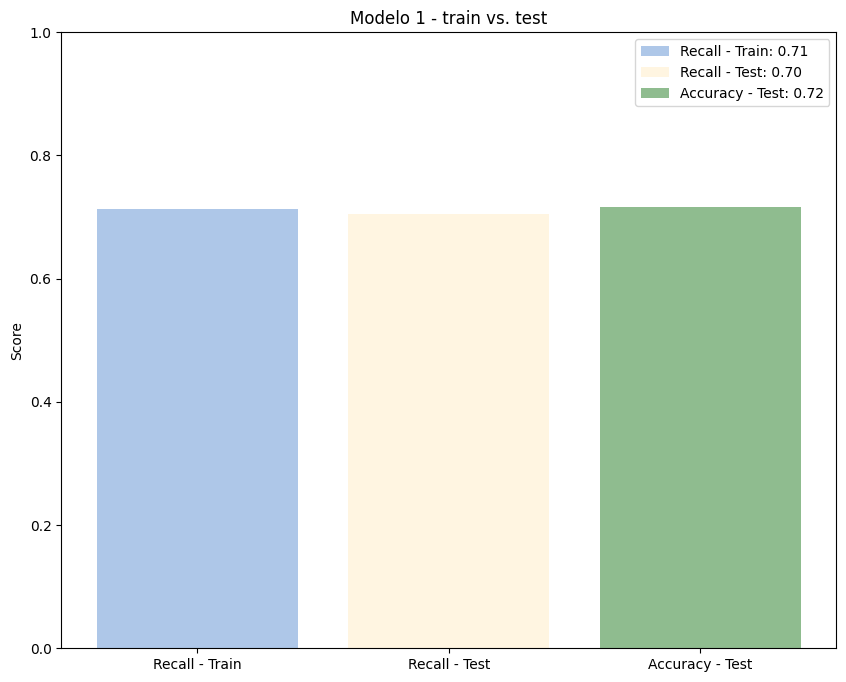

In [420]:
# visualizar las métricas de clasificación
fig, ax = plt.subplots(figsize=(10,8))

ax.bar('Recall - Train', recall_train_1, color=colores[0], label=f'Recall - Train: {recall_train_1:.2f}')
ax.bar('Recall - Test', recall_test_1, color=colores[2], label=f'Recall - Test: {recall_test_1:.2f}')
ax.bar('Accuracy - Test', accuracy_test_1, color=colores[1], label=f'Accuracy - Test: {accuracy_test_1:.2f}')

ax.set_ylim(0, 1)
ax.set_ylabel('Score')
ax.set_title('Modelo 1 - train vs. test')
ax.legend()

plt.show()

In [421]:
print(f'Informe de clasificación: {classification_report(y_test, clf.predict(x_test))}')

Informe de clasificación:               precision    recall  f1-score   support

           0       0.95      0.72      0.82      7303
           1       0.24      0.70      0.36       935

    accuracy                           0.72      8238
   macro avg       0.60      0.71      0.59      8238
weighted avg       0.87      0.72      0.77      8238



#### Matriz de Confusión

El propósito principal de una matriz de confusión es observar cómo se desempeña nuestro modelo al clasificar a los posibles clientes que probablemente se suscribirán a un depósito a plazo. En la matriz de confusión, veremos cuatro términos: Verdaderos Positivos, Falsos Positivos, Verdaderos Negativos y Falsos Negativos.

* **Positivo/Negativo: Tipo de Clase (etiqueta) ["No", "Sí"] Verdadero/Falso**: Clasificado correctamente o incorrectamente por el modelo.

* **Verdaderos Negativos (Cuadro Superior Izquierdo)**: Es la cantidad de clasificaciones correctas de la clase "No" o clientes potenciales que no están dispuestos a suscribirse a un depósito a plazo.

* **Falsos Negativos (Cuadro Superior Derecho)**: Es la cantidad de clasificaciones incorrectas de la clase "No" o clientes potenciales que no están dispuestos a suscribirse a un depósito a plazo.

* **Falsos Positivos (Cuadro Inferior Izquierdo)**: Es la cantidad de clasificaciones incorrectas de la clase "Sí" o clientes potenciales que están dispuestos a suscribirse a un depósito a plazo.

* **Verdaderos Positivos (Cuadro Inferior Derecho)**: Es la cantidad de clasificaciones correctas de la clase "Sí" o clientes potenciales que están dispuestos a suscribirse a un depósito a plazo.

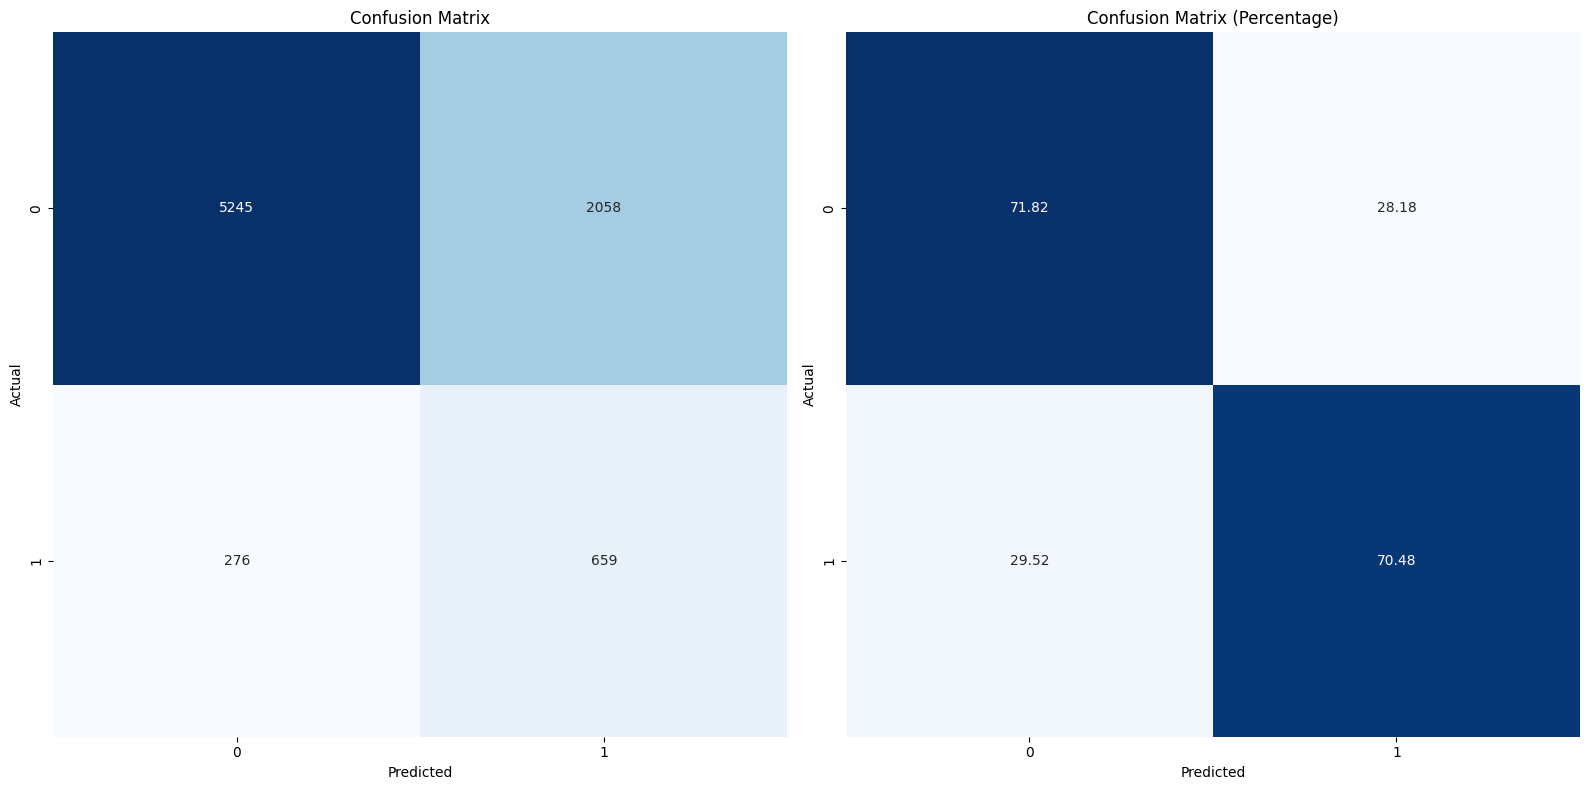

In [422]:
# Matriz de Confusión
y_pred = clf.predict(x_test)

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Primer gráfico: Matriz de confusión original
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False, ax=axs[0])
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('Actual')
axs[0].set_title('Confusion Matrix')

# Segundo gráfico: Matriz de confusión con porcentajes
row_sums = confusion_matrix(y_test, y_pred).sum(axis=1, keepdims=True)
normalized_conf_matrix = confusion_matrix(y_test, y_pred) / row_sums.astype(float) * 100 

sns.heatmap(normalized_conf_matrix, annot=True, fmt='.2f', cmap='Blues', cbar=False, ax=axs[1])
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('Actual')
axs[1].set_title('Confusion Matrix (Percentage)')

plt.tight_layout()
plt.show()

#### **Curva de precisión y recuperación (recall)**


En el contexto de la clasificación binaria, la precisión y la recuperación (recall) son dos métricas importantes que están inversamente relacionadas:

* **Precisión (Precision)**: Mide la proporción de instancias positivas identificadas correctamente entre todas las instancias identificadas como positivas.

* **Recuperación (Recall)**: Mide la proporción de instancias positivas identificadas correctamente entre todas las instancias positivas en el conjunto de datos.

Al ajustar el umbral de decisión de un clasificador, puedes aumentar la precisión a expensas de la recuperación y viceversa. Esto se ilustra en la curva Precision-Recall, que representa la relación entre la precisión y la recuperación para diferentes umbrales de decisión.

El gráfico muestra cómo cambiar el umbral afecta la precisión y la recuperación. Al aumentar el umbral, es más probable que una predicción positiva sea correcta (mayor precisión), pero también es más probable que se omitan instancias positivas (menor recuperación). A la inversa, al disminuir el umbral, se identificarán más instancias positivas (mayor recuperación), pero a costa de una precisión más baja.

/var/folders/0c/09471fw96k708myy5dkx10_h0000gn/T/ipykernel_3144/1998888394.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(thresholds, precisions[:-1], "r--", color=colores[0], label="Precisions")


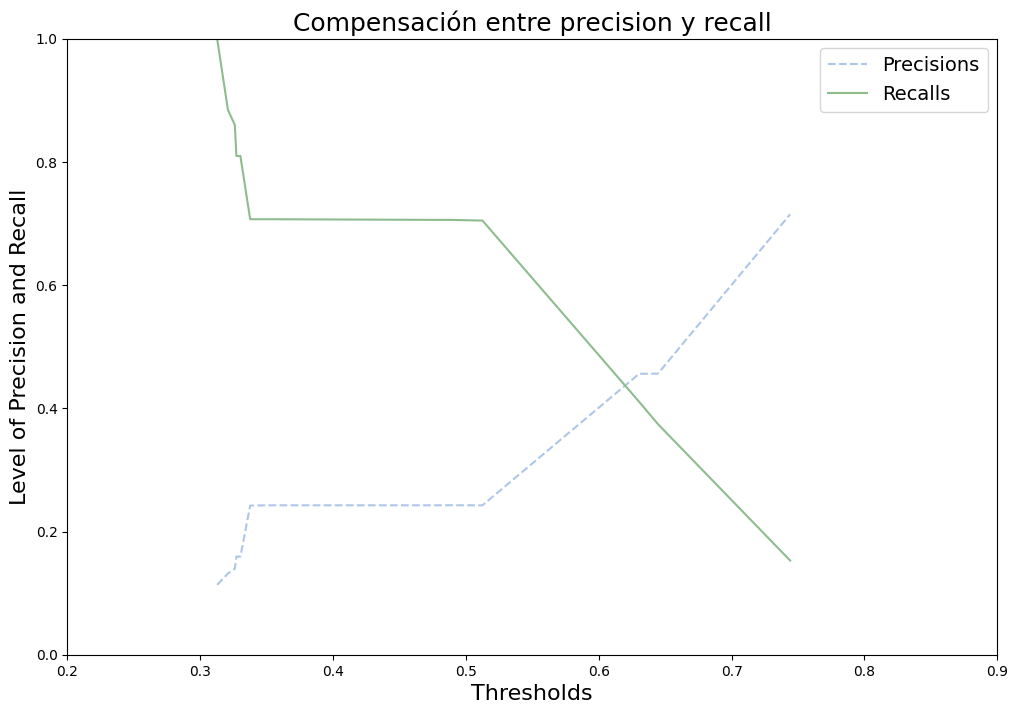

In [423]:
# Precision and recall tradeoff
y_scores = clf.predict_proba(x_test)[:, 1]
precisions, recalls, threshold = precision_recall_curve(y_test, y_scores)

def precision_recall_curve(precisions, recalls, thresholds):
    fig, ax = plt.subplots(figsize=(12,8))
    plt.plot(thresholds, precisions[:-1], "r--", color=colores[0], label="Precisions")
    plt.plot(thresholds, recalls[:-1], color=colores[1], label="Recalls")
    plt.title("Compensación entre precision y recall", fontsize=18)
    plt.ylabel("Level of Precision and Recall", fontsize=16)
    plt.xlabel("Thresholds", fontsize=16)
    plt.legend(loc="best", fontsize=14)
    plt.xlim([0.2, 0.9])
    plt.ylim([0, 1])
    plt.axvline(x=0.13, linewidth=3, color="#0B3861")
    
precision_recall_curve(precisions, recalls, threshold)
plt.show()

#### Curva ROC

La Curva ROC (Receiver Operating Characteristic) es una representación gráfica que ilustra el rendimiento de un modelo de clasificación binaria en diferentes niveles de umbral de decisión. Es una herramienta comúnmente utilizada para evaluar la capacidad de un modelo para distinguir entre dos clases: positiva y negativa.

* La Curva ROC representa la tasa de verdaderos positivos (Sensibilidad o Recall) en el eje y (vertical) y la tasa de falsos positivos en el eje x (horizontal). Aquí hay algunos términos clave asociados con la Curva ROC:

* Tasa de Verdaderos Positivos (Recall o Sensibilidad): Mide la proporción de instancias positivas que son correctamente clasificadas como positivas por el modelo.

* Tasa de Falsos Positivos: Mide la proporción de instancias negativas que son incorrectamente clasificadas como positivas por el modelo.

La Curva ROC visualiza cómo cambia la relación entre la Sensibilidad y la Especificidad a medida que se ajusta el umbral de decisión del modelo. Un modelo ideal tendría una curva que se elevara rápidamente hacia la esquina superior izquierda, indicando altas tasas de verdaderos positivos con bajas tasas de falsos positivos. La línea diagonal en la curva ROC representa el rendimiento al azar.

La área bajo la curva (AUC-ROC) es una métrica numérica derivada de la Curva ROC y proporciona una medida cuantitativa de la calidad global del modelo. Un AUC-ROC más cercano a 1 indica un mejor rendimiento en la clasificación.



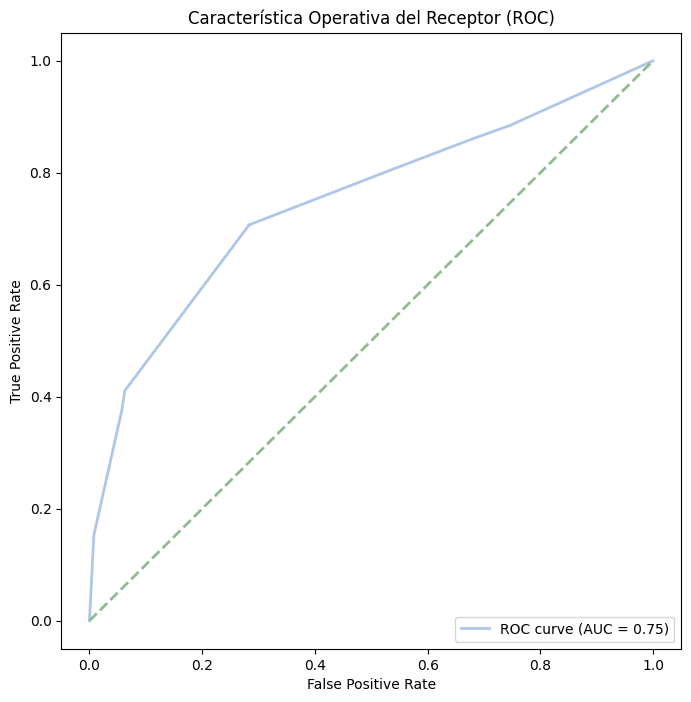

In [424]:
y_prob = clf.predict_proba(x_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))

plt.plot(fpr, tpr, color=colores[0], lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color=colores[1], lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Característica Operativa del Receptor (ROC)')
plt.legend(loc='lower right')

plt.show()

### Feature importances

El análisis de importancia de características (feature importances) indica cómo cada característica contribuye a las predicciones del modelo. En este caso las características más importantes son:

* **euribor3m (0.924085)**: La tasa diaria del euribor es la característica más influyente, con una alta importancia de 0.92.

* **poutcome_success (0.072090)**: El resultado exitoso de la campaña de marketing anterior también tiene una importancia significativa, aunque mucho menor en comparación con euribor3m.

Las demás características y variables tienen importancia cero según este modelo, lo que significa que, según la evaluación de este modelo en particular, no influyen en las predicciones.

In [425]:
importances = clf.feature_importances_

df_importances = pd.DataFrame({'Feature': x_test.columns, 'Importance': clf.feature_importances_})
df_importances = df_importances.sort_values(by='Importance', ascending=False)

df_importances

,Feature,Importance
1,euribor3m,0.924085
23,poutcome_success,0.072090
0,age,0.003826
32,default_no,0.000000
31,education_unknown,0.000000
30,education_university.degree,0.000000
29,education_professional.course,0.000000
28,education_illiterate,0.000000
27,education_high.school,0.000000
18,housing_no,0.000000


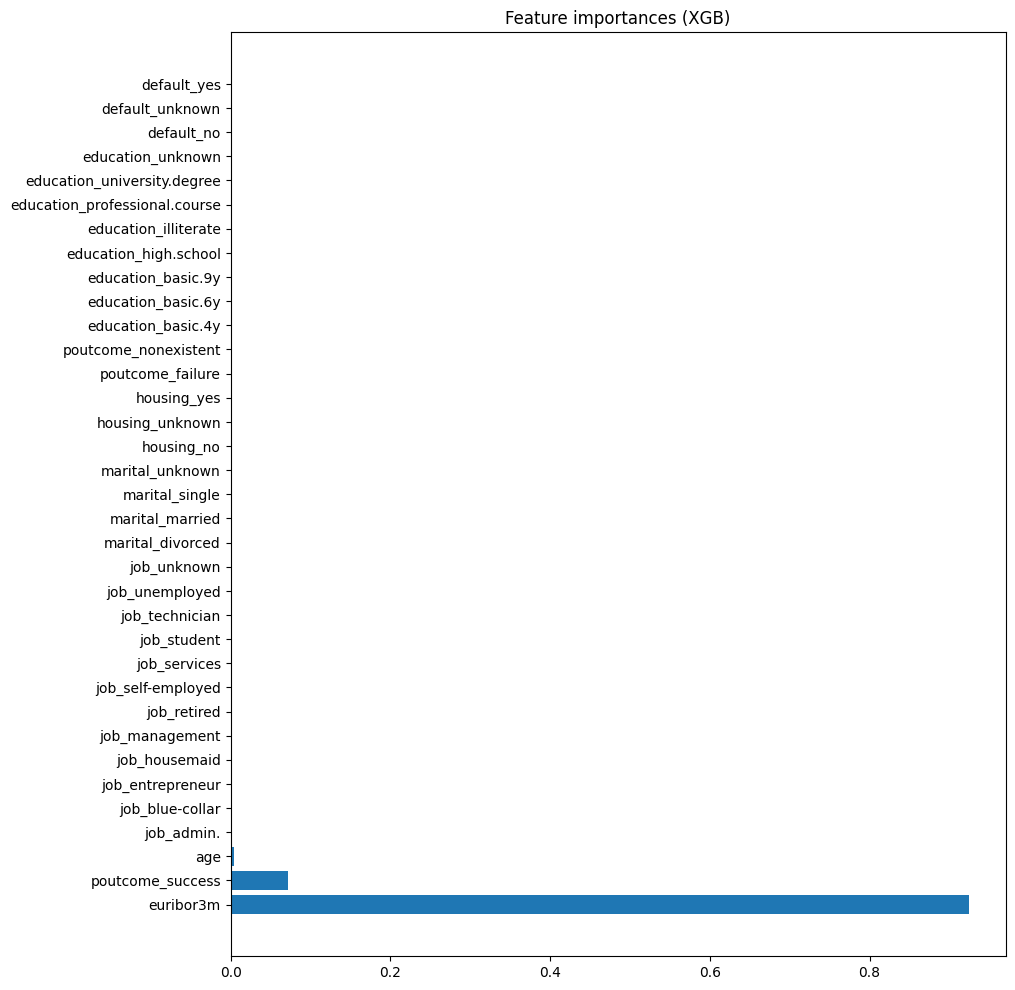

In [426]:
# Visualizar las feature importances
headers = ["name", "score"]
values = sorted(zip(X_rus_2.columns, clf.feature_importances_), key=lambda x: x[1] * -1)
xgb_feature_importances = pd.DataFrame(values, columns=headers)

plt.figure(figsize=(10, 12))
y_pos = np.arange(0, len(xgb_feature_importances))
plt.barh(y_pos, xgb_feature_importances['score'])
plt.yticks(y_pos, xgb_feature_importances['name'])
plt.title('Feature importances (XGB)')

plt.show()

## 05. Modelado 2 - Priorizando la segunda llamada con mayor potencial de contratación

### Lectura del dataset

In [427]:
df_llamada_1 = pd.read_csv('../data/bank-additional-full.csv', sep=";")

### Feature engineering

In [428]:
# Crear columna 'Firs_call'
df_llamada_1['first_call'] = df_llamada_1['duration'] // df_llamada_1['campaign']

In [429]:
df_llamada_1['first_call']

0        261
1        149
2        226
3        151
4        307
        ... 
41183    334
41184    383
41185     94
41186    442
41187     79
Name: first_call, Length: 41188, dtype: int64

In [430]:
df_llamada_1.head(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,first_call
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,261
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,149
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,226
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,151
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,307
5,45,services,married,basic.9y,unknown,no,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,198
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,139
7,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,217
8,24,technician,single,professional.course,no,yes,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,380
9,25,services,single,high.school,no,yes,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,50


In [431]:
# Drop de columnas categóricas no útiles para el  modelo
df_llamada_1.drop(['month', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'nr.employed', 'pdays', 'duration', 'campaign'], axis=1, inplace=True)

In [432]:
# De categórica a numérica
df_llamada_1['y'] = df_llamada_1['y'].map({'yes': 1, 'no': 0})
df_llamada_1['poutcome'] = df_llamada_1['poutcome'].map({'nonexistent': 0 , 'failure': 1, 'success': 2})

categorical = ['job', 'marital', 'housing', 'education', 'contact', 'day_of_week', 'default', 'loan', 'poutcome' ]

df_llamada_1_encoded = pd.get_dummies(df_llamada_1, columns=categorical, dtype=bool)

In [433]:
x = df_llamada_1_encoded.drop('y', axis=1)
y = df_llamada_1_encoded['y']

### División del dataset: train y test

In [434]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

### Balancear variable target: undersampling

In [435]:
rus = RandomUnderSampler(sampling_strategy={0: 4529, 1: 3705}, random_state=42)
X_rus, y_rus = rus.fit_resample(x_train, y_train)

### Modelado

In [436]:
# Define el pipeline
pipe = Pipeline(steps=[
    # ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier()) 
])

# Parámetros para Random Forest
random_forest_params = {
    'classifier': [RandomForestClassifier()],
    'classifier__n_estimators': [20, 50, 100, 200],
    'classifier__max_features': [1, 2, 3],
    'classifier__max_depth': [2, 3, 4, 5]
}

# Parámetros para Gradient Boosting
gradient_boosting_param = {
    'classifier': [GradientBoostingClassifier()],
    'classifier__n_estimators': [20, 50, 100, 150, 200],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [2, 3, 4, 5]
}


xgb_param = {
    'classifier': [XGBClassifier()],
    'classifier__n_estimators': [25, 50, 75],
    'classifier__learning_rate': [0.03, 0.07, 0.08, 0.1],
    'classifier__max_depth': [4, 5, 7],
    'classifier__gamma': [0.75, 0.80, 0.90,]
}

# Lista de todos los clasificadores con sus parámetros
search_space = [
    random_forest_params,
    gradient_boosting_param,
    xgb_param,
]

# Se crea el gridsearch indicándole que trabaje con un pipeline y que pruebe todos los parámetros y modelos antes definidos
clf_call_1 = GridSearchCV(estimator=pipe, param_grid=search_space, cv=10, scoring='recall', n_jobs=6)

# Se entrena el gridsearch
clf_call_1.fit(X_rus, y_rus)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('classifier',
                                        RandomForestClassifier())]),
             n_jobs=6,
             param_grid=[{'classifier': [RandomForestClassifier()],
                          'classifier__max_depth': [2, 3, 4, 5],
                          'classifier__max_features': [1, 2, 3],
                          'classifier__n_estimators': [20, 50, 100, 200]},
                         {'classifier': [GradientBoostingClassifier()],
                          'classifier__learning_rate': [0.01, 0.1, 0.2],...
                                                       max_depth=None,
                                                       max_leaves=None,
                                                       min_child_weight=None,
                                                       missing=nan,
                                                       monotone_constraints=None,
                                                       multi_strategy=None,
                                                       n_estimators=None,
                                                       n_jobs=None,
                                                       num_parallel_tree=None,
                                                       random_state=None, ...)],
                          'classifier__gamma': [0.75, 0.8, 0.9],
                          'classifier__learning_rate': [0.03, 0.07, 0.08, 0.1],
                          'classifier__max_depth': [4, 5, 7],
                          'classifier__n_estimators': [25, 50, 75]}],
             scoring='recall')

In [437]:
print(f'{clf_call_1.best_estimator_}\n')
print(f'{clf_call_1.best_params_}\n')
print(f'{clf_call_1.best_score_}\n')

Pipeline(steps=[('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0.8, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.08,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=50

In [438]:
X_rus_3 = X_rus.copy()
y_rus_3 = y_rus.copy()

In [439]:
# Crear modelo
clf_call = XGBClassifier(learning_rate= 0.08,
    max_depth= 5,
    n_estimators= 50, 
    gamma= 0.8,)

In [440]:
clf_call.fit(X_rus_3, y_rus_3)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.8, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.08, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

* Modelo XGBoost configurado con una tasa de aprendizaje de 0.08, árboles de decisión poco profundos con una profundidad máxima de 5 y un total de 50 árboles en el ensemble. 
* XGBoost, al igual que Gradient Boosting, es un algoritmo de aprendizaje automático que mejora de manera iterativa la precisión del modelo. Su enfoque se centra en corregir los errores de predicción anteriores. 
* En este caso, la combinación de una tasa de aprendizaje moderada, árboles poco profundos y un número limitado de árboles en el ensemble busca lograr un equilibrio entre rendimiento y eficiencia en la construcción del modelo.

In [441]:
X_rus_3.to_csv('../notebooks/x_rus_train_modelo2.csv', index=False)

In [442]:
pickle.dump(clf_call, open('../source/modelo_2.pkl', 'wb'))

#### Analizando las métricas clave: train vs. test

El modelo presenta un buen rendimiento global y es especialmente fuerte en la identificación de instancias positivas, como se evidencia por la alta métrica de recall.

* **Precisión global**: El modelo muestra una precisión global sólida tanto en el conjunto de entrenamiento (84.21%) como en el conjunto de prueba (82.85%). Esto sugiere que el modelo generaliza bien a nuevos datos sin perder significativamente en términos de precisión.

* **Precision en predicciones positivas**: Sin embargo, la precisión en las predicciones positivas es más baja en el conjunto de prueba (38.34%) en comparación con el conjunto de entrenamiento (81.10%). Esto indica que, en el conjunto de prueba, hay un mayor porcentaje de instancias predichas como positivas que no pertenecen realmente a la clase positiva.

**Recall en Predicciones Positivas**: La métrica de recall en las predicciones positivas es robusta y consistente entre el conjunto de entrenamiento (84.64%) y el conjunto de prueba (84.06%). Esto sugiere que el modelo es efectivo al identificar instancias positivas en ambos conjuntos.



In [445]:
accuracy_train_2 = accuracy_score(y_rus_3, clf_call.predict(X_rus_3))
precision_train_2 = precision_score(y_rus_3, clf_call.predict(X_rus_3))
recall_train_2 = recall_score(y_rus_3, clf_call.predict(X_rus_3))

accuracy_test_2 = accuracy_score(y_test, clf_call.predict(x_test))
precision_test_2 = precision_score(y_test, clf_call.predict(x_test))
recall_test_2 = recall_score(y_test, clf_call.predict(x_test))

print('TRAIN')
print(f'Accuracy: {accuracy_train_2}')
print (f'Precision: {precision_train_2}')
print(f'Recall: {recall_train_2}\n')

print('TEST')
print(f'Accuracy: {accuracy_test_2}')
print (f'Precision: {precision_test_2}')
print(f'Recall: {recall_test_2}')

TRAIN
Accuracy: 0.8421180471216906
Precision: 0.8109645720196534
Recall: 0.8464237516869095

TEST
Accuracy: 0.8284777858703569
Precision: 0.38341463414634147
Recall: 0.8406417112299466


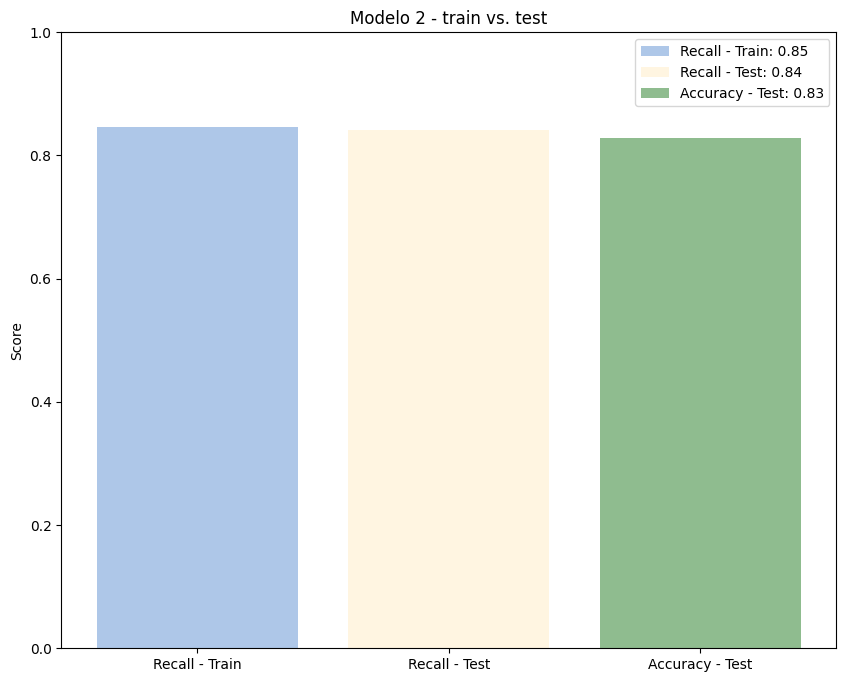

In [446]:
# visualizar las métricas de clasificación
fig, ax = plt.subplots(figsize=(10,8))

ax.bar('Recall - Train', recall_train_2, color=colores[0], label=f'Recall - Train: {recall_train_2:.2f}')
ax.bar('Recall - Test', recall_test_2, color=colores[2], label=f'Recall - Test: {recall_test_2:.2f}')
ax.bar('Accuracy - Test', accuracy_test_2, color=colores[1], label=f'Accuracy - Test: {accuracy_test_2:.2f}')

ax.set_ylim(0, 1)
ax.set_ylabel('Score')
ax.set_title('Modelo 2 - train vs. test')
ax.legend()

plt.show()

In [447]:
print(f'Informe de clasificación: {classification_report(y_test, clf_call.predict(x_test))}')

Informe de clasificación:               precision    recall  f1-score   support

           0       0.98      0.83      0.90      7303
           1       0.38      0.84      0.53       935

    accuracy                           0.83      8238
   macro avg       0.68      0.83      0.71      8238
weighted avg       0.91      0.83      0.85      8238



#### Matriz de confusión

El propósito principal de una matriz de confusión es observar cómo se desempeña nuestro modelo al clasificar a los posibles clientes que probablemente se suscribirán a un depósito a plazo. En la matriz de confusión, veremos cuatro términos: Verdaderos Positivos, Falsos Positivos, Verdaderos Negativos y Falsos Negativos.

* **Positivo/Negativo: Tipo de Clase (etiqueta) ["No", "Sí"] Verdadero/Falso**: Clasificado correctamente o incorrectamente por el modelo.

* **Verdaderos Negativos (Cuadro Superior Izquierdo)**: Es la cantidad de clasificaciones correctas de la clase "No" o clientes potenciales que no están dispuestos a suscribirse a un depósito a plazo.

* **Falsos Negativos (Cuadro Superior Derecho)**: Es la cantidad de clasificaciones incorrectas de la clase "No" o clientes potenciales que no están dispuestos a suscribirse a un depósito a plazo.

* **Falsos Positivos (Cuadro Inferior Izquierdo)**: Es la cantidad de clasificaciones incorrectas de la clase "Sí" o clientes potenciales que están dispuestos a suscribirse a un depósito a plazo.

* **Verdaderos Positivos (Cuadro Inferior Derecho)**: Es la cantidad de clasificaciones correctas de la clase "Sí" o clientes potenciales que están dispuestos a suscribirse a un depósito a plazo.

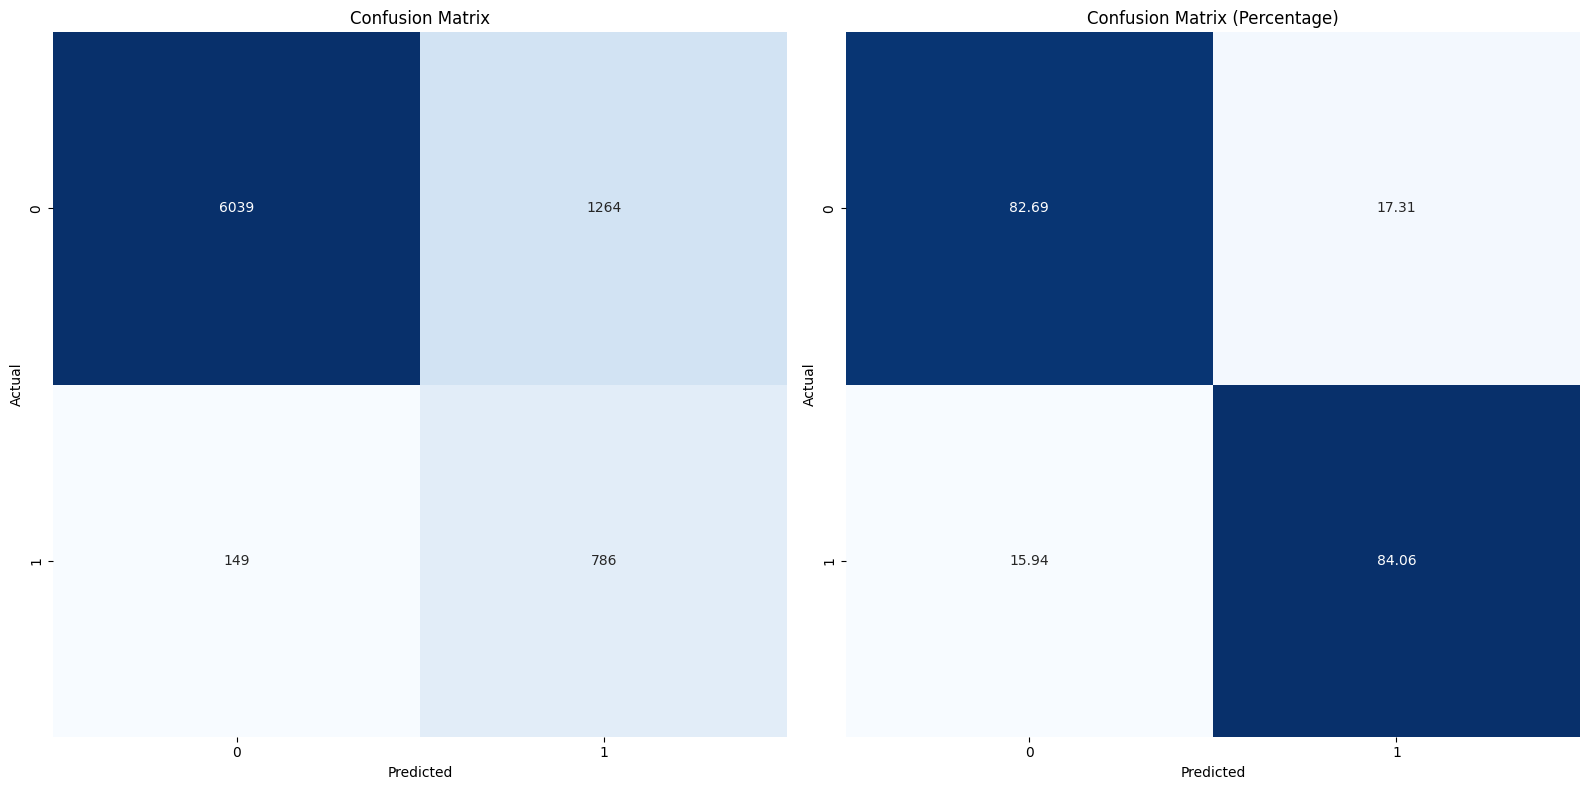

In [448]:
# Matriz de Confusión 
y_pred = clf_call.predict(x_test)

# Configurar la figura y los subgráficos
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Primer gráfico: Matriz de confusión original
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False, ax=axs[0])
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('Actual')
axs[0].set_title('Confusion Matrix')

# Segundo gráfico: Matriz de confusión con porcentajes
row_sums = confusion_matrix(y_test, y_pred).sum(axis=1, keepdims=True)
normalized_conf_matrix = confusion_matrix(y_test, y_pred) / row_sums.astype(float) * 100  # Convierte a porcentaje

sns.heatmap(normalized_conf_matrix, annot=True, fmt='.2f', cmap='Blues', cbar=False, ax=axs[1])
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('Actual')
axs[1].set_title('Confusion Matrix (Percentage)')

# Ajustar el diseño
plt.tight_layout()
plt.show()

#### Curva de precisión y recuperación (recall)


En el contexto de la clasificación binaria, la precisión y la recuperación (recall) son dos métricas importantes que están inversamente relacionadas:

* **Precisión (Precision)**: Mide la proporción de instancias positivas identificadas correctamente entre todas las instancias identificadas como positivas.

* **Recuperación (Recall)**: Mide la proporción de instancias positivas identificadas correctamente entre todas las instancias positivas en el conjunto de datos.

Al ajustar el umbral de decisión de un clasificador, puedes aumentar la precisión a expensas de la recuperación y viceversa. Esto se ilustra en la curva Precision-Recall, que representa la relación entre la precisión y la recuperación para diferentes umbrales de decisión.

El gráfico muestra cómo cambiar el umbral afecta la precisión y la recuperación. Al aumentar el umbral, es más probable que una predicción positiva sea correcta (mayor precisión), pero también es más probable que se omitan instancias positivas (menor recuperación). A la inversa, al disminuir el umbral, se identificarán más instancias positivas (mayor recuperación), pero a costa de una precisión más baja.

/var/folders/0c/09471fw96k708myy5dkx10_h0000gn/T/ipykernel_3144/3303104687.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(thresholds, precisions[:-1], "r--", color=colores[0], label="Precisions")


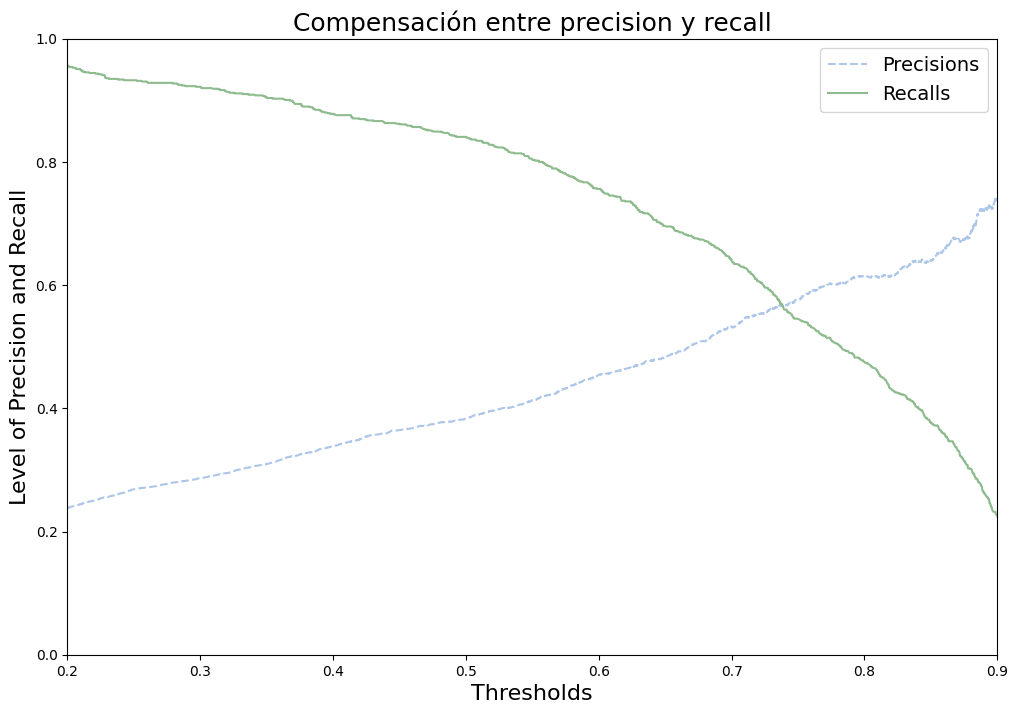

In [449]:
from sklearn.metrics import precision_recall_curve

y_scores = clf_call.predict_proba(x_test)[:, 1]
precisions, recalls, threshold = precision_recall_curve(y_test, y_scores)

def precision_recall_curve(precisions, recalls, thresholds):
    fig, ax = plt.subplots(figsize=(12,8))
    plt.plot(thresholds, precisions[:-1], "r--", color=colores[0], label="Precisions")
    plt.plot(thresholds, recalls[:-1], color=colores[1], label="Recalls")
    plt.title("Compensación entre precision y recall", fontsize=18)
    plt.ylabel("Level of Precision and Recall", fontsize=16)
    plt.xlabel("Thresholds", fontsize=16)
    plt.legend(loc="best", fontsize=14)
    plt.xlim([0.2, 0.9])
    plt.ylim([0, 1])
    plt.axvline(x=0.13, linewidth=3, color="#0B3861")
    
precision_recall_curve(precisions, recalls, threshold)
plt.show()

#### Curva ROC

La Curva ROC (Receiver Operating Characteristic) es una representación gráfica que ilustra el rendimiento de un modelo de clasificación binaria en diferentes niveles de umbral de decisión. Es una herramienta comúnmente utilizada para evaluar la capacidad de un modelo para distinguir entre dos clases: positiva y negativa.

* La Curva ROC representa la tasa de verdaderos positivos (Sensibilidad o Recall) en el eje y (vertical) y la tasa de falsos positivos en el eje x (horizontal). Aquí hay algunos términos clave asociados con la Curva ROC:

* Tasa de Verdaderos Positivos (Recall o Sensibilidad): Mide la proporción de instancias positivas que son correctamente clasificadas como positivas por el modelo.

* Tasa de Falsos Positivos: Mide la proporción de instancias negativas que son incorrectamente clasificadas como positivas por el modelo.

La Curva ROC visualiza cómo cambia la relación entre la Sensibilidad y la Especificidad a medida que se ajusta el umbral de decisión del modelo. Un modelo ideal tendría una curva que se elevara rápidamente hacia la esquina superior izquierda, indicando altas tasas de verdaderos positivos con bajas tasas de falsos positivos. La línea diagonal en la curva ROC representa el rendimiento al azar.

La área bajo la curva (AUC-ROC) es una métrica numérica derivada de la Curva ROC y proporciona una medida cuantitativa de la calidad global del modelo. Un AUC-ROC más cercano a 1 indica un mejor rendimiento en la clasificación.

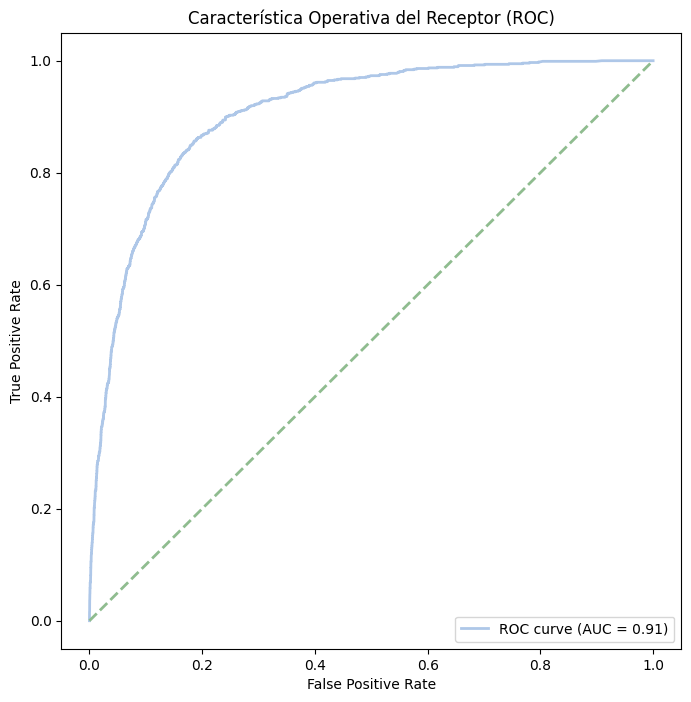

In [450]:
y_prob = clf_call.predict_proba(x_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))

plt.plot(fpr, tpr, color=colores[0], lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color=colores[1], lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Característica Operativa del Receptor (ROC)')
plt.legend(loc='lower right')

plt.show()

#### Feature importances

El análisis de importancia de características (feature importances) indica cómo cada característica contribuye a las predicciones del modelo. En este caso las características más importantes son:

* **first_call (0.204589)**: La característica "first_call" es la más importante, contribuyendo significativamente a las predicciones del modelo. 

* **euribor3m (0.179467)**: La tasa diaria del euribor también tiene una importancia considerable. Esto es coherente con observaciones anteriores que destacaban la relevancia de esta tasa en las contrataciones de depósitos a plazo fijo.

* **poutcome_1 (0.065462) y poutcome_2 (0.064894)**: Las categorías relacionadas con el resultado de campañas de marketing anteriores ("poutcome_1" y "poutcome_2") también tienen importancias significativas. Estas podrían estar relacionadas con el éxito previo de las campañas y su impacto en las decisiones de contratación.

* **job_blue-collar (0.047184)**: La categoría laboral "blue-collar" también contribuye en gran medida a las predicciones. Esto sugiere que el tipo de trabajo puede influir en la probabilidad de contratación.

* **default_no (0.040522)**: La ausencia de incumplimiento crediticio ("default_no") tiene cierta importancia en las predicciones, lo que indica que aquellos sin historial de incumplimiento tienden a tener más probabilidades de contratar.

In [451]:
importances = clf_call.feature_importances_

df_importances = pd.DataFrame({'Feature': x_test.columns, 'Importance': clf_call.feature_importances_})
df_importances = df_importances.sort_values(by='Importance', ascending=False)

df_importances

,Feature,Importance
3,first_call,0.204589
2,euribor3m,0.179467
45,poutcome_1,0.065462
46,poutcome_2,0.064894
5,job_blue-collar,0.047184
38,default_no,0.040522
29,education_university.degree,0.026475
0,age,0.024459
23,education_basic.4y,0.022321
25,education_basic.9y,0.019914


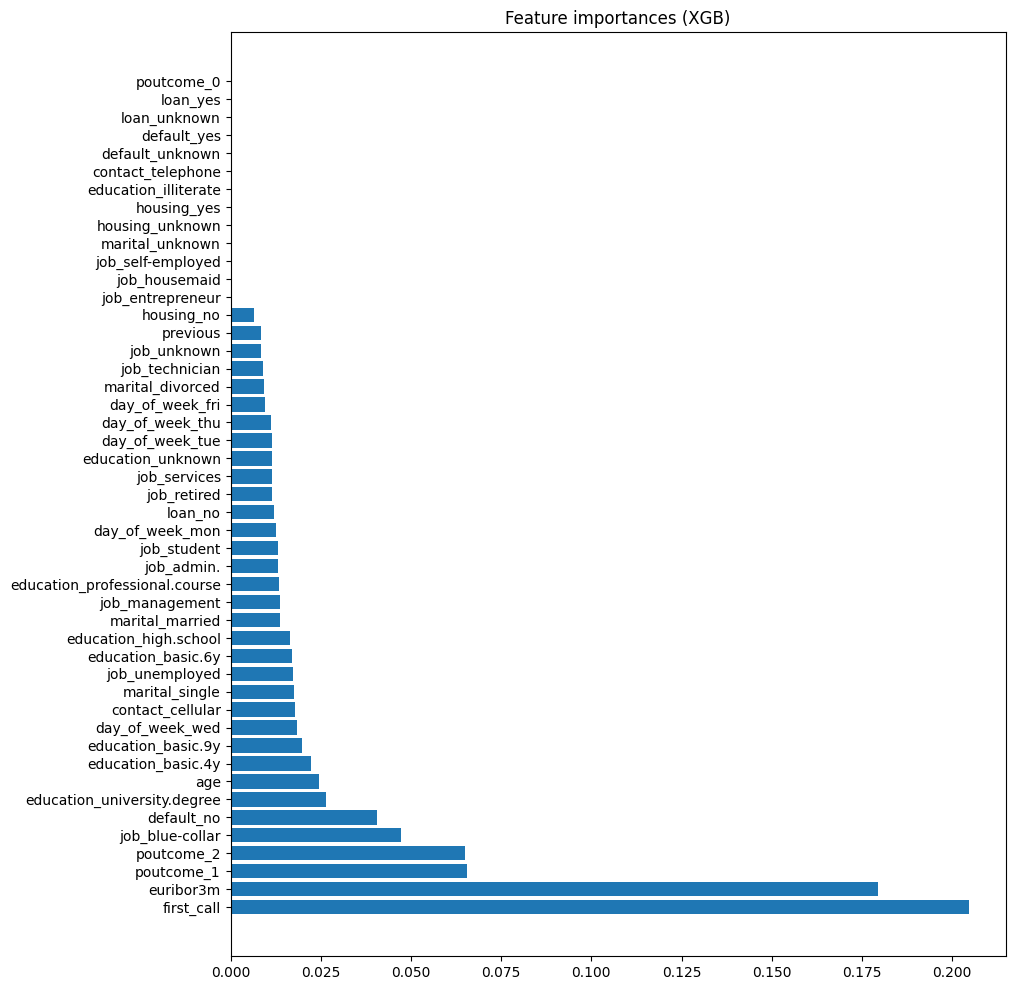

In [ ]:
# Visualizar las feature importances
headers = ["name", "score"]
values = sorted(zip(X_rus_3.columns, clf_call.feature_importances_), key=lambda x: x[1] * -1)
clf_call_feature_importances = pd.DataFrame(values, columns=headers)

plt.figure(figsize=(10, 12))
y_pos = np.arange(0, len(clf_call_feature_importances))
plt.barh(y_pos, clf_call_feature_importances['score'])
plt.yticks(y_pos, clf_call_feature_importances['name'])
plt.title('Feature importances (XGB)')

plt.show()

## 06. Conclusiones y acciones

A continuación, se presentan algunas acciones a considerar para el banco:

* **Enfoque en la tasa del euribor**: Dado que la tasa diaria del Euribor es la característica más influyente, el banco puede centrar sus estrategias de marketing y llamadas en momentos en los que la tasa del Euribor sea favorable para la contratación de depósitos a plazo fijo.

* **Monitorización Continua del Euribor**: Dada la fuerte correlación entre el Euribor y las contrataciones, se recomienda monitorear de cerca este indicador y ajustar estrategias según las fluctuaciones diarias.

* Aunque la importancia es menor, el resultado exitoso de campañas anteriores esigue siendo relevante. Se puede enfocar en clientes que previamente respondieron positivamente a campañas para mejorar las tasas de contratación.

* Planificar bien la primera llamada: El banco debe dar prioridad a la primera llamada, asegurándose de que sea estratégicamente planificada y tenga la información más relevante para aumentar las posibilidades de contratación.

* **Edad**: Implementar estrategias de comunicación diferenciadas para adaptarse a las distintas franjas. Explorar opciones de productos específicos para clientes más jóvenes y mayores.

* **Refinamiento del Filtro de Impagos**: Evaluar y ajustar el criterio de filtrado de impagos para optimizar la identificación de clientes con un historial crediticio sólido. Esto puede ayudar a minimizar riesgos y mejorar la eficacia de futuras campañas.

* **Promoción de Préstamos del Hogar**: Desarrollar estrategias específicas para promover la contratación de productos adicionales, como préstamos personales, entre clientes que ya tienen préstamos del hogar. Ofrecer incentivos o beneficios adicionales puede aumentar la adopción de estos productos.

* **Número de contactos**: Optimizar la efectividad de las primeras interacciones, enfocándose en mensajes claros y convincentes. Evaluar estrategias para reducir la necesidad de múltiples contactos, mejorando la eficiencia y satisfacción del cliente.


## 07. Referencias:
1) Hands-On Machine Learning with Scikit-Learn and TensorFlow by Aurélien Géron.<br>
2) Teoría proporcionada en el Bootcamp de Ciencia de Datos.
3) [Dataset](https://www.kaggle.com/datasets/henriqueyamahata/bank-marketing) 